In [83]:
#!pip install nb_black  --> I don't know what these two does, so I just comment them.
# AM: It formats the code nicely according to best practice - https://github.com/dnanhkhoa/nb_black

<IPython.core.display.Javascript object>

In [62]:
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

# QRM First Assignment

#### Discussion Box (Keep track of resolved issues here, will delete later)

**Questions so far:**
1. What is the difference between Close and Adj. Close? Which to use?
2. np.log is used for natural logarithm, right?
(Natural logarithm, element-wise. --copied from documentation page)

**Close price adjusted for splits.** 
<br>
''The closing price of a stock is the price of that stock at the close of the trading day.''


**Adjusted close price adjusted for both dividends and splits.**
<br>
''The adjusted closing price is a more complex analysis that uses the closing price as a starting point, but it takes into account factors such as dividends, stock splits and new stock offerings to determine a value. The adjusted closing price represents a more accurate reflection of a stock's value, since distributions and new offerings can alter the closing price.''

So I think in the sense of these dataset, the close price is also a kind of adjusted price since it is adjusted for splits.<br>
I personally would think the adjusted close price (both div and splits) would be better since it's more accurate.

**Discussion:**
**1. Drop the 20 rows for N225 dataset?** <br>
AM: Correct and we need to synchronise with the rest of the data by only considering days where an observation is available for all risk factors <br>
**2. The DE_1YBOND attribute doesn't match with other 4, will the attribute affect the analysis? If not then we can keep them** <br>
AM: This is because the first 4 datasets are from Yahoo data and this one is from another source. It's not a problem as long as we can merge it by Date to the rest of the data.<br>
**3. There would defo some outliers in the data, we shoud decide how to deal with them.**<br>
AM: Good question, let's ask Svetlana and Sarah.

**09.04 AM:**
   1. I think that trying with 2 datasets should happen in a bit different way  ((done))
   2. Isolate the columns of adj. price for each asset and give them clear names to which asset they belong ((done))
   3. Perform a join with on the Date variable (I think the concat function is not doing the job here) ((done))

**11.04 Pan:** I fixed the above probelms.

##### I suggest to keep log of our Methodology and Questions and write email to Svetlana/Sarah next week to verify and ask - do you agree?

**Methodology**
1. Create lags for each individual asset and compute individual asset returns
2. Merge the individual asset datasets and compute portfolio returns and portfolio standard deviation

**Questions**
1. How to deal with unmatching data (i.e. there is obs. for a particular dataset for one asset but none for another asset?). Should we delete all observations for that date altogether? How do we deal with the gap in history? <br>
**Pan:** I took the intersection dates of all five assets. 
I am not sure if it is proper but this is the best we can do so far. <br>
We can ask them!!

2. How to deal with outliers? <br>
**Pan:** The data looks normal so outlier doesn't seem to be a big probelm, but maybe it would affect <br>
when adding the bond. Let's ask as well!

##### Question: My code above looks ugly as I am doing the operations for each dataset separately instead of using some kind of loop to iterate. Can we, please, set up a short call so you can teach me how to do the iteration? :D I will appreciate some CS help! 

**Pan:** Sure, I also took some time to make it into function. <br>
You can have a look and if you don't know some parts, we can have a call :D

## Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import statsmodels.api as sm
from scipy.optimize import minimize
from scipy.stats import norm
import scipy as sc
import glob
import matplotlib.pyplot as plt
import os

## Exploratory Data Analysis

In [2]:
"""Import data"""
BTC = pd.read_csv("01_Data/BTCUSD.csv",)
DBC = pd.read_csv("01_Data/DBC.csv")
GSPC = pd.read_csv("01_Data/GSPC.csv")
N225 = pd.read_csv("01_Data/N225.csv")
DE_1YBOND = pd.read_csv("01_Data/DE_1YBOND.csv")
FX_YEN = pd.read_csv("01_Data/JPYUSD=X.csv")
FX_EUR = pd.read_csv("01_Data/EURUSD=X.csv")


"""Check format of the datasets"""
# print(BTC.shape)
# print(DBC.shape)
# print(DE_1YBOND.shape)
# print(GSPC.shape)
# print(N225.shape)
# print(FX_YEN.shape)
# print(FX_EUR.shape)

"""The attribute format of DE bond is different from others"""
# DE_1YBOND.head()
# print(FX_YEN.head())

"""Check if there is null or empty input for any of the datasets."""
# N225.isnull().sum()
# BTC.isnull().sum()
# DBC.isnull().sum()
# GSPC.isnull().sum()
# DE_1YBOND.isnull().sum()
# print(FX_YEN.isnull().sum())
# print(FX_EUR.isnull().sum())

"""N225 has 20 missing values"""
# missing_N225 = N225[N225.isna().any(axis=1)]['Date']
# print(len(N225[N225.isna().any(axis=1)]))
# print(missing_N225)

'N225 has 20 missing values'

**EDA shows 2 issues:**
<br>
1. The attribute format of the bond is different from the stocks
<br>
2. N225 contains 20 missing values, which need to be dropped

In [3]:
""" Change the date format of DE_1YBOND"""
from datetime import datetime

new_date = []
for i in DE_1YBOND["Date"]:
    new = datetime.strptime(i, "%b %d, %Y").strftime("%Y-%m-%d")
    new_date.append(new)

DE_1YBOND["Date"] = new_date

In [4]:
""" Drop the rows which contains missing value in N225"""
N225_drop = N225.dropna(axis=0)
N225_drop = N225_drop.reset_index(drop=True)
print(len(N225_drop))
# N225_drop.isnull().sum()

2205


In [5]:
""" Drop the rows which contains missing value in FX_YEN"""
FX_YEN_drop = FX_YEN.dropna(axis=0)
FX_YEN_drop = FX_YEN_drop.reset_index(drop=True)

""" Drop the rows which contains missing value in FX_EUR"""
FX_EUR_drop = FX_EUR.dropna(axis=0)
FX_EUR_drop = FX_EUR_drop.reset_index(drop=True)

print(len(FX_YEN_drop))
print(len(FX_EUR_drop))

2344
2344


## Data Processing

### 1. Merge data

In [6]:
s1 = set(GSPC["Date"])
s2 = set(DBC["Date"])
s3 = set(N225_drop["Date"])
s4 = set(BTC["Date"])
s5 = set(DE_1YBOND["Date"])
s6 = set(FX_YEN_drop["Date"])
s7 = set(FX_EUR_drop["Date"])

d = [
    x for x in s3 if x in s1 and x in s2 and x in s4 and x in s5 and x in s6 and x in s7
]

asset = [s1, s2, s3, s4, s5, s6, s7]

intersec = s3.intersection(s1, s2, s4, s5, s6, s7)
print(len(intersec))
print(len(d))
set(d) == set(intersec)

print("The dates exist in all five dataset: 2112 trading days")

2112
2112
The dates exist in all five dataset: 2112 trading days


In [7]:
"""  Create new dataframes, keep only the overlapping date-related data"""

new = []
asset = [BTC, DBC, DE_1YBOND, GSPC, N225_drop, FX_YEN_drop, FX_EUR_drop]
for item in asset:
    miss = []
    for i in item["Date"]:
        if i not in intersec:
            miss = miss + item.index[item["Date"] == i].tolist()
    item = item.drop(miss)
    item = item.reset_index(drop=True)
    new.append(item)

In [8]:
""" Assign the dataframe """

BTC_new = new[0]
DBC_new = new[1]
DE_1YBOND_new = new[2]
GSPC_new = new[3]
N225_new = new[4]
FX_YEN_new = new[5]
FX_EUR_new = new[6]

asset = [BTC_new, DBC_new, DE_1YBOND_new, GSPC_new, N225_new, FX_YEN_new, FX_EUR_new]

for i in asset:
    print(i.shape)
    print(i.isnull().sum())

(2112, 7)
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
(2112, 7)
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
(2112, 6)
Date        0
Price       0
Open        0
High        0
Low         0
Change %    0
dtype: int64
(2112, 7)
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
(2112, 7)
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
(2112, 7)
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
(2112, 7)
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [71]:
DE_1YBOND_new.head()

,Date,Price,Open,High,Low,Change %
0,2020-03-30,-0.689,-0.685,-0.658,-0.881,-1.85%
1,2020-03-27,-0.702,-0.626,-0.600,-0.920,14.89%
2,2020-03-26,-0.611,-0.645,-0.562,-0.679,-3.63%
3,2020-03-25,-0.634,-0.615,-0.557,-0.674,4.97%
4,2020-03-24,-0.604,-0.678,-0.600,-0.723,-12.21%


<IPython.core.display.Javascript object>

In [9]:
""" Process German Bonds data to match the format of the rest of the datasets """
"""Rename Columns"""
DE_1YBOND_new.rename(columns={"Price": "Adj Close"}, inplace=True)
"""Sort Data"""
DE_1YBOND_new = DE_1YBOND_new.sort_values(by=["Date"]).reset_index(drop=True)

In [10]:
DE_1YBOND_new.head()

,Date,Adj Close,Open,High,Low,Change %
0,2011-03-31,1.209,1.209,1.209,1.209,2.28%
1,2011-04-01,1.306,1.306,1.306,1.306,8.02%
2,2011-04-04,1.292,1.292,1.292,1.292,-1.07%
3,2011-04-05,1.299,1.299,1.299,1.299,0.54%
4,2011-04-06,1.294,1.294,1.294,1.294,-0.38%


In [10]:
###SANDBOX


""" Create new dataframe containing only the same dates related information  """

# asset_price , asset_adj_price , return

asset = [DE_1YBOND_new, BTC_new, DBC_new, GSPC_new, N225_new, FX_YEN_new, FX_EUR_new]
asset_name = ["DE_1YBOND", "BTC", "DBC", "GSPC", "N225", "FX_YEN", "FX_EUR"]

for i in range(len(asset)):
    """Rename Price column"""
    asset[i].rename(columns={"Adj Close": "Price_" + asset_name[i]}, inplace=True)
    """Create lags for all assets"""
    asset[i]["Price_" + asset_name[i] + "_lag"] = asset[i][
        "Price_" + asset_name[i]
    ].shift(1)
    """Calculate individual asset returns"""
    # Bonds - simple difference between current and lagged value; Stocks - log return
    if i == 0:
        asset[i][asset_name[i] + "_return"] = (
            asset[i]["Price_" + asset_name[i]]
            - asset[i]["Price_" + asset_name[i] + "_lag"]
        )
    else:
        asset[i][asset_name[i] + "_return"] = np.log(
            asset[i]["Price_" + asset_name[i]]
            / asset[i]["Price_" + asset_name[i] + "_lag"]
        )

    if i == 0:

        # Create stressed interest rate prices (only for bonds) - that's some horrible coding in here
        asset[i]["Price_" + asset_name[i] + "_plus2perc"] = (
            asset[i]["Price_" + asset_name[i]] + 0.02
        )
        asset[i]["Price_" + asset_name[i] + "_plus3perc"] = (
            asset[i]["Price_" + asset_name[i]] + 0.03
        )
        asset[i]["Price_" + asset_name[i] + "_minus2perc"] = (
            asset[i]["Price_" + asset_name[i]] - 0.02
        )
        asset[i]["Price_" + asset_name[i] + "_minus3perc"] = (
            asset[i]["Price_" + asset_name[i]] - 0.03
        )

        # Create lagged values
        asset[i]["Price_" + asset_name[i] + "_plus2perc_lag"] = asset[i][
            "Price_" + asset_name[i] + "_plus2perc"
        ].shift(1)
        asset[i]["Price_" + asset_name[i] + "_plus3perc_lag"] = asset[i][
            "Price_" + asset_name[i] + "_plus3perc"
        ].shift(1)
        asset[i]["Price_" + asset_name[i] + "_minus2perc_lag"] = asset[i][
            "Price_" + asset_name[i] + "_minus2perc"
        ].shift(1)
        asset[i]["Price_" + asset_name[i] + "_minus3perc_lag"] = asset[i][
            "Price_" + asset_name[i] + "_minus3perc"
        ].shift(1)

        # Create stressed returns
        asset[i][asset_name[i] + "_plus2perc" + "_return"] = (
            asset[i]["Price_" + asset_name[i] + "_plus2perc"]
            - asset[i]["Price_" + asset_name[i] + "_plus2perc_lag"]
        )
        asset[i][asset_name[i] + "_plus3perc" + "_return"] = (
            asset[i]["Price_" + asset_name[i] + "_plus3perc"]
            - asset[i]["Price_" + asset_name[i] + "_plus3perc_lag"]
        )
        asset[i][asset_name[i] + "_minus2perc" + "_return"] = (
            asset[i]["Price_" + asset_name[i] + "_minus2perc"]
            - asset[i]["Price_" + asset_name[i] + "_minus2perc_lag"]
        )
        asset[i][asset_name[i] + "_minus3perc" + "_return"] = (
            asset[i]["Price_" + asset_name[i] + "_minus3perc"]
            - asset[i]["Price_" + asset_name[i] + "_minus3perc_lag"]
        )

    else:

        # Create stressed equity prices - only for stocks
        asset[i]["Price_" + asset_name[i] + "_plus20"] = (
            asset[i]["Price_" + asset_name[i]] * 1.2
        )
        asset[i]["Price_" + asset_name[i] + "_plus40"] = (
            asset[i]["Price_" + asset_name[i]] * 1.4
        )
        asset[i]["Price_" + asset_name[i] + "_minus20"] = (
            asset[i]["Price_" + asset_name[i]] * 0.8
        )
        asset[i]["Price_" + asset_name[i] + "_minus40"] = (
            asset[i]["Price_" + asset_name[i]] * 0.6
        )

        # Create stressed returns
        asset[i]["Price_" + asset_name[i] + "_plus20_lag"] = asset[i][
            "Price_" + asset_name[i] + "_plus20"
        ].shift(1)
        asset[i]["Price_" + asset_name[i] + "_plus40_lag"] = asset[i][
            "Price_" + asset_name[i] + "_plus40"
        ].shift(1)
        asset[i]["Price_" + asset_name[i] + "_minus20_lag"] = asset[i][
            "Price_" + asset_name[i] + "_minus20"
        ].shift(1)
        asset[i]["Price_" + asset_name[i] + "_minus40_lag"] = asset[i][
            "Price_" + asset_name[i] + "_minus40"
        ].shift(1)

        asset[i][asset_name[i] + "_plus20" + "_return"] = np.log(
            asset[i]["Price_" + asset_name[i] + "_plus20"]
            / asset[i]["Price_" + asset_name[i] + "_plus20_lag"]
        )
        asset[i][asset_name[i] + "_plus40" + "_return"] = np.log(
            asset[i]["Price_" + asset_name[i] + "_plus40"]
            / asset[i]["Price_" + asset_name[i] + "_plus40_lag"]
        )
        asset[i][asset_name[i] + "_minus20" + "_return"] = np.log(
            asset[i]["Price_" + asset_name[i] + "_minus20"]
            / asset[i]["Price_" + asset_name[i] + "_minus20_lag"]
        )
        asset[i][asset_name[i] + "_minus40" + "_return"] = np.log(
            asset[i]["Price_" + asset_name[i] + "_minus40"]
            / asset[i]["Price_" + asset_name[i] + "_minus40_lag"]
        )


print(DE_1YBOND_new)
print(BTC_new)

            Date  Price_DE_1YBOND   Open   High    Low Change %  \
0     2011-03-31            1.209  1.209  1.209  1.209    2.28%   
1     2011-04-01            1.306  1.306  1.306  1.306    8.02%   
2     2011-04-04            1.292  1.292  1.292  1.292   -1.07%   
3     2011-04-05            1.299  1.299  1.299  1.299    0.54%   
4     2011-04-06            1.294  1.294  1.294  1.294   -0.38%   
...          ...              ...    ...    ...    ...      ...   
2107  2020-03-24           -0.604 -0.678 -0.600 -0.723  -12.21%   
2108  2020-03-25           -0.634 -0.615 -0.557 -0.674    4.97%   
2109  2020-03-26           -0.611 -0.645 -0.562 -0.679   -3.63%   
2110  2020-03-27           -0.702 -0.626 -0.600 -0.920   14.89%   
2111  2020-03-30           -0.689 -0.685 -0.658 -0.881   -1.85%   

      Price_DE_1YBOND_lag  DE_1YBOND_return  Price_DE_1YBOND_plus2perc  \
0                     NaN               NaN                      1.229   
1                   1.209             0.097    

In [11]:
# Keep only relevant columns

result = []
for i in range(len(asset)):
    print(asset_name[i])
    if i == 0:
        asset[i] = asset[i][
            [
                "Date",
                "Price_" + asset_name[i],
                "Price_" + asset_name[i] + "_lag",
                asset_name[i] + "_return",
                asset_name[i] + "_plus2perc" + "_return",
                asset_name[i] + "_plus3perc" + "_return",
                asset_name[i] + "_minus2perc" + "_return",
                asset_name[i] + "_minus3perc" + "_return",
            ]
        ]
        result.append(asset[i])
    else:
        asset[i] = asset[i][
            [
                "Price_" + asset_name[i],
                "Price_" + asset_name[i] + "_lag",
                asset_name[i] + "_return",
                asset_name[i] + "_plus20" + "_return",
                asset_name[i] + "_plus40" + "_return",
                asset_name[i] + "_minus20" + "_return",
                asset_name[i] + "_minus40" + "_return",
            ]
        ]
        result.append(asset[i])

DE_1YBOND
BTC
DBC
GSPC
N225
FX_YEN
FX_EUR


In [12]:
# Check the shape
BTC_new = result[1]
DBC_new = result[2]
DE_1YBOND_new = result[0]
GSPC_new = result[3]
N225_new = result[4]
FX_YEN_new = result[5]
FX_EUR_new = result[6]


asset = [BTC_new,DBC_new, DE_1YBOND_new, GSPC_new,N225_new,FX_YEN_new,FX_EUR_new]


for i in asset:
    print(i.shape)


(2112, 7)
(2112, 7)
(2112, 8)
(2112, 7)
(2112, 7)
(2112, 7)
(2112, 7)


In [13]:
''' data for GARCH and EWMA'''
data_new = pd.concat([DE_1YBOND_new, BTC_new, DBC_new, GSPC_new, N225_new,FX_YEN_new,FX_EUR_new],axis=1)

In [14]:
data_new.head()

,Date,Price_DE_1YBOND,Price_DE_1YBOND_lag,DE_1YBOND_return,DE_1YBOND_plus2perc_return,DE_1YBOND_plus3perc_return,DE_1YBOND_minus2perc_return,DE_1YBOND_minus3perc_return,Price_BTC,Price_BTC_lag,...,FX_YEN_plus40_return,FX_YEN_minus20_return,FX_YEN_minus40_return,Price_FX_EUR,Price_FX_EUR_lag,FX_EUR_return,FX_EUR_plus20_return,FX_EUR_plus40_return,FX_EUR_minus20_return,FX_EUR_minus40_return
0,2011-03-31,1.209,NaN,NaN,NaN,NaN,NaN,NaN,0.7846,NaN,...,NaN,NaN,NaN,1.412130,NaN,NaN,NaN,NaN,NaN,NaN
1,2011-04-01,1.306,1.209,0.097,0.097,0.097,0.097,0.097,0.7741,0.7846,...,-0.002498,-0.002498,-0.002498,1.415869,1.412130,0.002644,0.002644,0.002644,0.002644,0.002644
2,2011-04-04,1.292,1.306,-0.014,-0.014,-0.014,-0.014,-0.014,0.6800,0.7741,...,-0.010222,-0.010222,-0.010222,1.422333,1.415869,0.004555,0.004555,0.004555,0.004555,0.004555
3,2011-04-05,1.299,1.292,0.007,0.007,0.007,0.007,0.007,0.7100,0.6800,...,0.001010,0.001010,0.001010,1.422010,1.422333,-0.000227,-0.000227,-0.000227,-0.000227,-0.000227
4,2011-04-06,1.294,1.299,-0.005,-0.005,-0.005,-0.005,-0.005,0.7400,0.7100,...,-0.012104,-0.012104,-0.012104,1.421909,1.422010,-0.000071,-0.000071,-0.000071,-0.000071,-0.000071


In [15]:
df_prices2 = data_new[['DE_1YBOND_return','BTC_return','DBC_return','GSPC_return','N225_return',\
                  'FX_EUR_return','FX_YEN_return']]
df_prices2 = df_prices2.set_index(pd.to_datetime(data_new["Date"]))

In [17]:
df_prices2.head()

,DE_1YBOND_return,BTC_return,DBC_return,GSPC_return,N225_return,FX_EUR_return,FX_YEN_return
Date,,,,,,,
2011-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-04-01,0.097,-0.013473,0.006859,0.004951,-0.004800,0.002644,-0.002498
2011-04-04,-0.014,-0.129608,0.009073,0.000345,0.001081,0.004555,-0.010222
2011-04-05,0.007,0.043172,0.000967,-0.000180,-0.010690,-0.000227,0.001010
2011-04-06,-0.005,0.041385,0.002896,0.002181,-0.003248,-0.000071,-0.012104


In [16]:
print(N225_new["N225_return"].head())
print(FX_YEN_new["FX_YEN_return"].head())

0         NaN
1   -0.004800
2    0.001081
3   -0.010690
4   -0.003248
Name: N225_return, dtype: float64
0         NaN
1   -0.002498
2   -0.010222
3    0.001010
4   -0.012104
Name: FX_YEN_return, dtype: float64


In [16]:
""" Add the Nikkei return and FX_YUAN together as one total N225 return"""

N225_new["N225_return_all"] = N225_new["N225_return"] + FX_YEN_new["FX_YEN_return"]
N225_new = N225_new.drop(["N225_return"], axis=1)
N225_new.rename(columns={"N225_return_all": "N225_return"}, inplace=True)
N225_new

/home/isualice/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Price_N225,Price_N225_lag,N225_plus20_return,N225_plus40_return,N225_minus20_return,N225_minus40_return,N225_return
0,9755.099609,NaN,NaN,NaN,NaN,NaN,NaN
1,9708.389648,9755.099609,-0.004800,-0.004800,-0.004800,-0.004800,-0.007297
2,9718.889648,9708.389648,0.001081,0.001081,0.001081,0.001081,-0.009141
3,9615.549805,9718.889648,-0.010690,-0.010690,-0.010690,-0.010690,-0.009680
4,9584.370117,9615.549805,-0.003248,-0.003248,-0.003248,-0.003248,-0.015352
...,...,...,...,...,...,...,...
2107,18092.349609,16887.779297,0.068899,0.068899,0.068899,0.068899,0.065580
2108,19546.630859,18092.349609,0.077314,0.077314,0.077314,0.077314,0.074650
2109,18664.599609,19546.630859,-0.046174,-0.046174,-0.046174,-0.046174,-0.043954
2110,19389.429688,18664.599609,0.038099,0.038099,0.038099,0.038099,0.054158


In [18]:
"""Do the same for the stressed equities"""

return_all_name = [
    "N225_return_all_plus20",
    "N225_return_all_plus40",
    "N225_return_all_minus20",
    "N225_return_all_minus40",
]
return_name = [
    "N225_plus20_return",
    "N225_plus40_return",
    "N225_minus20_return",
    "N225_minus40_return",
]

for name, name_all in zip(return_name, return_all_name):
    N225_new[name_all] = N225_new[name] + FX_YEN_new["FX_YEN_return"]
    N225_new = N225_new.drop([name], axis=1)
    N225_new.rename(columns={name_all: name}, inplace=True)

In [19]:
"""Create stressed FX"""
N225_new["N225_return_FXplus10"] = (
    N225_new["N225_return"] + FX_YEN_new["FX_YEN_return"] * 1.1
)

N225_new["N225_return_FXminus10"] = (
    N225_new["N225_return"] + FX_YEN_new["FX_YEN_return"] * 0.9
)

N225_new

,Price_N225,Price_N225_lag,N225_return,N225_plus20_return,N225_plus40_return,N225_minus20_return,N225_minus40_return,N225_return_FXplus10,N225_return_FXminus10
0,9755.099609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9708.389648,9755.099609,-0.007297,-0.007297,-0.007297,-0.007297,-0.007297,-0.010045,-0.009545
2,9718.889648,9708.389648,-0.009141,-0.009141,-0.009141,-0.009141,-0.009141,-0.020386,-0.018341
3,9615.549805,9718.889648,-0.009680,-0.009680,-0.009680,-0.009680,-0.009680,-0.008569,-0.008771
4,9584.370117,9615.549805,-0.015352,-0.015352,-0.015352,-0.015352,-0.015352,-0.028666,-0.026245
...,...,...,...,...,...,...,...,...,...
2107,18092.349609,16887.779297,0.065580,0.065580,0.065580,0.065580,0.065580,0.061928,0.062592
2108,19546.630859,18092.349609,0.074650,0.074650,0.074650,0.074650,0.074650,0.071721,0.072253
2109,18664.599609,19546.630859,-0.043954,-0.043954,-0.043954,-0.043954,-0.043954,-0.041512,-0.041956
2110,19389.429688,18664.599609,0.054158,0.054158,0.054158,0.054158,0.054158,0.071822,0.068610


In [20]:
"""And drop FX_YEN and FX_EUR from the list """
asset = [BTC_new, DBC_new, GSPC_new, N225_new, DE_1YBOND_new, FX_YEN_new, FX_EUR_new]

asset = asset[:-2]
print(asset)

[        Price_BTC  Price_BTC_lag  BTC_return  BTC_plus20_return  \
0        0.784600            NaN         NaN                NaN   
1        0.774100       0.784600   -0.013473          -0.013473   
2        0.680000       0.774100   -0.129608          -0.129608   
3        0.710000       0.680000    0.043172           0.043172   
4        0.740000       0.710000    0.041385           0.041385   
...           ...            ...         ...                ...   
2107  6734.804688    6416.314941    0.048445           0.048445   
2108  6681.062500    6734.804688   -0.008012          -0.008012   
2109  6716.439941    6681.062500    0.005281           0.005281   
2110  6469.799316    6716.439941   -0.037413          -0.037413   
2111  6441.589355    6469.799316   -0.004370          -0.004370   

      BTC_plus40_return  BTC_minus20_return  BTC_minus40_return  
0                   NaN                 NaN                 NaN  
1             -0.013473           -0.013473           -0.01347

In [21]:
asset[-1]

,Date,Price_DE_1YBOND,Price_DE_1YBOND_lag,DE_1YBOND_return,DE_1YBOND_plus2perc_return,DE_1YBOND_plus3perc_return,DE_1YBOND_minus2perc_return,DE_1YBOND_minus3perc_return
0,2011-03-31,1.209,NaN,NaN,NaN,NaN,NaN,NaN
1,2011-04-01,1.306,1.209,0.097,0.097,0.097,0.097,0.097
2,2011-04-04,1.292,1.306,-0.014,-0.014,-0.014,-0.014,-0.014
3,2011-04-05,1.299,1.292,0.007,0.007,0.007,0.007,0.007
4,2011-04-06,1.294,1.299,-0.005,-0.005,-0.005,-0.005,-0.005
...,...,...,...,...,...,...,...,...
2107,2020-03-24,-0.604,-0.688,0.084,0.084,0.084,0.084,0.084
2108,2020-03-25,-0.634,-0.604,-0.030,-0.030,-0.030,-0.030,-0.030
2109,2020-03-26,-0.611,-0.634,0.023,0.023,0.023,0.023,0.023
2110,2020-03-27,-0.702,-0.611,-0.091,-0.091,-0.091,-0.091,-0.091


In [22]:
# Merge
asset = [DE_1YBOND_new, BTC_new, DBC_new, GSPC_new, N225_new]
data = pd.concat(asset, axis=1)
data.head()

,Date,Price_DE_1YBOND,Price_DE_1YBOND_lag,DE_1YBOND_return,DE_1YBOND_plus2perc_return,DE_1YBOND_plus3perc_return,DE_1YBOND_minus2perc_return,DE_1YBOND_minus3perc_return,Price_BTC,Price_BTC_lag,...,GSPC_minus40_return,Price_N225,Price_N225_lag,N225_return,N225_plus20_return,N225_plus40_return,N225_minus20_return,N225_minus40_return,N225_return_FXplus10,N225_return_FXminus10
0,2011-03-31,1.209,NaN,NaN,NaN,NaN,NaN,NaN,0.7846,NaN,...,NaN,9755.099609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011-04-01,1.306,1.209,0.097,0.097,0.097,0.097,0.097,0.7741,0.7846,...,0.004951,9708.389648,9755.099609,-0.007297,-0.007297,-0.007297,-0.007297,-0.007297,-0.010045,-0.009545
2,2011-04-04,1.292,1.306,-0.014,-0.014,-0.014,-0.014,-0.014,0.6800,0.7741,...,0.000345,9718.889648,9708.389648,-0.009141,-0.009141,-0.009141,-0.009141,-0.009141,-0.020386,-0.018341
3,2011-04-05,1.299,1.292,0.007,0.007,0.007,0.007,0.007,0.7100,0.6800,...,-0.000180,9615.549805,9718.889648,-0.009680,-0.009680,-0.009680,-0.009680,-0.009680,-0.008569,-0.008771
4,2011-04-06,1.294,1.299,-0.005,-0.005,-0.005,-0.005,-0.005,0.7400,0.7100,...,0.002181,9584.370117,9615.549805,-0.015352,-0.015352,-0.015352,-0.015352,-0.015352,-0.028666,-0.026245


### 2.1 Calculate portfolio returns (with and without Stress)

In [23]:
"""Assume equal weight (0.20) for the 5 assets and calculate portfolio returns - later to change it when we also add the bond"""

# Non-stressed

data["portfolio_return"] = (
    0.20 * data["BTC_return"]
    + 0.20 * data["DBC_return"]
    + 0.20 * data["GSPC_return"]
    + 0.20 * data["N225_return"]
    + 0.20 * data["DE_1YBOND_return"]
)

# Stressed equities

data["portfolio_return_plus20"] = (
    0.20 * data["BTC_plus20_return"]
    + 0.20 * data["DBC_return"]
    + 0.20 * data["GSPC_plus20_return"]
    + 0.20 * data["N225_plus20_return"]
    + 0.20 * data["DE_1YBOND_return"]
)
data["portfolio_return_plus40"] = (
    0.20 * data["BTC_plus40_return"]
    + 0.20 * data["DBC_return"]
    + 0.20 * data["GSPC_plus40_return"]
    + 0.20 * data["N225_plus40_return"]
    + 0.20 * data["DE_1YBOND_return"]
)
data["portfolio_return_minus20"] = (
    0.20 * data["BTC_minus20_return"]
    + 0.20 * data["DBC_return"]
    + 0.20 * data["GSPC_minus20_return"]
    + 0.20 * data["N225_minus20_return"]
    + 0.20 * data["DE_1YBOND_return"]
)
data["portfolio_return_minus40"] = (
    0.20 * data["BTC_minus40_return"]
    + 0.20 * data["DBC_return"]
    + 0.20 * data["GSPC_minus40_return"]
    + 0.20 * data["N225_minus40_return"]
    + 0.20 * data["DE_1YBOND_return"]
)

# Stressed commodities

data["portfolio_return_complus20"] = (
    0.20 * data["BTC_return"]
    + 0.20 * data["DBC_plus20_return"]
    + 0.20 * data["GSPC_return"]
    + 0.20 * data["N225_return"]
    + 0.20 * data["DE_1YBOND_return"]
)
data["portfolio_return_complus40"] = (
    0.20 * data["BTC_return"]
    + 0.20 * data["DBC_plus40_return"]
    + 0.20 * data["GSPC_return"]
    + 0.20 * data["N225_return"]
    + 0.20 * data["DE_1YBOND_return"]
)
data["portfolio_return_comminus20"] = (
    0.20 * data["BTC_return"]
    + 0.20 * data["DBC_minus20_return"]
    + 0.20 * data["GSPC_return"]
    + 0.20 * data["N225_return"]
    + 0.20 * data["DE_1YBOND_return"]
)
data["portfolio_return_comminus40"] = (
    0.20 * data["BTC_return"]
    + 0.20 * data["DBC_minus40_return"]
    + 0.20 * data["GSPC_return"]
    + 0.20 * data["N225_return"]
    + 0.20 * data["DE_1YBOND_return"]
)

# Stressed IR
data["portfolio_return_IRplus2"] = (
    0.20 * data["BTC_return"]
    + 0.20 * data["DBC_return"]
    + 0.20 * data["GSPC_return"]
    + 0.20 * data["N225_return"]
    + 0.20 * data["DE_1YBOND_plus2perc_return"]
)

data["portfolio_return_IRplus3"] = (
    0.20 * data["BTC_return"]
    + 0.20 * data["DBC_return"]
    + 0.20 * data["GSPC_return"]
    + 0.20 * data["N225_return"]
    + 0.20 * data["DE_1YBOND_plus3perc_return"]
)

data["portfolio_return_IRminus2"] = (
    0.20 * data["BTC_return"]
    + 0.20 * data["DBC_return"]
    + 0.20 * data["GSPC_return"]
    + 0.20 * data["N225_return"]
    + 0.20 * data["DE_1YBOND_minus2perc_return"]
)

data["portfolio_return_IRminus3"] = (
    0.20 * data["BTC_return"]
    + 0.20 * data["DBC_return"]
    + 0.20 * data["GSPC_return"]
    + 0.20 * data["N225_return"]
    + 0.20 * data["DE_1YBOND_minus3perc_return"]
)

# Stressed FX

data["portfolio_return_FXplus10"] = (
    0.20 * data["BTC_return"]
    + 0.20 * data["DBC_return"]
    + 0.20 * data["GSPC_return"]
    + 0.20 * data["N225_return_FXplus10"]
    + 0.20 * data["DE_1YBOND_return"]
)

data["portfolio_return_FXminus10"] = (
    0.20 * data["BTC_return"]
    + 0.20 * data["DBC_return"]
    + 0.20 * data["GSPC_return"]
    + 0.20 * data["N225_return_FXminus10"]
    + 0.20 * data["DE_1YBOND_return"]
)

#### 2.2. Create Datasets for all stressed scenarios

In [24]:
# Stressed equities

df_prices_plus20 = data[
    [
        "DE_1YBOND_return",
        "BTC_plus20_return",
        "DBC_return",
        "GSPC_plus20_return",
        "N225_plus20_return",
        "portfolio_return_plus20",
    ]
]

df_prices_plus40 = data[
    [
        "DE_1YBOND_return",
        "BTC_plus40_return",
        "DBC_return",
        "GSPC_plus40_return",
        "N225_plus40_return",
        "portfolio_return_plus40",
    ]
]

df_prices_minus20 = data[
    [
        "DE_1YBOND_return",
        "BTC_minus20_return",
        "DBC_return",
        "GSPC_minus20_return",
        "N225_minus20_return",
        "portfolio_return_minus20",
    ]
]

df_prices_minus40 = data[
    [
        "DE_1YBOND_return",
        "BTC_minus40_return",
        "DBC_return",
        "GSPC_minus40_return",
        "N225_minus40_return",
        "portfolio_return_minus40",
    ]
]

# Stressed commodities

df_prices_complus20 = data[
    [
        "DE_1YBOND_return",
        "BTC_return",
        "DBC_plus20_return",
        "GSPC_return",
        "N225_return",
        "portfolio_return_complus20",
    ]
]

df_prices_complus40 = data[
    [
        "DE_1YBOND_return",
        "BTC_return",
        "DBC_plus40_return",
        "GSPC_return",
        "N225_return",
        "portfolio_return_complus40",
    ]
]

df_prices_comminus20 = data[
    [
        "DE_1YBOND_return",
        "BTC_return",
        "DBC_minus20_return",
        "GSPC_return",
        "N225_return",
        "portfolio_return_comminus20",
    ]
]

df_prices_comminus40 = data[
    [
        "DE_1YBOND_return",
        "BTC_minus40_return",
        "DBC_minus40_return",
        "GSPC_minus40_return",
        "N225_minus40_return",
        "portfolio_return_comminus40",
    ]
]


# Stressed IR

df_prices_IRplus2 = data[
    [
        "DE_1YBOND_plus2perc_return",
        "BTC_return",
        "DBC_return",
        "GSPC_return",
        "N225_return",
        "portfolio_return_IRplus2",
    ]
]

df_prices_IRplus3 = data[
    [
        "DE_1YBOND_plus3perc_return",
        "BTC_return",
        "DBC_return",
        "GSPC_return",
        "N225_return",
        "portfolio_return_IRplus3",
    ]
]

df_prices_IRminus2 = data[
    [
        "DE_1YBOND_minus2perc_return",
        "BTC_return",
        "DBC_return",
        "GSPC_return",
        "N225_return",
        "portfolio_return_IRminus2",
    ]
]

df_prices_IRminus3 = data[
    [
        "DE_1YBOND_minus3perc_return",
        "BTC_return",
        "DBC_return",
        "GSPC_return",
        "N225_return",
        "portfolio_return_IRminus3",
    ]
]


# Stressed FX

df_prices_FXplus10 = data[
    [
        "DE_1YBOND_return",
        "BTC_return",
        "DBC_return",
        "GSPC_return",
        "N225_return_FXplus10",
        "portfolio_return_FXplus10",
    ]
]

df_prices_FXminus10 = data[
    [
        "DE_1YBOND_return",
        "BTC_return",
        "DBC_return",
        "GSPC_return",
        "N225_return_FXminus10",
        "portfolio_return_FXminus10",
    ]
]

In [25]:
df_name = [
    "df_prices_plus20",
    "df_prices_plus40",
    "df_prices_minus20",
    "df_prices_minus40",
    "df_prices_complus20",
    "df_prices_complus40",
    "df_prices_comminus20",
    "df_prices_comminus40",
    "df_prices_IRplus2",
    "df_prices_IRplus3",
    "df_prices_IRminus2",
    "df_prices_IRminus3",
    "df_prices_FXplus10",
    "df_prices_FXminus10",
]
df_list = [
    df_prices_plus20,
    df_prices_plus40,
    df_prices_minus20,
    df_prices_minus40,
    df_prices_complus20,
    df_prices_complus40,
    df_prices_comminus20,
    df_prices_comminus40,
    df_prices_IRplus2,
    df_prices_IRplus3,
    df_prices_IRminus2,
    df_prices_IRminus3,
    df_prices_FXplus10,
    df_prices_FXminus10,
]
portfolio_return_name = [
    "portfolio_return_plus20",
    "portfolio_return_plus40",
    "portfolio_return_minus20",
    "portfolio_return_minus40",
    "portfolio_return_complus20",
    "portfolio_return_complus40",
    "portfolio_return_comminus20",
    "portfolio_return_comminus40",
    "portfolio_return_IRplus2",
    "portfolio_return_IRplus3",
    "portfolio_return_IRminus2",
    "portfolio_return_IRminus3",
    "portfolio_return_FXplus10",
    "portfolio_return_FXminus10",
]

In [26]:
# Rename the portfolio return columns to comply with the function input requirement
for df, name in zip(df_list, portfolio_return_name):
    df.rename(columns={name: "portfolio_return"}, inplace=True)

/home/isualice/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [27]:
number = [0,500,1000,1500,2000]
dates = []
for i in number:
    print(data.Date[i])
    dates.append(data.Date[i][:4])


2011-03-31
2013-05-20
2015-07-09
2017-08-21
2019-10-04


In [28]:
print(dates)

['2011', '2013', '2015', '2017', '2019']


[-500.    0.  500. 1000. 1500. 2000. 2500.]


Text(0, 0.5, 'Average portfolio return')

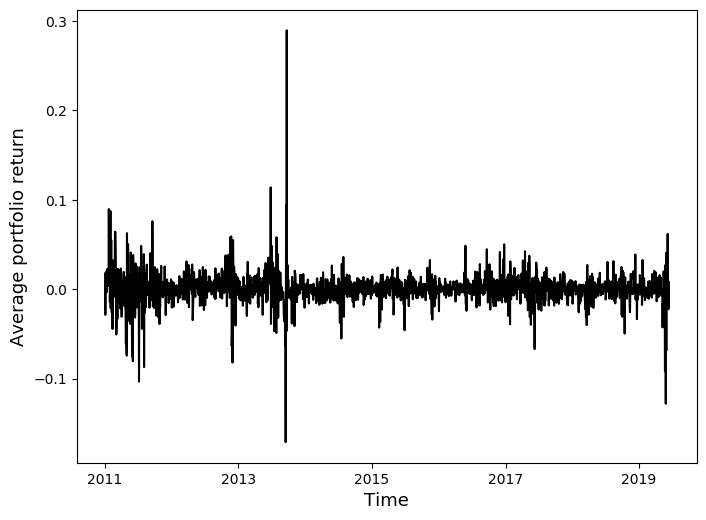

In [29]:
plt.figure(figsize=(8, 6), dpi=100)

plt.plot(data["portfolio_return"], "k")
locs, labels = plt.xticks()
print(locs)
x_ticks = []
new_xticks = [dates[i] for d in locs for i in range(5)]
plt.xticks(locs[1:-1], new_xticks)
plt.xlabel("Time", fontsize=13)
plt.ylabel("Average portfolio return", fontsize=13)

### 3. Plots

/home/isualice/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  import sys


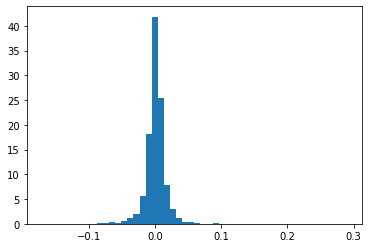

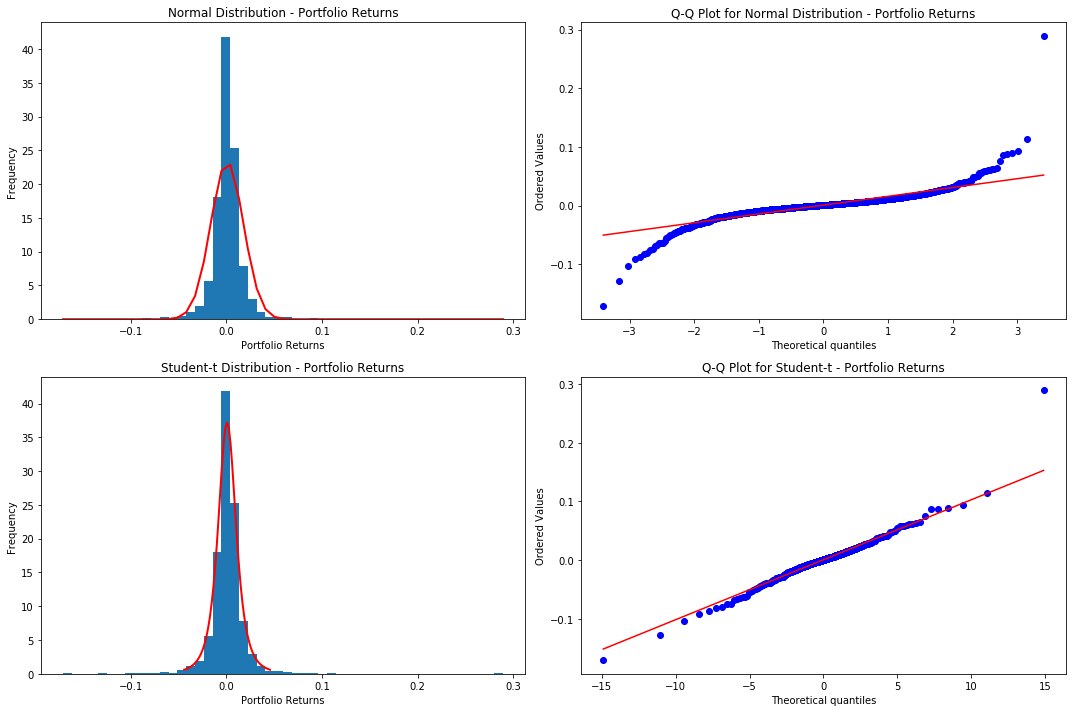

In [30]:
##assign df:
df = 3
# create distributions
mu = np.mean(data["portfolio_return"][1:])
sigma = np.std(data["portfolio_return"][1:])
sigmat = np.sqrt(np.var(data["portfolio_return"][1:]) * (df - 2) / df)
count, bins, ignored = plt.hist(data["portfolio_return"][1:], bins=50, normed=True)
normaldistr = (
    1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-((bins - mu) ** 2) / (2 * sigma ** 2))
)
tval = np.linspace(
    sc.stats.t.ppf(0.01, df, mu, sigmat), sc.stats.t.ppf(0.99, df, mu, sigmat), 51
)
tdistr = sc.stats.t.pdf(tval, df, mu, sigmat)  # Simulate t-distribution
### figure for t distr. and normal distr. comparison
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
# normal
plt.subplot(2, 2, 1)
count, bins, ignored = plt.hist(data["portfolio_return"][1:], bins=50, density=True)
plt.plot(bins, normaldistr, linewidth=2, color="r")
plt.xlabel("Portfolio Returns")
plt.ylabel("Frequency")
# plt.xlim( (-40000, 40000) )
plt.title("Normal Distribution - Portfolio Returns")
# normal qq
plt.subplot(2, 2, 2)
sc.stats.probplot(data["portfolio_return"][1:], dist="norm", plot=plt)
plt.title("Q-Q Plot for Normal Distribution - Portfolio Returns")
# stundent t
plt.subplot(2, 2, 3)
count, bins, ignored = plt.hist(data["portfolio_return"][1:], bins=50, density=True)
plt.plot(tval, tdistr, linewidth=2, color="r")
plt.xlabel("Portfolio Returns")
plt.ylabel("Frequency")
# plt.xlim( (-40000, 40000) )
plt.title("Student-t Distribution - Portfolio Returns")
# student t qq
plt.subplot(2, 2, 4)
sc.stats.probplot(data["portfolio_return"][1:], dist=sc.stats.t(df), plot=plt)
plt.title("Q-Q Plot for Student-t - Portfolio Returns")
plt.tight_layout()
plt.show()

[-500.    0.  500. 1000. 1500. 2000. 2500.]
[-500.    0.  500. 1000. 1500. 2000. 2500.]
[-500.    0.  500. 1000. 1500. 2000. 2500.]
[-500.    0.  500. 1000. 1500. 2000. 2500.]
[-500.    0.  500. 1000. 1500. 2000. 2500.]
[-500.    0.  500. 1000. 1500. 2000. 2500.]
[-500.    0.  500. 1000. 1500. 2000. 2500.]


([<matplotlib.axis.XTick at 0x7fb2d75e7fd0>,
 <a list of 5 Text xticklabel objects>)

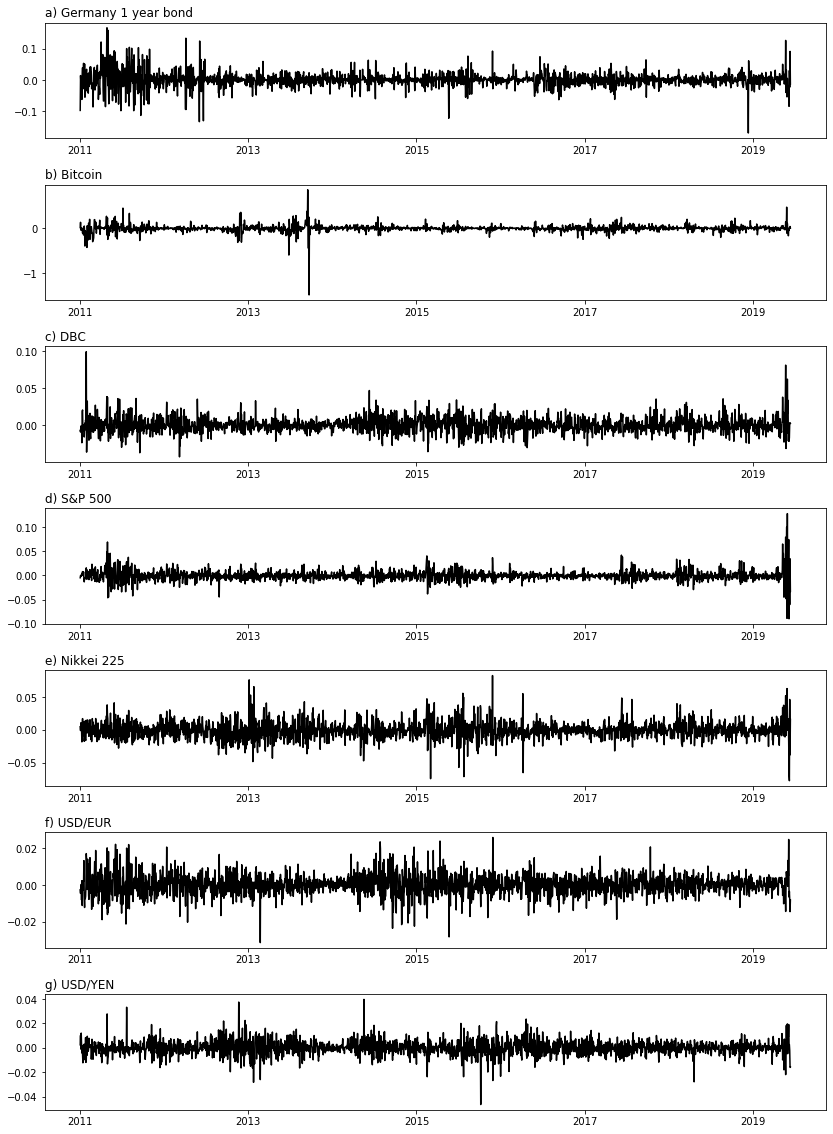

In [30]:
# plot of risk factor returns
'''I plot them as the negative of returns, so all are losses'''
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(14, 20))


# DE_1YBOND
plt.subplot(7, 1, 1)
plt.plot(-data["DE_1YBOND_return"][1:], "k")
plt.title("a) Germany 1 year bond", loc="left")
locs, labels = plt.xticks()
print(locs)
x_ticks = []
new_xticks = [dates[i] for d in locs for i in range(5)]
plt.xticks(locs[1:-1], new_xticks)
# BTC_return
plt.subplot(7, 1, 2)
plt.plot(-data["BTC_return"][1:], "k")
plt.title("b) Bitcoin", loc="left")
locs, labels = plt.xticks()
print(locs)
x_ticks = []
new_xticks = [dates[i] for d in locs for i in range(5)]
plt.xticks(locs[1:-1], new_xticks)
# DBC_return
plt.subplot(7, 1, 3)
plt.plot(-data["DBC_return"][1:], "k")
plt.title("c) DBC", loc="left")
locs, labels = plt.xticks()
print(locs)
x_ticks = []
new_xticks = [dates[i] for d in locs for i in range(5)]
plt.xticks(locs[1:-1], new_xticks)
# GSPC_return
plt.subplot(7, 1, 4)
plt.plot(-data["GSPC_return"][1:], "k")
plt.title("d) S&P 500", loc="left")
locs, labels = plt.xticks()
print(locs)
x_ticks = []
new_xticks = [dates[i] for d in locs for i in range(5)]
plt.xticks(locs[1:-1], new_xticks)
# N225_return
plt.subplot(7, 1, 5)
plt.plot(-data_new["N225_return"][1:], "k")
plt.title("e) Nikkei 225", loc="left")
locs, labels = plt.xticks()
print(locs)
x_ticks = []
new_xticks = [dates[i] for d in locs for i in range(5)]
plt.subplots_adjust(hspace=0.4)
plt.xticks(locs[1:-1], new_xticks)
# FX_EUR_return
plt.subplot(7, 1, 6)
plt.plot(-data_new["FX_EUR_return"][1:], "k")
plt.title("f) USD/EUR", loc="left")
locs, labels = plt.xticks()
print(locs)
x_ticks = []
new_xticks = [dates[i] for d in locs for i in range(5)]
plt.subplots_adjust(hspace=0.4)
plt.xticks(locs[1:-1], new_xticks)
# FX_YEN_return
plt.subplot(7, 1, 7)
plt.plot(-data_new["FX_YEN_return"][1:], "k")
plt.title("g) USD/YEN", loc="left")
locs, labels = plt.xticks()
print(locs)
x_ticks = []
new_xticks = [dates[i] for d in locs for i in range(5)]
plt.subplots_adjust(hspace=0.4)
plt.xticks(locs[1:-1], new_xticks)

In [58]:
df_prices = data[
    [
        "DE_1YBOND_return",
        "BTC_return",
        "DBC_return",
        "GSPC_return",
        "N225_return",
        "portfolio_return",
    ]
]

In [54]:
'''Statistics on risk factor and total return (log of index change)'''
df_prices.describe()

,DE_1YBOND_return,BTC_return,DBC_return,GSPC_return,N225_return,portfolio_return
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,-0.000899,0.004270,-0.000453,0.000324,0.000197,0.000688
std,0.023619,0.075414,0.010368,0.011167,0.012540,0.017119
min,-0.166000,-0.848765,-0.099117,-0.127652,-0.084939,-0.170873
25%,-0.009000,-0.015316,-0.005412,-0.003302,-0.006215,-0.005426
50%,-0.001000,0.002282,0.000000,0.000609,0.000624,0.000862
75%,0.008000,0.023551,0.005153,0.005128,0.006618,0.006948
max,0.169000,1.474395,0.042441,0.089683,0.074650,0.289329


In [56]:
df_prices.skew()

DE_1YBOND_return   -0.335791
BTC_return          2.988368
DBC_return         -0.958084
GSPC_return        -1.217644
N225_return        -0.351080
portfolio_return    1.549018
dtype: float64

In [57]:
df_prices.kurtosis()

DE_1YBOND_return     9.392130
BTC_return          82.157395
DBC_return           7.173952
GSPC_return         20.331366
N225_return          5.393050
portfolio_return    49.281785
dtype: float64

## VaR and ES

### 1. Normal Distribution

In [31]:
def fnVaR_n(dfData, weights, alpha, lookback, percent, initial_investment):
    """
    purpose:
        calculates VaR and ES with variance-covariance method
        using a normal distribution
    input:
        dfData, dataframe
        weights, weights vector
        alpha, significance value
        lookback, lookback period
        percent, True= express in percent
    output:
        VaR expressed in losses (positive value)
    """
    # check alpha
    if alpha > 0.5:
        alpha = 1 - alpha

    # express years in days
    years = lookback
    # select last n years of data
    DataTemp = dfData.iloc[-years :, :-1]  # converted to days

    # calculate mean
    mean = np.array(np.mean(DataTemp)) @ weights.T
    mean = mean[0]

    # calculate covariance
    cov = np.cov(DataTemp, rowvar=False)
    # calculate variance
    variance = weights @ cov @ weights.T
    std = np.sqrt(variance[0][0])

    # calculate quantile
    z = sc.stats.norm.ppf(alpha)
    VaR = (
        -mean + z * std
    )  # μ is negative of the return over one day, so should be negative sign
    VaR = -VaR

    mean_return = dfData["portfolio_return"][-years * 250 :]
    ES_list = [x for x in mean_return if x < -VaR]
    ES = -np.mean(ES_list)

    ##Prepare Output
    if percent[0] == True:
        print(
            "(",
            percent[1] * 100,
            "%",
            " VaR, ES) in percent is: ",
            round(VaR * 100, 2),
            "%",
            round(ES * 100, 2),
            "%",
        )
    else:

        print(
            "(",
            percent[1] * 100,
            "%",
            " VaR, ES) in monetary terms is: ",
            round(VaR * initial_investment, 2),
            round(ES * initial_investment, 2),
        )

    return VaR, ES


#### 1.1. Non-stressed Estimates

In [32]:
# Set an initial investment level
initial_investment = 1000000
lookback = 2111

df_prices = data[
    [
        "DE_1YBOND_return",
        "BTC_return",
        "DBC_return",
        "GSPC_return",
        "N225_return",
        "portfolio_return",
    ]
]
weights = np.array([[0.2, 0.2, 0.2, 0.2, 0.2]])


fnVaR_n(df_prices, weights, 0.025, lookback, [True, 0.975], initial_investment)
fnVaR_n(df_prices, weights, 0.025, lookback, [False, 0.975], initial_investment)
fnVaR_n(df_prices, weights, 0.01, lookback, [True, 0.99], initial_investment)
fnVaR_n(df_prices, weights, 0.01, lookback, [False, 0.99], initial_investment)

( 97.5 %  VaR, ES) in percent is:  3.42 % 5.63 %
( 97.5 %  VaR, ES) in monetary terms is:  34239.25 56268.41
( 99.0 %  VaR, ES) in percent is:  4.05 % 6.62 %
( 99.0 %  VaR, ES) in monetary terms is:  40511.2 66184.59


(0.040511199639070315, 0.06618458786555174)

#### 1.2 Stressed Estimates

In [33]:
for name, df in zip(df_name, df_list):
    print(name)
    fnVaR_n(df, weights, 0.025, lookback, [True, 0.975], initial_investment)
    fnVaR_n(df, weights, 0.025, lookback, [False, 0.975], initial_investment)
    fnVaR_n(df, weights, 0.01, lookback, [True, 0.99], initial_investment)
    fnVaR_n(df, weights, 0.01, lookback, [False, 0.99], initial_investment)

df_prices_plus20
( 97.5 %  VaR, ES) in percent is:  3.42 % 5.63 %
( 97.5 %  VaR, ES) in monetary terms is:  34239.25 56268.41
( 99.0 %  VaR, ES) in percent is:  4.05 % 6.62 %
( 99.0 %  VaR, ES) in monetary terms is:  40511.2 66184.59
df_prices_plus40
( 97.5 %  VaR, ES) in percent is:  3.42 % 5.63 %
( 97.5 %  VaR, ES) in monetary terms is:  34239.25 56268.41
( 99.0 %  VaR, ES) in percent is:  4.05 % 6.62 %
( 99.0 %  VaR, ES) in monetary terms is:  40511.2 66184.59
df_prices_minus20
( 97.5 %  VaR, ES) in percent is:  3.42 % 5.63 %
( 97.5 %  VaR, ES) in monetary terms is:  34239.25 56268.41
( 99.0 %  VaR, ES) in percent is:  4.05 % 6.62 %
( 99.0 %  VaR, ES) in monetary terms is:  40511.2 66184.59
df_prices_minus40
( 97.5 %  VaR, ES) in percent is:  3.42 % 5.63 %
( 97.5 %  VaR, ES) in monetary terms is:  34239.25 56268.41
( 99.0 %  VaR, ES) in percent is:  4.05 % 6.62 %
( 99.0 %  VaR, ES) in monetary terms is:  40511.2 66184.59
df_prices_complus20
( 97.5 %  VaR, ES) in percent is:  3.42 % 

### Sensitivity analysis

In [114]:
fnVaR_n(df_prices.iloc[:-150, :], weights, 0.025, 1, [True, 0.975], initial_investment)
fnVaR_n(df_prices, weights, 0.025, 1, [True, 0.975], initial_investment)

( 97.5 %  VaR, ES) in percent is:  2.09 % 3.18 %
( 97.5 %  VaR, ES) in percent is:  3.23 % 6.89 %


(0.032334018799692214, 0.06894475576288267)

<IPython.core.display.Javascript object>

In [115]:
fnVaR_n(df_prices.iloc[1:1000, :], weights, 0.025, 2, [True, 0.975], initial_investment)
fnVaR_n(df_prices[1:1000], weights, 0.025, 1, [True, 0.975], initial_investment)

( 97.5 %  VaR, ES) in percent is:  4.14 % 6.94 %
( 97.5 %  VaR, ES) in percent is:  1.84 % 3.95 %


(0.018390512896837227, 0.03949640926603217)

<IPython.core.display.Javascript object>

In [35]:
VaR_trend = []
ES_trend = []
VaR_trend_ex = []
ES_trend_ex = []
# Included corona period
for i in range(5, 2112):
    VaR_trend.append(
        fnVaR_n(df_prices, weights, 0.025, i, [True, 0.975], initial_investment)[0]
    )
    ES_trend.append(
        fnVaR_n(df_prices, weights, 0.025, i, [True, 0.975], initial_investment)[1]
    )

# exclude corona
for i in range(250):
    VaR_trend_ex.append(None)
    ES_trend_ex.append(None)
for i in range(5, 1861):
    VaR_trend_ex.append(
        fnVaR_n(df_prices[:-250], weights, 0.025, i, [True, 0.975], initial_investment)[
            0
        ]
    )
    ES_trend_ex.append(
        fnVaR_n(df_prices[:-250], weights, 0.025, i, [True, 0.975], initial_investment)[
            1
        ]
    )

( 97.5 %  VaR, ES) in percent is:  7.32 % 10.97 %
( 97.5 %  VaR, ES) in percent is:  7.32 % 10.97 %
( 97.5 %  VaR, ES) in percent is:  6.58 % 10.52 %
( 97.5 %  VaR, ES) in percent is:  6.58 % 10.52 %
( 97.5 %  VaR, ES) in percent is:  6.97 % 11.81 %
( 97.5 %  VaR, ES) in percent is:  6.97 % 11.81 %
( 97.5 %  VaR, ES) in percent is:  6.57 % 9.97 %
( 97.5 %  VaR, ES) in percent is:  6.57 % 9.97 %
( 97.5 %  VaR, ES) in percent is:  6.4 % 9.1 %
( 97.5 %  VaR, ES) in percent is:  6.4 % 9.1 %
( 97.5 %  VaR, ES) in percent is:  7.46 % 10.22 %
( 97.5 %  VaR, ES) in percent is:  7.46 % 10.22 %
( 97.5 %  VaR, ES) in percent is:  7.76 % 10.61 %
( 97.5 %  VaR, ES) in percent is:  7.76 % 10.61 %
( 97.5 %  VaR, ES) in percent is:  9.83 % 13.4 %
( 97.5 %  VaR, ES) in percent is:  9.83 % 13.4 %
( 97.5 %  VaR, ES) in percent is:  9.3 % 13.4 %
( 97.5 %  VaR, ES) in percent is:  9.3 % 13.4 %
( 97.5 %  VaR, ES) in percent is:  9.29 % 13.4 %
( 97.5 %  VaR, ES) in percent is:  9.29 % 13.4 %
( 97.5 %  VaR, E

( 97.5 %  VaR, ES) in percent is:  3.83 % 5.99 %
( 97.5 %  VaR, ES) in percent is:  3.83 % 5.99 %
( 97.5 %  VaR, ES) in percent is:  3.81 % 5.99 %
( 97.5 %  VaR, ES) in percent is:  3.81 % 5.99 %
( 97.5 %  VaR, ES) in percent is:  3.79 % 5.99 %
( 97.5 %  VaR, ES) in percent is:  3.79 % 5.99 %
( 97.5 %  VaR, ES) in percent is:  3.87 % 6.05 %
( 97.5 %  VaR, ES) in percent is:  3.87 % 6.05 %
( 97.5 %  VaR, ES) in percent is:  3.86 % 6.05 %
( 97.5 %  VaR, ES) in percent is:  3.86 % 6.05 %
( 97.5 %  VaR, ES) in percent is:  3.84 % 6.05 %
( 97.5 %  VaR, ES) in percent is:  3.84 % 6.05 %
( 97.5 %  VaR, ES) in percent is:  3.83 % 6.05 %
( 97.5 %  VaR, ES) in percent is:  3.83 % 6.05 %
( 97.5 %  VaR, ES) in percent is:  3.82 % 5.99 %
( 97.5 %  VaR, ES) in percent is:  3.82 % 5.99 %
( 97.5 %  VaR, ES) in percent is:  3.82 % 5.99 %
( 97.5 %  VaR, ES) in percent is:  3.82 % 5.99 %
( 97.5 %  VaR, ES) in percent is:  3.82 % 5.99 %
( 97.5 %  VaR, ES) in percent is:  3.82 % 5.99 %
( 97.5 %  VaR, ES) i

( 97.5 %  VaR, ES) in percent is:  3.3 % 5.44 %
( 97.5 %  VaR, ES) in percent is:  3.3 % 5.44 %
( 97.5 %  VaR, ES) in percent is:  3.3 % 5.44 %
( 97.5 %  VaR, ES) in percent is:  3.3 % 5.44 %
( 97.5 %  VaR, ES) in percent is:  3.3 % 5.44 %
( 97.5 %  VaR, ES) in percent is:  3.3 % 5.44 %
( 97.5 %  VaR, ES) in percent is:  3.29 % 5.44 %
( 97.5 %  VaR, ES) in percent is:  3.29 % 5.44 %
( 97.5 %  VaR, ES) in percent is:  3.28 % 5.44 %
( 97.5 %  VaR, ES) in percent is:  3.28 % 5.44 %
( 97.5 %  VaR, ES) in percent is:  3.28 % 5.44 %
( 97.5 %  VaR, ES) in percent is:  3.28 % 5.44 %
( 97.5 %  VaR, ES) in percent is:  3.27 % 5.44 %
( 97.5 %  VaR, ES) in percent is:  3.27 % 5.44 %
( 97.5 %  VaR, ES) in percent is:  3.27 % 5.44 %
( 97.5 %  VaR, ES) in percent is:  3.27 % 5.44 %
( 97.5 %  VaR, ES) in percent is:  3.26 % 5.44 %
( 97.5 %  VaR, ES) in percent is:  3.26 % 5.44 %
( 97.5 %  VaR, ES) in percent is:  3.25 % 5.44 %
( 97.5 %  VaR, ES) in percent is:  3.25 % 5.44 %
( 97.5 %  VaR, ES) in perc

( 97.5 %  VaR, ES) in percent is:  2.95 % 5.02 %
( 97.5 %  VaR, ES) in percent is:  2.95 % 5.02 %
( 97.5 %  VaR, ES) in percent is:  2.94 % 5.02 %
( 97.5 %  VaR, ES) in percent is:  2.94 % 5.02 %
( 97.5 %  VaR, ES) in percent is:  2.94 % 4.99 %
( 97.5 %  VaR, ES) in percent is:  2.94 % 4.99 %
( 97.5 %  VaR, ES) in percent is:  2.93 % 4.99 %
( 97.5 %  VaR, ES) in percent is:  2.93 % 4.99 %
( 97.5 %  VaR, ES) in percent is:  2.93 % 4.95 %
( 97.5 %  VaR, ES) in percent is:  2.93 % 4.95 %
( 97.5 %  VaR, ES) in percent is:  2.92 % 4.92 %
( 97.5 %  VaR, ES) in percent is:  2.92 % 4.92 %
( 97.5 %  VaR, ES) in percent is:  2.92 % 4.92 %
( 97.5 %  VaR, ES) in percent is:  2.92 % 4.92 %
( 97.5 %  VaR, ES) in percent is:  2.92 % 4.92 %
( 97.5 %  VaR, ES) in percent is:  2.92 % 4.92 %
( 97.5 %  VaR, ES) in percent is:  2.91 % 4.89 %
( 97.5 %  VaR, ES) in percent is:  2.91 % 4.89 %
( 97.5 %  VaR, ES) in percent is:  2.91 % 4.89 %
( 97.5 %  VaR, ES) in percent is:  2.91 % 4.89 %
( 97.5 %  VaR, ES) i

( 97.5 %  VaR, ES) in percent is:  2.72 % 4.55 %
( 97.5 %  VaR, ES) in percent is:  2.71 % 4.55 %
( 97.5 %  VaR, ES) in percent is:  2.71 % 4.55 %
( 97.5 %  VaR, ES) in percent is:  2.72 % 4.55 %
( 97.5 %  VaR, ES) in percent is:  2.72 % 4.55 %
( 97.5 %  VaR, ES) in percent is:  2.71 % 4.55 %
( 97.5 %  VaR, ES) in percent is:  2.71 % 4.55 %
( 97.5 %  VaR, ES) in percent is:  2.71 % 4.55 %
( 97.5 %  VaR, ES) in percent is:  2.71 % 4.55 %
( 97.5 %  VaR, ES) in percent is:  2.71 % 4.55 %
( 97.5 %  VaR, ES) in percent is:  2.71 % 4.55 %
( 97.5 %  VaR, ES) in percent is:  2.7 % 4.55 %
( 97.5 %  VaR, ES) in percent is:  2.7 % 4.55 %
( 97.5 %  VaR, ES) in percent is:  2.7 % 4.55 %
( 97.5 %  VaR, ES) in percent is:  2.7 % 4.55 %
( 97.5 %  VaR, ES) in percent is:  2.7 % 4.55 %
( 97.5 %  VaR, ES) in percent is:  2.7 % 4.55 %
( 97.5 %  VaR, ES) in percent is:  2.69 % 4.55 %
( 97.5 %  VaR, ES) in percent is:  2.69 % 4.55 %
( 97.5 %  VaR, ES) in percent is:  2.69 % 4.55 %
( 97.5 %  VaR, ES) in perc

( 97.5 %  VaR, ES) in percent is:  2.73 % 4.55 %
( 97.5 %  VaR, ES) in percent is:  2.73 % 4.55 %
( 97.5 %  VaR, ES) in percent is:  2.73 % 4.55 %
( 97.5 %  VaR, ES) in percent is:  2.72 % 4.55 %
( 97.5 %  VaR, ES) in percent is:  2.72 % 4.55 %
( 97.5 %  VaR, ES) in percent is:  2.72 % 4.55 %
( 97.5 %  VaR, ES) in percent is:  2.72 % 4.55 %
( 97.5 %  VaR, ES) in percent is:  2.74 % 4.55 %
( 97.5 %  VaR, ES) in percent is:  2.74 % 4.55 %
( 97.5 %  VaR, ES) in percent is:  2.74 % 4.55 %
( 97.5 %  VaR, ES) in percent is:  2.74 % 4.55 %
( 97.5 %  VaR, ES) in percent is:  2.73 % 4.55 %
( 97.5 %  VaR, ES) in percent is:  2.73 % 4.55 %
( 97.5 %  VaR, ES) in percent is:  2.73 % 4.55 %
( 97.5 %  VaR, ES) in percent is:  2.73 % 4.55 %
( 97.5 %  VaR, ES) in percent is:  2.73 % 4.55 %
( 97.5 %  VaR, ES) in percent is:  2.73 % 4.55 %
( 97.5 %  VaR, ES) in percent is:  2.73 % 4.55 %
( 97.5 %  VaR, ES) in percent is:  2.73 % 4.55 %
( 97.5 %  VaR, ES) in percent is:  2.73 % 4.55 %
( 97.5 %  VaR, ES) i

( 97.5 %  VaR, ES) in percent is:  2.8 % 4.6 %
( 97.5 %  VaR, ES) in percent is:  2.8 % 4.6 %
( 97.5 %  VaR, ES) in percent is:  2.79 % 4.6 %
( 97.5 %  VaR, ES) in percent is:  2.79 % 4.6 %
( 97.5 %  VaR, ES) in percent is:  2.79 % 4.6 %
( 97.5 %  VaR, ES) in percent is:  2.79 % 4.6 %
( 97.5 %  VaR, ES) in percent is:  2.79 % 4.6 %
( 97.5 %  VaR, ES) in percent is:  2.79 % 4.6 %
( 97.5 %  VaR, ES) in percent is:  2.8 % 4.6 %
( 97.5 %  VaR, ES) in percent is:  2.8 % 4.6 %
( 97.5 %  VaR, ES) in percent is:  2.79 % 4.6 %
( 97.5 %  VaR, ES) in percent is:  2.79 % 4.6 %
( 97.5 %  VaR, ES) in percent is:  2.79 % 4.6 %
( 97.5 %  VaR, ES) in percent is:  2.79 % 4.6 %
( 97.5 %  VaR, ES) in percent is:  2.79 % 4.6 %
( 97.5 %  VaR, ES) in percent is:  2.79 % 4.6 %
( 97.5 %  VaR, ES) in percent is:  2.79 % 4.6 %
( 97.5 %  VaR, ES) in percent is:  2.79 % 4.6 %
( 97.5 %  VaR, ES) in percent is:  2.81 % 4.62 %
( 97.5 %  VaR, ES) in percent is:  2.81 % 4.62 %
( 97.5 %  VaR, ES) in percent is:  2.81 % 

( 97.5 %  VaR, ES) in percent is:  2.77 % 4.57 %
( 97.5 %  VaR, ES) in percent is:  2.77 % 4.57 %
( 97.5 %  VaR, ES) in percent is:  2.77 % 4.57 %
( 97.5 %  VaR, ES) in percent is:  2.77 % 4.57 %
( 97.5 %  VaR, ES) in percent is:  2.77 % 4.57 %
( 97.5 %  VaR, ES) in percent is:  2.77 % 4.57 %
( 97.5 %  VaR, ES) in percent is:  2.77 % 4.57 %
( 97.5 %  VaR, ES) in percent is:  2.77 % 4.57 %
( 97.5 %  VaR, ES) in percent is:  2.77 % 4.57 %
( 97.5 %  VaR, ES) in percent is:  2.77 % 4.57 %
( 97.5 %  VaR, ES) in percent is:  2.77 % 4.57 %
( 97.5 %  VaR, ES) in percent is:  2.77 % 4.57 %
( 97.5 %  VaR, ES) in percent is:  2.77 % 4.57 %
( 97.5 %  VaR, ES) in percent is:  2.77 % 4.57 %
( 97.5 %  VaR, ES) in percent is:  2.77 % 4.57 %
( 97.5 %  VaR, ES) in percent is:  2.76 % 4.55 %
( 97.5 %  VaR, ES) in percent is:  2.76 % 4.55 %
( 97.5 %  VaR, ES) in percent is:  2.76 % 4.55 %
( 97.5 %  VaR, ES) in percent is:  2.76 % 4.55 %
( 97.5 %  VaR, ES) in percent is:  2.76 % 4.55 %
( 97.5 %  VaR, ES) i

( 97.5 %  VaR, ES) in percent is:  2.69 % 4.55 %
( 97.5 %  VaR, ES) in percent is:  2.69 % 4.55 %
( 97.5 %  VaR, ES) in percent is:  2.69 % 4.55 %
( 97.5 %  VaR, ES) in percent is:  2.69 % 4.55 %
( 97.5 %  VaR, ES) in percent is:  2.69 % 4.55 %
( 97.5 %  VaR, ES) in percent is:  2.68 % 4.55 %
( 97.5 %  VaR, ES) in percent is:  2.68 % 4.55 %
( 97.5 %  VaR, ES) in percent is:  2.68 % 4.55 %
( 97.5 %  VaR, ES) in percent is:  2.68 % 4.55 %
( 97.5 %  VaR, ES) in percent is:  2.68 % 4.55 %
( 97.5 %  VaR, ES) in percent is:  2.68 % 4.55 %
( 97.5 %  VaR, ES) in percent is:  2.68 % 4.55 %
( 97.5 %  VaR, ES) in percent is:  2.68 % 4.55 %
( 97.5 %  VaR, ES) in percent is:  2.68 % 4.55 %
( 97.5 %  VaR, ES) in percent is:  2.68 % 4.55 %
( 97.5 %  VaR, ES) in percent is:  2.68 % 4.55 %
( 97.5 %  VaR, ES) in percent is:  2.68 % 4.55 %
( 97.5 %  VaR, ES) in percent is:  2.67 % 4.55 %
( 97.5 %  VaR, ES) in percent is:  2.67 % 4.55 %
( 97.5 %  VaR, ES) in percent is:  2.67 % 4.55 %
( 97.5 %  VaR, ES) i

( 97.5 %  VaR, ES) in percent is:  2.61 % 4.52 %
( 97.5 %  VaR, ES) in percent is:  2.61 % 4.52 %
( 97.5 %  VaR, ES) in percent is:  2.61 % 4.52 %
( 97.5 %  VaR, ES) in percent is:  2.61 % 4.52 %
( 97.5 %  VaR, ES) in percent is:  2.6 % 4.52 %
( 97.5 %  VaR, ES) in percent is:  2.6 % 4.52 %
( 97.5 %  VaR, ES) in percent is:  2.6 % 4.52 %
( 97.5 %  VaR, ES) in percent is:  2.6 % 4.52 %
( 97.5 %  VaR, ES) in percent is:  2.6 % 4.52 %
( 97.5 %  VaR, ES) in percent is:  2.6 % 4.52 %
( 97.5 %  VaR, ES) in percent is:  2.6 % 4.52 %
( 97.5 %  VaR, ES) in percent is:  2.6 % 4.52 %
( 97.5 %  VaR, ES) in percent is:  2.6 % 4.52 %
( 97.5 %  VaR, ES) in percent is:  2.6 % 4.52 %
( 97.5 %  VaR, ES) in percent is:  2.6 % 4.52 %
( 97.5 %  VaR, ES) in percent is:  2.6 % 4.52 %
( 97.5 %  VaR, ES) in percent is:  2.6 % 4.52 %
( 97.5 %  VaR, ES) in percent is:  2.6 % 4.52 %
( 97.5 %  VaR, ES) in percent is:  2.6 % 4.52 %
( 97.5 %  VaR, ES) in percent is:  2.6 % 4.52 %
( 97.5 %  VaR, ES) in percent is:  2

( 97.5 %  VaR, ES) in percent is:  2.53 % 4.39 %
( 97.5 %  VaR, ES) in percent is:  2.53 % 4.39 %
( 97.5 %  VaR, ES) in percent is:  2.53 % 4.39 %
( 97.5 %  VaR, ES) in percent is:  2.53 % 4.39 %
( 97.5 %  VaR, ES) in percent is:  2.53 % 4.39 %
( 97.5 %  VaR, ES) in percent is:  2.53 % 4.39 %
( 97.5 %  VaR, ES) in percent is:  2.53 % 4.39 %
( 97.5 %  VaR, ES) in percent is:  2.53 % 4.39 %
( 97.5 %  VaR, ES) in percent is:  2.53 % 4.39 %
( 97.5 %  VaR, ES) in percent is:  2.53 % 4.39 %
( 97.5 %  VaR, ES) in percent is:  2.53 % 4.39 %
( 97.5 %  VaR, ES) in percent is:  2.53 % 4.39 %
( 97.5 %  VaR, ES) in percent is:  2.53 % 4.39 %
( 97.5 %  VaR, ES) in percent is:  2.53 % 4.39 %
( 97.5 %  VaR, ES) in percent is:  2.53 % 4.39 %
( 97.5 %  VaR, ES) in percent is:  2.52 % 4.39 %
( 97.5 %  VaR, ES) in percent is:  2.52 % 4.39 %
( 97.5 %  VaR, ES) in percent is:  2.52 % 4.39 %
( 97.5 %  VaR, ES) in percent is:  2.52 % 4.39 %
( 97.5 %  VaR, ES) in percent is:  2.52 % 4.39 %
( 97.5 %  VaR, ES) i

( 97.5 %  VaR, ES) in percent is:  2.49 % 4.39 %
( 97.5 %  VaR, ES) in percent is:  2.49 % 4.39 %
( 97.5 %  VaR, ES) in percent is:  2.49 % 4.39 %
( 97.5 %  VaR, ES) in percent is:  2.49 % 4.39 %
( 97.5 %  VaR, ES) in percent is:  2.49 % 4.39 %
( 97.5 %  VaR, ES) in percent is:  2.49 % 4.39 %
( 97.5 %  VaR, ES) in percent is:  2.49 % 4.39 %
( 97.5 %  VaR, ES) in percent is:  2.49 % 4.39 %
( 97.5 %  VaR, ES) in percent is:  2.49 % 4.39 %
( 97.5 %  VaR, ES) in percent is:  2.49 % 4.39 %
( 97.5 %  VaR, ES) in percent is:  2.49 % 4.39 %
( 97.5 %  VaR, ES) in percent is:  2.49 % 4.39 %
( 97.5 %  VaR, ES) in percent is:  2.49 % 4.39 %
( 97.5 %  VaR, ES) in percent is:  2.49 % 4.39 %
( 97.5 %  VaR, ES) in percent is:  2.49 % 4.39 %
( 97.5 %  VaR, ES) in percent is:  2.49 % 4.39 %
( 97.5 %  VaR, ES) in percent is:  2.49 % 4.39 %
( 97.5 %  VaR, ES) in percent is:  2.49 % 4.39 %
( 97.5 %  VaR, ES) in percent is:  2.48 % 4.39 %
( 97.5 %  VaR, ES) in percent is:  2.48 % 4.39 %
( 97.5 %  VaR, ES) i

( 97.5 %  VaR, ES) in percent is:  2.43 % 4.36 %
( 97.5 %  VaR, ES) in percent is:  2.43 % 4.36 %
( 97.5 %  VaR, ES) in percent is:  2.42 % 4.36 %
( 97.5 %  VaR, ES) in percent is:  2.42 % 4.36 %
( 97.5 %  VaR, ES) in percent is:  2.42 % 4.36 %
( 97.5 %  VaR, ES) in percent is:  2.42 % 4.36 %
( 97.5 %  VaR, ES) in percent is:  2.42 % 4.36 %
( 97.5 %  VaR, ES) in percent is:  2.42 % 4.36 %
( 97.5 %  VaR, ES) in percent is:  2.42 % 4.36 %
( 97.5 %  VaR, ES) in percent is:  2.42 % 4.36 %
( 97.5 %  VaR, ES) in percent is:  2.42 % 4.36 %
( 97.5 %  VaR, ES) in percent is:  2.42 % 4.36 %
( 97.5 %  VaR, ES) in percent is:  2.42 % 4.36 %
( 97.5 %  VaR, ES) in percent is:  2.42 % 4.36 %
( 97.5 %  VaR, ES) in percent is:  2.42 % 4.36 %
( 97.5 %  VaR, ES) in percent is:  2.42 % 4.36 %
( 97.5 %  VaR, ES) in percent is:  2.42 % 4.36 %
( 97.5 %  VaR, ES) in percent is:  2.42 % 4.36 %
( 97.5 %  VaR, ES) in percent is:  2.42 % 4.36 %
( 97.5 %  VaR, ES) in percent is:  2.42 % 4.36 %
( 97.5 %  VaR, ES) i

( 97.5 %  VaR, ES) in percent is:  2.42 % 4.36 %
( 97.5 %  VaR, ES) in percent is:  2.42 % 4.36 %
( 97.5 %  VaR, ES) in percent is:  2.42 % 4.36 %
( 97.5 %  VaR, ES) in percent is:  2.42 % 4.36 %
( 97.5 %  VaR, ES) in percent is:  2.42 % 4.36 %
( 97.5 %  VaR, ES) in percent is:  2.42 % 4.36 %
( 97.5 %  VaR, ES) in percent is:  2.42 % 4.36 %
( 97.5 %  VaR, ES) in percent is:  2.42 % 4.36 %
( 97.5 %  VaR, ES) in percent is:  2.42 % 4.36 %
( 97.5 %  VaR, ES) in percent is:  2.42 % 4.36 %
( 97.5 %  VaR, ES) in percent is:  2.42 % 4.36 %
( 97.5 %  VaR, ES) in percent is:  2.42 % 4.36 %
( 97.5 %  VaR, ES) in percent is:  2.42 % 4.36 %
( 97.5 %  VaR, ES) in percent is:  2.42 % 4.36 %
( 97.5 %  VaR, ES) in percent is:  2.42 % 4.36 %
( 97.5 %  VaR, ES) in percent is:  2.42 % 4.36 %
( 97.5 %  VaR, ES) in percent is:  2.42 % 4.36 %
( 97.5 %  VaR, ES) in percent is:  2.42 % 4.36 %
( 97.5 %  VaR, ES) in percent is:  2.42 % 4.36 %
( 97.5 %  VaR, ES) in percent is:  2.42 % 4.36 %
( 97.5 %  VaR, ES) i

( 97.5 %  VaR, ES) in percent is:  2.38 % 4.32 %
( 97.5 %  VaR, ES) in percent is:  2.38 % 4.32 %
( 97.5 %  VaR, ES) in percent is:  2.38 % 4.32 %
( 97.5 %  VaR, ES) in percent is:  2.38 % 4.32 %
( 97.5 %  VaR, ES) in percent is:  2.38 % 4.32 %
( 97.5 %  VaR, ES) in percent is:  2.38 % 4.32 %
( 97.5 %  VaR, ES) in percent is:  2.38 % 4.32 %
( 97.5 %  VaR, ES) in percent is:  2.38 % 4.32 %
( 97.5 %  VaR, ES) in percent is:  2.38 % 4.32 %
( 97.5 %  VaR, ES) in percent is:  2.38 % 4.32 %
( 97.5 %  VaR, ES) in percent is:  2.38 % 4.32 %
( 97.5 %  VaR, ES) in percent is:  2.38 % 4.32 %
( 97.5 %  VaR, ES) in percent is:  2.38 % 4.32 %
( 97.5 %  VaR, ES) in percent is:  2.38 % 4.32 %
( 97.5 %  VaR, ES) in percent is:  2.38 % 4.32 %
( 97.5 %  VaR, ES) in percent is:  2.38 % 4.32 %
( 97.5 %  VaR, ES) in percent is:  2.38 % 4.32 %
( 97.5 %  VaR, ES) in percent is:  2.38 % 4.32 %
( 97.5 %  VaR, ES) in percent is:  2.38 % 4.32 %
( 97.5 %  VaR, ES) in percent is:  2.39 % 4.32 %
( 97.5 %  VaR, ES) i

( 97.5 %  VaR, ES) in percent is:  3.15 % 5.36 %
( 97.5 %  VaR, ES) in percent is:  3.15 % 5.36 %
( 97.5 %  VaR, ES) in percent is:  3.15 % 5.36 %
( 97.5 %  VaR, ES) in percent is:  3.15 % 5.36 %
( 97.5 %  VaR, ES) in percent is:  3.15 % 5.36 %
( 97.5 %  VaR, ES) in percent is:  3.15 % 5.36 %
( 97.5 %  VaR, ES) in percent is:  3.15 % 5.36 %
( 97.5 %  VaR, ES) in percent is:  3.15 % 5.36 %
( 97.5 %  VaR, ES) in percent is:  3.15 % 5.36 %
( 97.5 %  VaR, ES) in percent is:  3.15 % 5.36 %
( 97.5 %  VaR, ES) in percent is:  3.15 % 5.36 %
( 97.5 %  VaR, ES) in percent is:  3.15 % 5.36 %
( 97.5 %  VaR, ES) in percent is:  3.15 % 5.36 %
( 97.5 %  VaR, ES) in percent is:  3.15 % 5.36 %
( 97.5 %  VaR, ES) in percent is:  3.15 % 5.36 %
( 97.5 %  VaR, ES) in percent is:  3.15 % 5.36 %
( 97.5 %  VaR, ES) in percent is:  3.15 % 5.36 %
( 97.5 %  VaR, ES) in percent is:  3.15 % 5.36 %
( 97.5 %  VaR, ES) in percent is:  3.15 % 5.36 %
( 97.5 %  VaR, ES) in percent is:  3.15 % 5.36 %
( 97.5 %  VaR, ES) i

( 97.5 %  VaR, ES) in percent is:  3.12 % 5.27 %
( 97.5 %  VaR, ES) in percent is:  3.12 % 5.27 %
( 97.5 %  VaR, ES) in percent is:  3.12 % 5.27 %
( 97.5 %  VaR, ES) in percent is:  3.11 % 5.27 %
( 97.5 %  VaR, ES) in percent is:  3.11 % 5.27 %
( 97.5 %  VaR, ES) in percent is:  3.11 % 5.27 %
( 97.5 %  VaR, ES) in percent is:  3.11 % 5.27 %
( 97.5 %  VaR, ES) in percent is:  3.11 % 5.27 %
( 97.5 %  VaR, ES) in percent is:  3.11 % 5.27 %
( 97.5 %  VaR, ES) in percent is:  3.11 % 5.27 %
( 97.5 %  VaR, ES) in percent is:  3.11 % 5.27 %
( 97.5 %  VaR, ES) in percent is:  3.11 % 5.27 %
( 97.5 %  VaR, ES) in percent is:  3.11 % 5.27 %
( 97.5 %  VaR, ES) in percent is:  3.11 % 5.27 %
( 97.5 %  VaR, ES) in percent is:  3.11 % 5.27 %
( 97.5 %  VaR, ES) in percent is:  3.11 % 5.27 %
( 97.5 %  VaR, ES) in percent is:  3.11 % 5.27 %
( 97.5 %  VaR, ES) in percent is:  3.11 % 5.27 %
( 97.5 %  VaR, ES) in percent is:  3.11 % 5.27 %
( 97.5 %  VaR, ES) in percent is:  3.11 % 5.27 %
( 97.5 %  VaR, ES) i

( 97.5 %  VaR, ES) in percent is:  3.21 % 5.44 %
( 97.5 %  VaR, ES) in percent is:  3.21 % 5.44 %
( 97.5 %  VaR, ES) in percent is:  3.21 % 5.44 %
( 97.5 %  VaR, ES) in percent is:  3.21 % 5.44 %
( 97.5 %  VaR, ES) in percent is:  3.21 % 5.44 %
( 97.5 %  VaR, ES) in percent is:  3.21 % 5.44 %
( 97.5 %  VaR, ES) in percent is:  3.21 % 5.44 %
( 97.5 %  VaR, ES) in percent is:  3.21 % 5.44 %
( 97.5 %  VaR, ES) in percent is:  3.21 % 5.44 %
( 97.5 %  VaR, ES) in percent is:  3.21 % 5.44 %
( 97.5 %  VaR, ES) in percent is:  3.21 % 5.44 %
( 97.5 %  VaR, ES) in percent is:  3.21 % 5.44 %
( 97.5 %  VaR, ES) in percent is:  3.2 % 5.44 %
( 97.5 %  VaR, ES) in percent is:  3.2 % 5.44 %
( 97.5 %  VaR, ES) in percent is:  3.21 % 5.44 %
( 97.5 %  VaR, ES) in percent is:  3.21 % 5.44 %
( 97.5 %  VaR, ES) in percent is:  3.21 % 5.44 %
( 97.5 %  VaR, ES) in percent is:  3.21 % 5.44 %
( 97.5 %  VaR, ES) in percent is:  3.21 % 5.44 %
( 97.5 %  VaR, ES) in percent is:  3.21 % 5.44 %
( 97.5 %  VaR, ES) in 

( 97.5 %  VaR, ES) in percent is:  3.16 % 5.36 %
( 97.5 %  VaR, ES) in percent is:  3.16 % 5.36 %
( 97.5 %  VaR, ES) in percent is:  3.16 % 5.36 %
( 97.5 %  VaR, ES) in percent is:  3.16 % 5.36 %
( 97.5 %  VaR, ES) in percent is:  3.16 % 5.36 %
( 97.5 %  VaR, ES) in percent is:  3.16 % 5.36 %
( 97.5 %  VaR, ES) in percent is:  3.16 % 5.36 %
( 97.5 %  VaR, ES) in percent is:  3.16 % 5.36 %
( 97.5 %  VaR, ES) in percent is:  3.16 % 5.36 %
( 97.5 %  VaR, ES) in percent is:  3.16 % 5.36 %
( 97.5 %  VaR, ES) in percent is:  3.16 % 5.36 %
( 97.5 %  VaR, ES) in percent is:  3.16 % 5.36 %
( 97.5 %  VaR, ES) in percent is:  3.16 % 5.36 %
( 97.5 %  VaR, ES) in percent is:  3.16 % 5.36 %
( 97.5 %  VaR, ES) in percent is:  3.16 % 5.36 %
( 97.5 %  VaR, ES) in percent is:  3.16 % 5.36 %
( 97.5 %  VaR, ES) in percent is:  3.16 % 5.36 %
( 97.5 %  VaR, ES) in percent is:  3.16 % 5.36 %
( 97.5 %  VaR, ES) in percent is:  3.16 % 5.36 %
( 97.5 %  VaR, ES) in percent is:  3.16 % 5.36 %
( 97.5 %  VaR, ES) i

( 97.5 %  VaR, ES) in percent is:  3.11 % 5.27 %
( 97.5 %  VaR, ES) in percent is:  3.11 % 5.27 %
( 97.5 %  VaR, ES) in percent is:  3.11 % 5.27 %
( 97.5 %  VaR, ES) in percent is:  3.11 % 5.27 %
( 97.5 %  VaR, ES) in percent is:  3.11 % 5.27 %
( 97.5 %  VaR, ES) in percent is:  3.11 % 5.27 %
( 97.5 %  VaR, ES) in percent is:  3.11 % 5.27 %
( 97.5 %  VaR, ES) in percent is:  3.11 % 5.27 %
( 97.5 %  VaR, ES) in percent is:  3.11 % 5.27 %
( 97.5 %  VaR, ES) in percent is:  3.11 % 5.27 %
( 97.5 %  VaR, ES) in percent is:  3.11 % 5.27 %
( 97.5 %  VaR, ES) in percent is:  3.11 % 5.27 %
( 97.5 %  VaR, ES) in percent is:  3.11 % 5.27 %
( 97.5 %  VaR, ES) in percent is:  3.11 % 5.27 %
( 97.5 %  VaR, ES) in percent is:  3.11 % 5.27 %
( 97.5 %  VaR, ES) in percent is:  3.11 % 5.27 %
( 97.5 %  VaR, ES) in percent is:  3.11 % 5.27 %
( 97.5 %  VaR, ES) in percent is:  3.11 % 5.27 %
( 97.5 %  VaR, ES) in percent is:  3.11 % 5.27 %
( 97.5 %  VaR, ES) in percent is:  3.11 % 5.27 %
( 97.5 %  VaR, ES) i

( 97.5 %  VaR, ES) in percent is:  3.19 % 5.44 %
( 97.5 %  VaR, ES) in percent is:  3.19 % 5.44 %
( 97.5 %  VaR, ES) in percent is:  3.19 % 5.44 %
( 97.5 %  VaR, ES) in percent is:  3.19 % 5.44 %
( 97.5 %  VaR, ES) in percent is:  3.19 % 5.44 %
( 97.5 %  VaR, ES) in percent is:  3.19 % 5.44 %
( 97.5 %  VaR, ES) in percent is:  3.19 % 5.44 %
( 97.5 %  VaR, ES) in percent is:  3.19 % 5.44 %
( 97.5 %  VaR, ES) in percent is:  3.19 % 5.44 %
( 97.5 %  VaR, ES) in percent is:  3.19 % 5.44 %
( 97.5 %  VaR, ES) in percent is:  3.19 % 5.44 %
( 97.5 %  VaR, ES) in percent is:  3.19 % 5.44 %
( 97.5 %  VaR, ES) in percent is:  3.19 % 5.44 %
( 97.5 %  VaR, ES) in percent is:  3.19 % 5.44 %
( 97.5 %  VaR, ES) in percent is:  3.19 % 5.44 %
( 97.5 %  VaR, ES) in percent is:  3.19 % 5.44 %
( 97.5 %  VaR, ES) in percent is:  3.19 % 5.44 %
( 97.5 %  VaR, ES) in percent is:  3.19 % 5.44 %
( 97.5 %  VaR, ES) in percent is:  3.19 % 5.44 %
( 97.5 %  VaR, ES) in percent is:  3.19 % 5.4 %
( 97.5 %  VaR, ES) in

( 97.5 %  VaR, ES) in percent is:  3.34 % 5.53 %
( 97.5 %  VaR, ES) in percent is:  3.34 % 5.53 %
( 97.5 %  VaR, ES) in percent is:  3.34 % 5.53 %
( 97.5 %  VaR, ES) in percent is:  3.37 % 5.58 %
( 97.5 %  VaR, ES) in percent is:  3.37 % 5.58 %
( 97.5 %  VaR, ES) in percent is:  3.37 % 5.58 %
( 97.5 %  VaR, ES) in percent is:  3.37 % 5.58 %
( 97.5 %  VaR, ES) in percent is:  3.37 % 5.58 %
( 97.5 %  VaR, ES) in percent is:  3.37 % 5.58 %
( 97.5 %  VaR, ES) in percent is:  3.39 % 5.58 %
( 97.5 %  VaR, ES) in percent is:  3.39 % 5.58 %
( 97.5 %  VaR, ES) in percent is:  3.39 % 5.58 %
( 97.5 %  VaR, ES) in percent is:  3.39 % 5.58 %
( 97.5 %  VaR, ES) in percent is:  3.4 % 5.63 %
( 97.5 %  VaR, ES) in percent is:  3.4 % 5.63 %
( 97.5 %  VaR, ES) in percent is:  3.42 % 5.63 %
( 97.5 %  VaR, ES) in percent is:  3.42 % 5.63 %
( 97.5 %  VaR, ES) in percent is:  3.42 % 5.63 %
( 97.5 %  VaR, ES) in percent is:  3.42 % 5.63 %
( 97.5 %  VaR, ES) in percent is:  3.42 % 5.63 %
( 97.5 %  VaR, ES) in 

( 97.5 %  VaR, ES) in percent is:  2.16 % 3.98 %
( 97.5 %  VaR, ES) in percent is:  2.16 % 3.98 %
( 97.5 %  VaR, ES) in percent is:  2.16 % 3.98 %
( 97.5 %  VaR, ES) in percent is:  2.15 % 3.96 %
( 97.5 %  VaR, ES) in percent is:  2.15 % 3.96 %
( 97.5 %  VaR, ES) in percent is:  2.14 % 3.96 %
( 97.5 %  VaR, ES) in percent is:  2.14 % 3.96 %
( 97.5 %  VaR, ES) in percent is:  2.14 % 3.96 %
( 97.5 %  VaR, ES) in percent is:  2.14 % 3.96 %
( 97.5 %  VaR, ES) in percent is:  2.12 % 3.96 %
( 97.5 %  VaR, ES) in percent is:  2.12 % 3.96 %
( 97.5 %  VaR, ES) in percent is:  2.1 % 3.96 %
( 97.5 %  VaR, ES) in percent is:  2.1 % 3.96 %
( 97.5 %  VaR, ES) in percent is:  2.09 % 3.92 %
( 97.5 %  VaR, ES) in percent is:  2.09 % 3.92 %
( 97.5 %  VaR, ES) in percent is:  2.07 % 3.9 %
( 97.5 %  VaR, ES) in percent is:  2.07 % 3.9 %
( 97.5 %  VaR, ES) in percent is:  2.06 % 3.84 %
( 97.5 %  VaR, ES) in percent is:  2.06 % 3.84 %
( 97.5 %  VaR, ES) in percent is:  2.04 % 3.84 %
( 97.5 %  VaR, ES) in pe

( 97.5 %  VaR, ES) in percent is:  1.84 % 3.43 %
( 97.5 %  VaR, ES) in percent is:  1.83 % 3.43 %
( 97.5 %  VaR, ES) in percent is:  1.83 % 3.43 %
( 97.5 %  VaR, ES) in percent is:  1.83 % 3.41 %
( 97.5 %  VaR, ES) in percent is:  1.83 % 3.41 %
( 97.5 %  VaR, ES) in percent is:  1.82 % 3.39 %
( 97.5 %  VaR, ES) in percent is:  1.82 % 3.39 %
( 97.5 %  VaR, ES) in percent is:  1.83 % 3.41 %
( 97.5 %  VaR, ES) in percent is:  1.83 % 3.41 %
( 97.5 %  VaR, ES) in percent is:  1.82 % 3.39 %
( 97.5 %  VaR, ES) in percent is:  1.82 % 3.39 %
( 97.5 %  VaR, ES) in percent is:  1.82 % 3.39 %
( 97.5 %  VaR, ES) in percent is:  1.82 % 3.39 %
( 97.5 %  VaR, ES) in percent is:  1.81 % 3.38 %
( 97.5 %  VaR, ES) in percent is:  1.81 % 3.38 %
( 97.5 %  VaR, ES) in percent is:  1.81 % 3.37 %
( 97.5 %  VaR, ES) in percent is:  1.81 % 3.37 %
( 97.5 %  VaR, ES) in percent is:  1.81 % 3.37 %
( 97.5 %  VaR, ES) in percent is:  1.81 % 3.37 %
( 97.5 %  VaR, ES) in percent is:  1.8 % 3.36 %
( 97.5 %  VaR, ES) in

( 97.5 %  VaR, ES) in percent is:  1.93 % 3.59 %
( 97.5 %  VaR, ES) in percent is:  1.93 % 3.59 %
( 97.5 %  VaR, ES) in percent is:  1.94 % 3.59 %
( 97.5 %  VaR, ES) in percent is:  1.94 % 3.59 %
( 97.5 %  VaR, ES) in percent is:  1.93 % 3.59 %
( 97.5 %  VaR, ES) in percent is:  1.93 % 3.59 %
( 97.5 %  VaR, ES) in percent is:  1.94 % 3.6 %
( 97.5 %  VaR, ES) in percent is:  1.94 % 3.6 %
( 97.5 %  VaR, ES) in percent is:  2.07 % 3.9 %
( 97.5 %  VaR, ES) in percent is:  2.07 % 3.9 %
( 97.5 %  VaR, ES) in percent is:  2.07 % 3.9 %
( 97.5 %  VaR, ES) in percent is:  2.07 % 3.9 %
( 97.5 %  VaR, ES) in percent is:  2.07 % 3.9 %
( 97.5 %  VaR, ES) in percent is:  2.07 % 3.9 %
( 97.5 %  VaR, ES) in percent is:  2.07 % 3.9 %
( 97.5 %  VaR, ES) in percent is:  2.07 % 3.9 %
( 97.5 %  VaR, ES) in percent is:  2.08 % 3.9 %
( 97.5 %  VaR, ES) in percent is:  2.08 % 3.9 %
( 97.5 %  VaR, ES) in percent is:  2.08 % 3.9 %
( 97.5 %  VaR, ES) in percent is:  2.08 % 3.9 %
( 97.5 %  VaR, ES) in percent is: 

( 97.5 %  VaR, ES) in percent is:  2.4 % 4.22 %
( 97.5 %  VaR, ES) in percent is:  2.4 % 4.22 %
( 97.5 %  VaR, ES) in percent is:  2.4 % 4.22 %
( 97.5 %  VaR, ES) in percent is:  2.4 % 4.22 %
( 97.5 %  VaR, ES) in percent is:  2.41 % 4.22 %
( 97.5 %  VaR, ES) in percent is:  2.41 % 4.22 %
( 97.5 %  VaR, ES) in percent is:  2.4 % 4.22 %
( 97.5 %  VaR, ES) in percent is:  2.4 % 4.22 %
( 97.5 %  VaR, ES) in percent is:  2.4 % 4.22 %
( 97.5 %  VaR, ES) in percent is:  2.4 % 4.22 %
( 97.5 %  VaR, ES) in percent is:  2.4 % 4.22 %
( 97.5 %  VaR, ES) in percent is:  2.4 % 4.22 %
( 97.5 %  VaR, ES) in percent is:  2.4 % 4.2 %
( 97.5 %  VaR, ES) in percent is:  2.4 % 4.2 %
( 97.5 %  VaR, ES) in percent is:  2.39 % 4.2 %
( 97.5 %  VaR, ES) in percent is:  2.39 % 4.2 %
( 97.5 %  VaR, ES) in percent is:  2.39 % 4.2 %
( 97.5 %  VaR, ES) in percent is:  2.39 % 4.2 %
( 97.5 %  VaR, ES) in percent is:  2.39 % 4.2 %
( 97.5 %  VaR, ES) in percent is:  2.39 % 4.2 %
( 97.5 %  VaR, ES) in percent is:  2.39 

( 97.5 %  VaR, ES) in percent is:  2.5 % 4.27 %
( 97.5 %  VaR, ES) in percent is:  2.5 % 4.27 %
( 97.5 %  VaR, ES) in percent is:  2.5 % 4.27 %
( 97.5 %  VaR, ES) in percent is:  2.5 % 4.27 %
( 97.5 %  VaR, ES) in percent is:  2.5 % 4.27 %
( 97.5 %  VaR, ES) in percent is:  2.5 % 4.27 %
( 97.5 %  VaR, ES) in percent is:  2.5 % 4.27 %
( 97.5 %  VaR, ES) in percent is:  2.5 % 4.27 %
( 97.5 %  VaR, ES) in percent is:  2.5 % 4.27 %
( 97.5 %  VaR, ES) in percent is:  2.5 % 4.27 %
( 97.5 %  VaR, ES) in percent is:  2.5 % 4.27 %
( 97.5 %  VaR, ES) in percent is:  2.49 % 4.27 %
( 97.5 %  VaR, ES) in percent is:  2.49 % 4.27 %
( 97.5 %  VaR, ES) in percent is:  2.49 % 4.27 %
( 97.5 %  VaR, ES) in percent is:  2.49 % 4.27 %
( 97.5 %  VaR, ES) in percent is:  2.49 % 4.27 %
( 97.5 %  VaR, ES) in percent is:  2.49 % 4.27 %
( 97.5 %  VaR, ES) in percent is:  2.48 % 4.27 %
( 97.5 %  VaR, ES) in percent is:  2.48 % 4.27 %
( 97.5 %  VaR, ES) in percent is:  2.48 % 4.27 %
( 97.5 %  VaR, ES) in percent i

( 97.5 %  VaR, ES) in percent is:  2.43 % 4.24 %
( 97.5 %  VaR, ES) in percent is:  2.43 % 4.24 %
( 97.5 %  VaR, ES) in percent is:  2.42 % 4.24 %
( 97.5 %  VaR, ES) in percent is:  2.42 % 4.24 %
( 97.5 %  VaR, ES) in percent is:  2.42 % 4.24 %
( 97.5 %  VaR, ES) in percent is:  2.42 % 4.24 %
( 97.5 %  VaR, ES) in percent is:  2.42 % 4.24 %
( 97.5 %  VaR, ES) in percent is:  2.42 % 4.24 %
( 97.5 %  VaR, ES) in percent is:  2.42 % 4.24 %
( 97.5 %  VaR, ES) in percent is:  2.42 % 4.24 %
( 97.5 %  VaR, ES) in percent is:  2.41 % 4.24 %
( 97.5 %  VaR, ES) in percent is:  2.41 % 4.24 %
( 97.5 %  VaR, ES) in percent is:  2.41 % 4.24 %
( 97.5 %  VaR, ES) in percent is:  2.41 % 4.24 %
( 97.5 %  VaR, ES) in percent is:  2.41 % 4.24 %
( 97.5 %  VaR, ES) in percent is:  2.41 % 4.24 %
( 97.5 %  VaR, ES) in percent is:  2.41 % 4.22 %
( 97.5 %  VaR, ES) in percent is:  2.41 % 4.22 %
( 97.5 %  VaR, ES) in percent is:  2.41 % 4.22 %
( 97.5 %  VaR, ES) in percent is:  2.41 % 4.22 %
( 97.5 %  VaR, ES) i

( 97.5 %  VaR, ES) in percent is:  2.28 % 4.11 %
( 97.5 %  VaR, ES) in percent is:  2.28 % 4.11 %
( 97.5 %  VaR, ES) in percent is:  2.28 % 4.11 %
( 97.5 %  VaR, ES) in percent is:  2.28 % 4.11 %
( 97.5 %  VaR, ES) in percent is:  2.28 % 4.11 %
( 97.5 %  VaR, ES) in percent is:  2.29 % 4.11 %
( 97.5 %  VaR, ES) in percent is:  2.29 % 4.11 %
( 97.5 %  VaR, ES) in percent is:  2.28 % 4.11 %
( 97.5 %  VaR, ES) in percent is:  2.28 % 4.11 %
( 97.5 %  VaR, ES) in percent is:  2.29 % 4.11 %
( 97.5 %  VaR, ES) in percent is:  2.29 % 4.11 %
( 97.5 %  VaR, ES) in percent is:  2.29 % 4.11 %
( 97.5 %  VaR, ES) in percent is:  2.29 % 4.11 %
( 97.5 %  VaR, ES) in percent is:  2.28 % 4.11 %
( 97.5 %  VaR, ES) in percent is:  2.28 % 4.11 %
( 97.5 %  VaR, ES) in percent is:  2.28 % 4.11 %
( 97.5 %  VaR, ES) in percent is:  2.28 % 4.11 %
( 97.5 %  VaR, ES) in percent is:  2.28 % 4.11 %
( 97.5 %  VaR, ES) in percent is:  2.28 % 4.11 %
( 97.5 %  VaR, ES) in percent is:  2.28 % 4.11 %
( 97.5 %  VaR, ES) i

( 97.5 %  VaR, ES) in percent is:  2.26 % 4.06 %
( 97.5 %  VaR, ES) in percent is:  2.26 % 4.06 %
( 97.5 %  VaR, ES) in percent is:  2.26 % 4.06 %
( 97.5 %  VaR, ES) in percent is:  2.26 % 4.06 %
( 97.5 %  VaR, ES) in percent is:  2.25 % 4.04 %
( 97.5 %  VaR, ES) in percent is:  2.25 % 4.04 %
( 97.5 %  VaR, ES) in percent is:  2.25 % 4.04 %
( 97.5 %  VaR, ES) in percent is:  2.25 % 4.04 %
( 97.5 %  VaR, ES) in percent is:  2.25 % 4.04 %
( 97.5 %  VaR, ES) in percent is:  2.25 % 4.04 %
( 97.5 %  VaR, ES) in percent is:  2.25 % 4.04 %
( 97.5 %  VaR, ES) in percent is:  2.25 % 4.04 %
( 97.5 %  VaR, ES) in percent is:  2.25 % 4.04 %
( 97.5 %  VaR, ES) in percent is:  2.25 % 4.04 %
( 97.5 %  VaR, ES) in percent is:  2.25 % 4.04 %
( 97.5 %  VaR, ES) in percent is:  2.25 % 4.04 %
( 97.5 %  VaR, ES) in percent is:  2.25 % 4.04 %
( 97.5 %  VaR, ES) in percent is:  2.25 % 4.04 %
( 97.5 %  VaR, ES) in percent is:  2.25 % 4.04 %
( 97.5 %  VaR, ES) in percent is:  2.25 % 4.04 %
( 97.5 %  VaR, ES) i

( 97.5 %  VaR, ES) in percent is:  2.24 % 4.04 %
( 97.5 %  VaR, ES) in percent is:  2.24 % 4.04 %
( 97.5 %  VaR, ES) in percent is:  2.24 % 4.04 %
( 97.5 %  VaR, ES) in percent is:  2.24 % 4.04 %
( 97.5 %  VaR, ES) in percent is:  2.24 % 4.04 %
( 97.5 %  VaR, ES) in percent is:  2.24 % 4.04 %
( 97.5 %  VaR, ES) in percent is:  2.24 % 4.04 %
( 97.5 %  VaR, ES) in percent is:  2.24 % 4.04 %
( 97.5 %  VaR, ES) in percent is:  2.23 % 4.04 %
( 97.5 %  VaR, ES) in percent is:  2.23 % 4.04 %
( 97.5 %  VaR, ES) in percent is:  2.23 % 4.04 %
( 97.5 %  VaR, ES) in percent is:  2.23 % 4.04 %
( 97.5 %  VaR, ES) in percent is:  2.23 % 4.04 %
( 97.5 %  VaR, ES) in percent is:  2.23 % 4.04 %
( 97.5 %  VaR, ES) in percent is:  2.23 % 4.04 %
( 97.5 %  VaR, ES) in percent is:  2.23 % 4.04 %
( 97.5 %  VaR, ES) in percent is:  2.23 % 4.04 %
( 97.5 %  VaR, ES) in percent is:  2.23 % 4.04 %
( 97.5 %  VaR, ES) in percent is:  2.23 % 4.04 %
( 97.5 %  VaR, ES) in percent is:  2.23 % 4.04 %
( 97.5 %  VaR, ES) i

( 97.5 %  VaR, ES) in percent is:  2.19 % 4.0 %
( 97.5 %  VaR, ES) in percent is:  2.19 % 4.0 %
( 97.5 %  VaR, ES) in percent is:  2.19 % 3.98 %
( 97.5 %  VaR, ES) in percent is:  2.19 % 3.98 %
( 97.5 %  VaR, ES) in percent is:  2.19 % 3.98 %
( 97.5 %  VaR, ES) in percent is:  2.19 % 3.98 %
( 97.5 %  VaR, ES) in percent is:  2.19 % 3.98 %
( 97.5 %  VaR, ES) in percent is:  2.19 % 3.98 %
( 97.5 %  VaR, ES) in percent is:  2.19 % 3.98 %
( 97.5 %  VaR, ES) in percent is:  2.19 % 3.98 %
( 97.5 %  VaR, ES) in percent is:  2.18 % 3.98 %
( 97.5 %  VaR, ES) in percent is:  2.18 % 3.98 %
( 97.5 %  VaR, ES) in percent is:  2.18 % 3.98 %
( 97.5 %  VaR, ES) in percent is:  2.18 % 3.98 %
( 97.5 %  VaR, ES) in percent is:  2.18 % 3.98 %
( 97.5 %  VaR, ES) in percent is:  2.18 % 3.98 %
( 97.5 %  VaR, ES) in percent is:  2.18 % 3.98 %
( 97.5 %  VaR, ES) in percent is:  2.18 % 3.98 %
( 97.5 %  VaR, ES) in percent is:  2.18 % 3.98 %
( 97.5 %  VaR, ES) in percent is:  2.18 % 3.98 %
( 97.5 %  VaR, ES) in 

( 97.5 %  VaR, ES) in percent is:  2.21 % 4.02 %
( 97.5 %  VaR, ES) in percent is:  2.21 % 4.02 %
( 97.5 %  VaR, ES) in percent is:  2.21 % 4.02 %
( 97.5 %  VaR, ES) in percent is:  2.21 % 4.02 %
( 97.5 %  VaR, ES) in percent is:  2.21 % 4.02 %
( 97.5 %  VaR, ES) in percent is:  2.21 % 4.02 %
( 97.5 %  VaR, ES) in percent is:  2.21 % 4.02 %
( 97.5 %  VaR, ES) in percent is:  2.21 % 4.02 %
( 97.5 %  VaR, ES) in percent is:  2.21 % 4.02 %
( 97.5 %  VaR, ES) in percent is:  2.21 % 4.02 %
( 97.5 %  VaR, ES) in percent is:  2.21 % 4.02 %
( 97.5 %  VaR, ES) in percent is:  2.21 % 4.02 %
( 97.5 %  VaR, ES) in percent is:  2.21 % 4.02 %
( 97.5 %  VaR, ES) in percent is:  2.21 % 4.02 %
( 97.5 %  VaR, ES) in percent is:  2.21 % 4.02 %
( 97.5 %  VaR, ES) in percent is:  2.21 % 4.02 %
( 97.5 %  VaR, ES) in percent is:  2.21 % 4.02 %
( 97.5 %  VaR, ES) in percent is:  2.21 % 4.02 %
( 97.5 %  VaR, ES) in percent is:  2.21 % 4.02 %
( 97.5 %  VaR, ES) in percent is:  2.21 % 4.02 %
( 97.5 %  VaR, ES) i

( 97.5 %  VaR, ES) in percent is:  2.16 % 3.96 %
( 97.5 %  VaR, ES) in percent is:  2.16 % 3.96 %
( 97.5 %  VaR, ES) in percent is:  2.15 % 3.96 %
( 97.5 %  VaR, ES) in percent is:  2.15 % 3.96 %
( 97.5 %  VaR, ES) in percent is:  2.15 % 3.96 %
( 97.5 %  VaR, ES) in percent is:  2.15 % 3.96 %
( 97.5 %  VaR, ES) in percent is:  2.15 % 3.96 %
( 97.5 %  VaR, ES) in percent is:  2.15 % 3.96 %
( 97.5 %  VaR, ES) in percent is:  2.15 % 3.96 %
( 97.5 %  VaR, ES) in percent is:  2.15 % 3.96 %
( 97.5 %  VaR, ES) in percent is:  2.15 % 3.96 %
( 97.5 %  VaR, ES) in percent is:  2.15 % 3.96 %
( 97.5 %  VaR, ES) in percent is:  2.15 % 3.96 %
( 97.5 %  VaR, ES) in percent is:  2.15 % 3.96 %
( 97.5 %  VaR, ES) in percent is:  2.15 % 3.96 %
( 97.5 %  VaR, ES) in percent is:  2.15 % 3.96 %
( 97.5 %  VaR, ES) in percent is:  2.15 % 3.96 %
( 97.5 %  VaR, ES) in percent is:  2.15 % 3.96 %
( 97.5 %  VaR, ES) in percent is:  2.15 % 3.96 %
( 97.5 %  VaR, ES) in percent is:  2.15 % 3.96 %
( 97.5 %  VaR, ES) i

( 97.5 %  VaR, ES) in percent is:  2.97 % 4.85 %
( 97.5 %  VaR, ES) in percent is:  2.97 % 4.88 %
( 97.5 %  VaR, ES) in percent is:  2.97 % 4.88 %
( 97.5 %  VaR, ES) in percent is:  2.97 % 4.88 %
( 97.5 %  VaR, ES) in percent is:  2.97 % 4.88 %
( 97.5 %  VaR, ES) in percent is:  2.97 % 4.88 %
( 97.5 %  VaR, ES) in percent is:  2.97 % 4.88 %
( 97.5 %  VaR, ES) in percent is:  2.98 % 4.88 %
( 97.5 %  VaR, ES) in percent is:  2.98 % 4.88 %
( 97.5 %  VaR, ES) in percent is:  2.97 % 4.88 %
( 97.5 %  VaR, ES) in percent is:  2.97 % 4.88 %
( 97.5 %  VaR, ES) in percent is:  2.97 % 4.88 %
( 97.5 %  VaR, ES) in percent is:  2.97 % 4.88 %
( 97.5 %  VaR, ES) in percent is:  2.97 % 4.85 %
( 97.5 %  VaR, ES) in percent is:  2.97 % 4.85 %
( 97.5 %  VaR, ES) in percent is:  2.97 % 4.85 %
( 97.5 %  VaR, ES) in percent is:  2.97 % 4.85 %
( 97.5 %  VaR, ES) in percent is:  2.97 % 4.85 %
( 97.5 %  VaR, ES) in percent is:  2.97 % 4.85 %
( 97.5 %  VaR, ES) in percent is:  2.97 % 4.85 %
( 97.5 %  VaR, ES) i

( 97.5 %  VaR, ES) in percent is:  3.12 % 5.16 %
( 97.5 %  VaR, ES) in percent is:  3.12 % 5.16 %
( 97.5 %  VaR, ES) in percent is:  3.13 % 5.16 %
( 97.5 %  VaR, ES) in percent is:  3.13 % 5.16 %
( 97.5 %  VaR, ES) in percent is:  3.13 % 5.16 %
( 97.5 %  VaR, ES) in percent is:  3.13 % 5.16 %
( 97.5 %  VaR, ES) in percent is:  3.12 % 5.16 %
( 97.5 %  VaR, ES) in percent is:  3.12 % 5.16 %
( 97.5 %  VaR, ES) in percent is:  3.12 % 5.16 %
( 97.5 %  VaR, ES) in percent is:  3.12 % 5.16 %
( 97.5 %  VaR, ES) in percent is:  3.12 % 5.16 %
( 97.5 %  VaR, ES) in percent is:  3.12 % 5.16 %
( 97.5 %  VaR, ES) in percent is:  3.13 % 5.16 %
( 97.5 %  VaR, ES) in percent is:  3.13 % 5.16 %
( 97.5 %  VaR, ES) in percent is:  3.12 % 5.16 %
( 97.5 %  VaR, ES) in percent is:  3.12 % 5.16 %
( 97.5 %  VaR, ES) in percent is:  3.12 % 5.16 %
( 97.5 %  VaR, ES) in percent is:  3.12 % 5.16 %
( 97.5 %  VaR, ES) in percent is:  3.12 % 5.16 %
( 97.5 %  VaR, ES) in percent is:  3.12 % 5.16 %
( 97.5 %  VaR, ES) i

( 97.5 %  VaR, ES) in percent is:  3.07 % 4.96 %
( 97.5 %  VaR, ES) in percent is:  3.07 % 4.96 %
( 97.5 %  VaR, ES) in percent is:  3.08 % 4.96 %
( 97.5 %  VaR, ES) in percent is:  3.08 % 4.96 %
( 97.5 %  VaR, ES) in percent is:  3.08 % 4.96 %
( 97.5 %  VaR, ES) in percent is:  3.08 % 4.96 %
( 97.5 %  VaR, ES) in percent is:  3.08 % 4.96 %
( 97.5 %  VaR, ES) in percent is:  3.08 % 4.96 %
( 97.5 %  VaR, ES) in percent is:  3.09 % 4.99 %
( 97.5 %  VaR, ES) in percent is:  3.09 % 4.99 %
( 97.5 %  VaR, ES) in percent is:  3.1 % 5.03 %
( 97.5 %  VaR, ES) in percent is:  3.1 % 5.03 %
( 97.5 %  VaR, ES) in percent is:  3.1 % 5.07 %
( 97.5 %  VaR, ES) in percent is:  3.1 % 5.07 %
( 97.5 %  VaR, ES) in percent is:  3.13 % 5.16 %
( 97.5 %  VaR, ES) in percent is:  3.13 % 5.16 %
( 97.5 %  VaR, ES) in percent is:  3.13 % 5.16 %
( 97.5 %  VaR, ES) in percent is:  3.13 % 5.16 %
( 97.5 %  VaR, ES) in percent is:  3.13 % 5.16 %
( 97.5 %  VaR, ES) in percent is:  3.13 % 5.16 %
( 97.5 %  VaR, ES) in pe

( 97.5 %  VaR, ES) in percent is:  3.18 % 5.2 %
( 97.5 %  VaR, ES) in percent is:  3.18 % 5.2 %
( 97.5 %  VaR, ES) in percent is:  3.18 % 5.2 %
( 97.5 %  VaR, ES) in percent is:  3.18 % 5.2 %
( 97.5 %  VaR, ES) in percent is:  3.18 % 5.2 %
( 97.5 %  VaR, ES) in percent is:  3.18 % 5.2 %
( 97.5 %  VaR, ES) in percent is:  3.18 % 5.2 %
( 97.5 %  VaR, ES) in percent is:  3.18 % 5.2 %
( 97.5 %  VaR, ES) in percent is:  3.18 % 5.2 %
( 97.5 %  VaR, ES) in percent is:  3.18 % 5.2 %
( 97.5 %  VaR, ES) in percent is:  3.18 % 5.2 %
( 97.5 %  VaR, ES) in percent is:  3.18 % 5.2 %
( 97.5 %  VaR, ES) in percent is:  3.18 % 5.2 %
( 97.5 %  VaR, ES) in percent is:  3.18 % 5.2 %
( 97.5 %  VaR, ES) in percent is:  3.17 % 5.2 %
( 97.5 %  VaR, ES) in percent is:  3.17 % 5.2 %
( 97.5 %  VaR, ES) in percent is:  3.17 % 5.2 %
( 97.5 %  VaR, ES) in percent is:  3.17 % 5.2 %
( 97.5 %  VaR, ES) in percent is:  3.17 % 5.2 %
( 97.5 %  VaR, ES) in percent is:  3.17 % 5.2 %
( 97.5 %  VaR, ES) in percent is:  3.17 

( 97.5 %  VaR, ES) in percent is:  3.14 % 5.16 %
( 97.5 %  VaR, ES) in percent is:  3.14 % 5.16 %
( 97.5 %  VaR, ES) in percent is:  3.14 % 5.16 %
( 97.5 %  VaR, ES) in percent is:  3.14 % 5.16 %
( 97.5 %  VaR, ES) in percent is:  3.14 % 5.16 %
( 97.5 %  VaR, ES) in percent is:  3.14 % 5.16 %
( 97.5 %  VaR, ES) in percent is:  3.14 % 5.16 %
( 97.5 %  VaR, ES) in percent is:  3.14 % 5.16 %
( 97.5 %  VaR, ES) in percent is:  3.14 % 5.16 %
( 97.5 %  VaR, ES) in percent is:  3.14 % 5.16 %
( 97.5 %  VaR, ES) in percent is:  3.14 % 5.16 %
( 97.5 %  VaR, ES) in percent is:  3.14 % 5.16 %
( 97.5 %  VaR, ES) in percent is:  3.14 % 5.16 %
( 97.5 %  VaR, ES) in percent is:  3.14 % 5.16 %
( 97.5 %  VaR, ES) in percent is:  3.14 % 5.16 %
( 97.5 %  VaR, ES) in percent is:  3.14 % 5.16 %
( 97.5 %  VaR, ES) in percent is:  3.14 % 5.16 %
( 97.5 %  VaR, ES) in percent is:  3.14 % 5.16 %
( 97.5 %  VaR, ES) in percent is:  3.14 % 5.16 %
( 97.5 %  VaR, ES) in percent is:  3.14 % 5.16 %
( 97.5 %  VaR, ES) i

( 97.5 %  VaR, ES) in percent is:  3.09 % 5.03 %
( 97.5 %  VaR, ES) in percent is:  3.09 % 5.03 %
( 97.5 %  VaR, ES) in percent is:  3.09 % 5.03 %
( 97.5 %  VaR, ES) in percent is:  3.09 % 5.03 %
( 97.5 %  VaR, ES) in percent is:  3.09 % 5.03 %
( 97.5 %  VaR, ES) in percent is:  3.09 % 5.03 %
( 97.5 %  VaR, ES) in percent is:  3.09 % 5.03 %
( 97.5 %  VaR, ES) in percent is:  3.09 % 5.03 %
( 97.5 %  VaR, ES) in percent is:  3.09 % 5.03 %
( 97.5 %  VaR, ES) in percent is:  3.09 % 5.03 %
( 97.5 %  VaR, ES) in percent is:  3.09 % 5.03 %
( 97.5 %  VaR, ES) in percent is:  3.09 % 5.03 %
( 97.5 %  VaR, ES) in percent is:  3.09 % 5.03 %
( 97.5 %  VaR, ES) in percent is:  3.09 % 5.03 %
( 97.5 %  VaR, ES) in percent is:  3.09 % 5.03 %
( 97.5 %  VaR, ES) in percent is:  3.09 % 5.03 %
( 97.5 %  VaR, ES) in percent is:  3.09 % 5.03 %
( 97.5 %  VaR, ES) in percent is:  3.09 % 5.03 %
( 97.5 %  VaR, ES) in percent is:  3.09 % 5.03 %
( 97.5 %  VaR, ES) in percent is:  3.09 % 5.03 %
( 97.5 %  VaR, ES) i

( 97.5 %  VaR, ES) in percent is:  3.19 % 5.2 %
( 97.5 %  VaR, ES) in percent is:  3.19 % 5.25 %
( 97.5 %  VaR, ES) in percent is:  3.19 % 5.25 %
( 97.5 %  VaR, ES) in percent is:  3.19 % 5.25 %
( 97.5 %  VaR, ES) in percent is:  3.19 % 5.25 %
( 97.5 %  VaR, ES) in percent is:  3.19 % 5.2 %
( 97.5 %  VaR, ES) in percent is:  3.19 % 5.2 %
( 97.5 %  VaR, ES) in percent is:  3.19 % 5.2 %
( 97.5 %  VaR, ES) in percent is:  3.19 % 5.2 %
( 97.5 %  VaR, ES) in percent is:  3.19 % 5.2 %
( 97.5 %  VaR, ES) in percent is:  3.19 % 5.2 %
( 97.5 %  VaR, ES) in percent is:  3.19 % 5.25 %
( 97.5 %  VaR, ES) in percent is:  3.19 % 5.25 %
( 97.5 %  VaR, ES) in percent is:  3.21 % 5.25 %
( 97.5 %  VaR, ES) in percent is:  3.21 % 5.25 %
( 97.5 %  VaR, ES) in percent is:  3.21 % 5.25 %
( 97.5 %  VaR, ES) in percent is:  3.21 % 5.25 %
( 97.5 %  VaR, ES) in percent is:  3.22 % 5.25 %
( 97.5 %  VaR, ES) in percent is:  3.22 % 5.25 %
( 97.5 %  VaR, ES) in percent is:  3.23 % 5.25 %
( 97.5 %  VaR, ES) in perce

( 97.5 %  VaR, ES) in percent is:  3.45 % 5.43 %
( 97.5 %  VaR, ES) in percent is:  3.45 % 5.43 %
( 97.5 %  VaR, ES) in percent is:  3.45 % 5.43 %
( 97.5 %  VaR, ES) in percent is:  3.45 % 5.43 %
( 97.5 %  VaR, ES) in percent is:  3.45 % 5.43 %
( 97.5 %  VaR, ES) in percent is:  3.45 % 5.43 %
( 97.5 %  VaR, ES) in percent is:  3.45 % 5.43 %
( 97.5 %  VaR, ES) in percent is:  3.45 % 5.43 %
( 97.5 %  VaR, ES) in percent is:  3.45 % 5.43 %
( 97.5 %  VaR, ES) in percent is:  3.45 % 5.43 %
( 97.5 %  VaR, ES) in percent is:  3.45 % 5.43 %
( 97.5 %  VaR, ES) in percent is:  3.45 % 5.43 %
( 97.5 %  VaR, ES) in percent is:  3.45 % 5.43 %
( 97.5 %  VaR, ES) in percent is:  3.45 % 5.43 %
( 97.5 %  VaR, ES) in percent is:  3.45 % 5.43 %
( 97.5 %  VaR, ES) in percent is:  3.45 % 5.43 %
( 97.5 %  VaR, ES) in percent is:  3.45 % 5.43 %


The values without corona (stress period) are lower


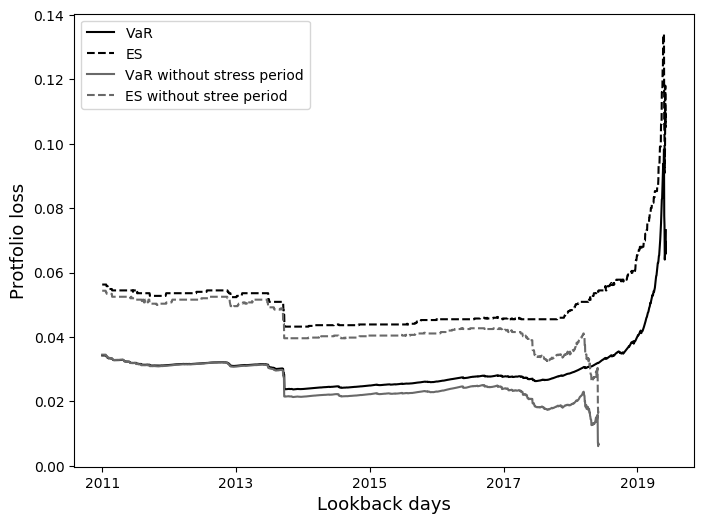

In [36]:
print("The values without corona (stress period) are lower")
plt.figure(figsize=(8, 6), dpi=100)
plt.plot(VaR_trend[::-1], label="VaR", color="k")
plt.plot(ES_trend[::-1], label="ES", color="k", ls="--")
plt.plot(VaR_trend_ex[::-1], label="VaR without stress period", color="#696969")
plt.plot(ES_trend_ex[::-1], label="ES without stree period", color="#696969", ls="--")
#plt.xticks(np.arange(8), (1, 2, 3, 4, 5, 6, 7, 8))
plt.xlabel("Lookback days", fontsize=13)
plt.ylabel("Protfolio loss", fontsize=13)
locs, labels = plt.xticks()
x_ticks = []
new_xticks = [dates[i] for d in locs for i in range(5)]
plt.xticks(locs[1:-1], new_xticks)
plt.legend()

**Pan:** Discussion points <br>
1. Ask about the dates
2. Ask about outliers
3. I set the monetary values as the percertage * the initial investment values (initials values of the portfolio?) <br>
Not sure if it's correct!!!!!!

### 2. Student t-distribution

### Check student t-assumption with QQ-plots

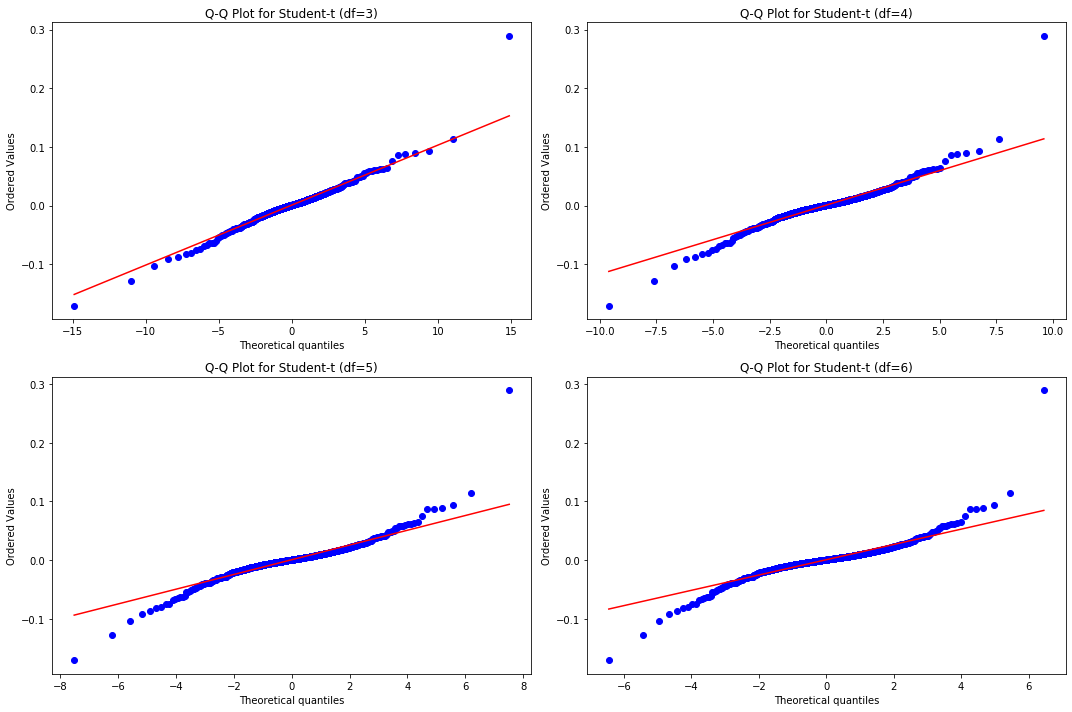

In [37]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
plt.subplot(2, 2, 1)
sc.stats.probplot(data["portfolio_return"][1:], dist=sc.stats.t(3), plot=plt)
plt.title("Q-Q Plot for Student-t (df=3)")
plt.tight_layout()
plt.subplot(2, 2, 2)
sc.stats.probplot(data["portfolio_return"][1:], dist=sc.stats.t(4), plot=plt)
plt.title("Q-Q Plot for Student-t (df=4)")
plt.tight_layout()
plt.subplot(2, 2, 3)
sc.stats.probplot(data["portfolio_return"][1:], dist=sc.stats.t(5), plot=plt)
plt.title("Q-Q Plot for Student-t (df=5)")
plt.tight_layout()
plt.subplot(2, 2, 4)
sc.stats.probplot(data["portfolio_return"][1:], dist=sc.stats.t(6), plot=plt)
plt.title("Q-Q Plot for Student-t (df=6)")
plt.tight_layout()
plt.show()

In [33]:
def fnVaR_t(dfData, weights, lookback, df, alpha, percent, initial_investment):
    """
    purpose:
        calculates VaR and ES with variance-covariance method
        using a t-distribution
    input:
        dfData, dataframe
        weights, weights vector
        apha, significance value
        lookback, lookback period
        df, degrees of freedom
        percent, True= express in percent
    output:
        VaR expressed in losses (positive value)
    """
    # check alpha
    if alpha > 0.5:
        alpha = 1 - alpha

    # express years in days
    years = lookback
    # select last n years of data
    DataTemp = dfData.iloc[-years  :, :-1]  # converted to days

    # calculate mean
    mean = np.array(np.mean(DataTemp)) @ weights.T
    mean = mean[0]

    # calculate covariance
    cov = np.cov(DataTemp, rowvar=False)
    # calculate variance
    variance = weights @ cov @ weights.T
    variance = (
        variance[0][0] * (df - 2) / df
    )  # account for variance of standard student-t

    # calculate quantile
    t = sc.stats.t.ppf(alpha, df)
    VaR = -mean + t * np.sqrt(variance)
    VaR = -VaR

    # calculate ES
    mean_return = dfData["portfolio_return"][-years * 250 :]
    ES_list = [x for x in mean_return if x < -VaR]
    ES = -np.mean(ES_list)

    ##Prepare Output
    if percent[0] == True:
        print(
            "DF=", df,
        )

        print(
            "(",
            percent[1] * 100,
            "%",
            " VaR, ES) in percent is: ",
            round(VaR * 100, 2),
            "%",
            round(ES * 100, 2),
            "%",
        )
    else:
        print(
            "(",
            percent[1] * 100,
            "%",
            " VaR, ES) in monetary terms is: ",
            round(VaR * initial_investment, 2),
            round(ES * initial_investment, 2),
        )
    return VaR, ES

#### 2.1. Non-stressed Estimates

In [39]:
fnVaR_t(df_prices, weights, lookback, 3, 0.025, [True, 0.975], initial_investment)
fnVaR_t(df_prices, weights, lookback, 3, 0.025, [False, 0.975], initial_investment)
fnVaR_t(df_prices, weights, lookback, 3, 0.01, [True, 0.99], initial_investment)
fnVaR_t(df_prices, weights, lookback, 3, 0.01, [False, 0.99], initial_investment)

fnVaR_t(df_prices, weights, lookback, 4, 0.025, [True, 0.975], initial_investment)
fnVaR_t(df_prices, weights, lookback, 4, 0.025, [False, 0.975], initial_investment)
fnVaR_t(df_prices, weights, lookback, 4, 0.01, [True, 0.99], initial_investment)
fnVaR_t(df_prices, weights, lookback, 4, 0.01, [False, 0.99], initial_investment)

fnVaR_t(df_prices, weights, lookback, 5, 0.025, [True, 0.975], initial_investment)
fnVaR_t(df_prices, weights, lookback, 5, 0.025, [False, 0.975], initial_investment)
fnVaR_t(df_prices, weights, lookback, 5, 0.01, [True, 0.99], initial_investment)
fnVaR_t(df_prices, weights, lookback, 5, 0.01, [False, 0.99], initial_investment)

fnVaR_t(df_prices, weights, lookback, 6, 0.025, [True, 0.975], initial_investment)
fnVaR_t(df_prices, weights, lookback, 6, 0.025, [False, 0.975], initial_investment)
fnVaR_t(df_prices, weights, lookback, 6, 0.01, [True, 0.99], initial_investment)
fnVaR_t(df_prices, weights, lookback, 6, 0.01, [False, 0.99], initial_investment)

DF= 3
( 97.5 %  VaR, ES) in percent is:  3.21 % 5.44 %
( 97.5 %  VaR, ES) in monetary terms is:  32140.9 54448.4
DF= 3
( 99.0 %  VaR, ES) in percent is:  4.56 % 7.21 %
( 99.0 %  VaR, ES) in monetary terms is:  45565.07 72060.3
DF= 4
( 97.5 %  VaR, ES) in percent is:  3.43 % 5.68 %
( 97.5 %  VaR, ES) in monetary terms is:  34295.39 56756.88
DF= 4
( 99.0 %  VaR, ES) in percent is:  4.6 % 7.32 %
( 99.0 %  VaR, ES) in monetary terms is:  46042.95 73196.52
DF= 5
( 97.5 %  VaR, ES) in percent is:  3.48 % 5.73 %
( 97.5 %  VaR, ES) in monetary terms is:  34773.35 57261.33
DF= 5
( 99.0 %  VaR, ES) in percent is:  4.53 % 7.21 %
( 99.0 %  VaR, ES) in monetary terms is:  45306.36 72060.3
DF= 6
( 97.5 %  VaR, ES) in percent is:  3.49 % 5.73 %
( 97.5 %  VaR, ES) in monetary terms is:  34888.58 57261.33
DF= 6
( 99.0 %  VaR, ES) in percent is:  4.46 % 7.21 %
( 99.0 %  VaR, ES) in monetary terms is:  44613.31 72060.3


(0.044613311678035485, 0.07206030487387367)

#### 2.2 Stressed Estimates

In [40]:
for name, df in zip(df_name, df_list):
    print(name)
    fnVaR_t(df, weights, lookback, 3, 0.025, [True, 0.975], initial_investment)
    fnVaR_t(df, weights, lookback, 3, 0.025, [False, 0.975], initial_investment)
    fnVaR_t(df, weights, lookback, 3, 0.01, [True, 0.99], initial_investment)
    fnVaR_t(df, weights, lookback, 3, 0.01, [False, 0.99], initial_investment)

df_prices_plus20
DF= 3
( 97.5 %  VaR, ES) in percent is:  3.21 % 5.44 %
( 97.5 %  VaR, ES) in monetary terms is:  32140.9 54448.4
DF= 3
( 99.0 %  VaR, ES) in percent is:  4.56 % 7.21 %
( 99.0 %  VaR, ES) in monetary terms is:  45565.07 72060.3
df_prices_plus40
DF= 3
( 97.5 %  VaR, ES) in percent is:  3.21 % 5.44 %
( 97.5 %  VaR, ES) in monetary terms is:  32140.9 54448.4
DF= 3
( 99.0 %  VaR, ES) in percent is:  4.56 % 7.21 %
( 99.0 %  VaR, ES) in monetary terms is:  45565.07 72060.3
df_prices_minus20
DF= 3
( 97.5 %  VaR, ES) in percent is:  3.21 % 5.44 %
( 97.5 %  VaR, ES) in monetary terms is:  32140.9 54448.4
DF= 3
( 99.0 %  VaR, ES) in percent is:  4.56 % 7.21 %
( 99.0 %  VaR, ES) in monetary terms is:  45565.07 72060.3
df_prices_minus40
DF= 3
( 97.5 %  VaR, ES) in percent is:  3.21 % 5.44 %
( 97.5 %  VaR, ES) in monetary terms is:  32140.9 54448.4
DF= 3
( 99.0 %  VaR, ES) in percent is:  4.56 % 7.21 %
( 99.0 %  VaR, ES) in monetary terms is:  45565.07 72060.3
df_prices_complus20
DF

### 3. Historical simulation method

In [34]:
def fnVaR_hist(dfData, weights, alpha, lookback, percent, initial_investment):
    """
    purpose:
        calculates VaR and ES with historical simulation
    input:
        dfData, dataframe
        weights, weights vector
        apha, significance value
        lookback, lookback period
        df, degrees of freedom
        percent, True= express in percent
    output:
        VaR expressed in losses (positive value)
    """
    # check alpha
    if alpha > 0.5:
        alpha = 1 - alpha

    # because the percentile function takes alpha=e[0,100]
    alpha = alpha * 100

    # express years in days
    years = lookback
    # select last n years of data
    DataTemp = dfData.iloc[-years :, :-1]  # converted to days

    # calculate mean
    mean = np.array(np.mean(DataTemp)) @ weights.T
    mean = mean[0]

    # calculate covariance
    cov = np.cov(DataTemp, rowvar=False)
    # calculate variance
    variance = weights @ cov @ weights.T
    std = np.sqrt(variance[0][0])

    # calculate quantile
    VaR = sc.percentile(DataTemp, alpha)
    VaR = -VaR

    # calculate ES
    mean_return = dfData["portfolio_return"][-years * 250 :]
    ES_list = [x for x in mean_return if x < -VaR]
    ES = -np.mean(ES_list)

    ##Prepare Output
    if percent[0] == True:
        print(
            "(",
            percent[1] * 100,
            "%",
            " VaR, ES) in percent is: ",
            round(VaR * 100, 2),
            "%",
            round(ES * 100, 2),
            "%",
        )
    else:
        print(
            "(",
            percent[1] * 100,
            "%",
            " VaR, ES) in monetary terms is: ",
            round(VaR * initial_investment, 2),
            round(ES * initial_investment, 2),
        )
    return VaR, ES


#### 3.1. Non-stressed Estimates

In [42]:
fnVaR_hist(df_prices, weights, 0.025, lookback, [True,0.975], initial_investment)
fnVaR_hist(df_prices, weights, 0.025, lookback, [False,0.975], initial_investment)
fnVaR_hist(df_prices, weights, 0.01, lookback, [True,0.99], initial_investment)
fnVaR_hist(df_prices, weights, 0.01, lookback, [False,0.99], initial_investment)

( 97.5 %  VaR, ES) in percent is:  5.6 % 8.53 %
( 97.5 %  VaR, ES) in monetary terms is:  56034.08 85299.66
( 99.0 %  VaR, ES) in percent is:  9.72 % 13.4 %
( 99.0 %  VaR, ES) in monetary terms is:  97239.66 134012.46


(0.09723965873479253, 0.13401245720780972)

#### 3.2. Stressed Estimates

In [43]:
for name, df in zip(df_name, df_list):
    print(name)
    fnVaR_hist(df, weights, 0.025, lookback, [True, 0.975], initial_investment)
    fnVaR_hist(df, weights, 0.025, lookback, [False, 0.975], initial_investment)
    fnVaR_hist(df, weights, 0.01, lookback, [True, 0.99], initial_investment)
    fnVaR_hist(df, weights, 0.01, lookback, [False, 0.99], initial_investment)

df_prices_plus20
( 97.5 %  VaR, ES) in percent is:  5.6 % 8.53 %
( 97.5 %  VaR, ES) in monetary terms is:  56034.08 85299.66
( 99.0 %  VaR, ES) in percent is:  9.72 % 13.4 %
( 99.0 %  VaR, ES) in monetary terms is:  97239.66 134012.46
df_prices_plus40
( 97.5 %  VaR, ES) in percent is:  5.6 % 8.53 %
( 97.5 %  VaR, ES) in monetary terms is:  56034.08 85299.66
( 99.0 %  VaR, ES) in percent is:  9.72 % 13.4 %
( 99.0 %  VaR, ES) in monetary terms is:  97239.66 134012.46
df_prices_minus20
( 97.5 %  VaR, ES) in percent is:  5.6 % 8.53 %
( 97.5 %  VaR, ES) in monetary terms is:  56034.08 85299.66
( 99.0 %  VaR, ES) in percent is:  9.72 % 13.4 %
( 99.0 %  VaR, ES) in monetary terms is:  97239.66 134012.46
df_prices_minus40
( 97.5 %  VaR, ES) in percent is:  5.6 % 8.53 %
( 97.5 %  VaR, ES) in monetary terms is:  56034.08 85299.66
( 99.0 %  VaR, ES) in percent is:  9.72 % 13.4 %
( 99.0 %  VaR, ES) in monetary terms is:  97239.66 134012.46
df_prices_complus20
( 97.5 %  VaR, ES) in percent is:  5.6

### 4.Filtered historical simulation using EWMA

In [35]:
""" Filtered historical simulation using EWMA """
# returns = data[['DE_1YBOND_return',"BTC_return", "DBC_return", "GSPC_return", "N225_return"]]
def fnVaR_FilterEWMA(
    dfData, weights, ewma_con, alpha, lookback, percent, initial_investment
):
    returns = dfData.iloc[:, :]
    print(returns.shape)
    tVar = np.zeros((lookback // 250*250 + 100 + 1, 7))
    alpha = alpha * 100
    ##calculate variance at day-100 using the previous days
    for i in range(7):
        tVar[0, i] = returns.iloc[-(lookback//250 * 250 + 101), i]

    # calculate first 100 days volatility
    for i in range(7):
        for j in range(100):
            tVar[1 + j, i] = (
                ewma_con * tVar[1 + j - 1, i]
                + (1 - ewma_con) * returns.iloc[-(lookback//250*250  + 100) + j - 1, i] ** 2
            )
    # print(tVar)
    Z_matrix = np.zeros((500, 7))
    R_matrix = np.zeros((500, 7))
    VaR_all = np.zeros(5)
    ES_all = np.zeros(5)
    # calculate first 500 days Z values and use them to approximate the VaR and ES on the 501th day
    for i in range(7):
        for j in range(500):
            tVar[101 + j, i] = (
                ewma_con * tVar[101 + j - 1, i]
                + (1 - ewma_con) * returns.iloc[-(lookback//250 * 250) + j - 1, i] ** 2
            )
            Z_matrix[j, i] = returns.iloc[-(lookback//250 * 250 + 100) + j, i] / sc.sqrt(
                tVar[101 + j, i]
            )
            new_sigma = sc.sqrt(
                ewma_con * tVar[101 + j, i]
                + (1 - ewma_con) * returns.iloc[-(lookback//250 * 250) + j, i] ** 2
            )
            R_matrix[:, i] = Z_matrix[:, i] * new_sigma
    R_matrix[:,0] = R_matrix[:,0] + R_matrix[:,-2]
    R_matrix[:,4] = R_matrix[:,4] + R_matrix[:,-1]
    for i in range(5):
            # print(new_sigma)
        VaR_all[i] = -sc.percentile(R_matrix[:, i], alpha)
        ES_list = [x for x in R_matrix[:, i] if x < -VaR_all[i]]
        ES_all[i] = -np.mean(ES_list)
        # print(VaR_all)
    VaR = (VaR_all @ weights.T)[0]
    ES = (ES_all @ weights.T)[0]

    if percent[0] == True:
        print(
            "(",
            percent[1] * 100,
            "%",    
            " VaR, ES) in percent is: ",
            round(VaR * 100, 2),
            "%",
            round(ES * 100, 2),
            "%",
        )
    else:
        print(
            "(",
            percent[1] * 100,
            "%",
            " VaR, ES) in monetary terms is: ",
            round(VaR * initial_investment, 2),
            round(ES * initial_investment, 2),
        )
    return VaR, ES

#### 4.1. Non-stressed Estimates

In [45]:
fnVaR_FilterEWMA(df_prices2, weights, 0.94, 0.025, lookback, [True, 0.975], initial_investment)
fnVaR_FilterEWMA(df_prices2, weights, 0.94, 0.025, lookback, [False, 0.975], initial_investment)
fnVaR_FilterEWMA(df_prices2, weights, 0.94, 0.01, lookback, [True, 0.99], initial_investment)
fnVaR_FilterEWMA(df_prices2, weights, 0.94, 0.01, lookback, [False, 0.99], initial_investment)

(2112, 7)
( 97.5 %  VaR, ES) in percent is:  6.89 % 10.21 %
(2112, 7)
( 97.5 %  VaR, ES) in monetary terms is:  68938.9 102068.19
(2112, 7)
( 99.0 %  VaR, ES) in percent is:  10.26 % 13.48 %
(2112, 7)
( 99.0 %  VaR, ES) in monetary terms is:  102633.09 134807.55


(0.10263309280187904, 0.13480755244775577)

#### 4.2. Stressed Estimates

In [345]:
for name, df in zip(df_name, df_list):
    print(name)
    fnVaR_FilterEWMA(df, weights, 0.94, 0.025, 2, [True, 0.975], initial_investment)
    fnVaR_FilterEWMA(df, weights, 0.94, 0.025, 2, [False, 0.975], initial_investment)
    fnVaR_FilterEWMA(df, weights, 0.94, 0.01, 2, [True, 0.99], initial_investment)
    fnVaR_FilterEWMA(df, weights, 0.94, 0.01, 2, [False, 0.99], initial_investment)

df_prices_plus20
(2112, 5)
( 97.5 %  VaR, ES) in percent is:  14.84 % 21.32 %
(2112, 5)
( 97.5 %  VaR, ES) in monetary terms is:  148443.74 213153.38
(2112, 5)
( 99.0 %  VaR, ES) in percent is:  21.64 % 26.25 %
(2112, 5)
( 99.0 %  VaR, ES) in monetary terms is:  216384.48 262481.94
df_prices_plus40
(2112, 5)
( 97.5 %  VaR, ES) in percent is:  14.84 % 21.32 %
(2112, 5)
( 97.5 %  VaR, ES) in monetary terms is:  148443.74 213153.38
(2112, 5)
( 99.0 %  VaR, ES) in percent is:  21.64 % 26.25 %
(2112, 5)
( 99.0 %  VaR, ES) in monetary terms is:  216384.48 262481.94
df_prices_minus20
(2112, 5)
( 97.5 %  VaR, ES) in percent is:  14.84 % 21.32 %
(2112, 5)
( 97.5 %  VaR, ES) in monetary terms is:  148443.74 213153.38
(2112, 5)
( 99.0 %  VaR, ES) in percent is:  21.64 % 26.25 %
(2112, 5)
( 99.0 %  VaR, ES) in monetary terms is:  216384.48 262481.94
df_prices_minus40
(2112, 5)
( 97.5 %  VaR, ES) in percent is:  14.84 % 21.32 %
(2112, 5)
( 97.5 %  VaR, ES) in monetary terms is:  148443.74 213153.38

<IPython.core.display.Javascript object>

### 6. GARCH(1,1) with constant correlation matrix

In [36]:
from scipy.optimize import minimize


def fGarchFilter(vData, dOmega, dAlpha, dBeta, dSigma2):

    # initialize sizes and formats
    iT = vData.shape[0]
    vVariances = np.zeros(iT)
    vLikelihoodValues = np.ones(iT)

    # filter variances and compute likelihood contributions by
    # a loop over the observations
    for i1 in range(iT):

        # update filtered variances
        vVariances[i1] = dSigma2

        # compute the likelihood contribution
        vLikelihoodValues[i1] = (
            -0.5 * np.log(dSigma2) - 0.5 * vData.iloc[i1] * vData.iloc[i1] / dSigma2
        )

        # update the filter
        dSigma2 = dOmega + dBeta * dSigma2 + dAlpha * vData.iloc[i1] * vData.iloc[i1]

    # add likelihood constants
    vLikelihoodValues = vLikelihoodValues - 0.5 * np.log(2 * np.pi)

    # return filtered variances and likelihood values
    return (vVariances, vLikelihoodValues)


class cMaximizeLikelihood:
    def __init__(self):
        self.x0 = []
        self.x = []
        self.tx0 = []
        self.tx = []
        self.likelihoodvalue = []
        self.tcovariancematrix = []
        self.covariancematrix = []
        self.filter = []
        self.success = False


def fMaximizeLikelihood(vData):

    cReturnValue = cMaximizeLikelihood()

    def LOCAL_fParameterTransform(vTheta, bShapeAsVector=False):
        r = ((np.exp(vTheta[0])), (np.exp(vTheta[1])), (1 / (1 + np.exp(-vTheta[2]))))
        if bShapeAsVector == True:
            return np.append([], r)
        else:
            return r

    def LOCAL_fObjective(vTheta, bForAllT=False):
        # initialize the parameter values
        dOmega, dAlpha, dBeta = LOCAL_fParameterTransform(vTheta)
        dSigma2 = np.var(vData)

        # run the filter
        vVariances, vLikelihoodValues = fGarchFilter(
            vData, dOmega, dAlpha, dBeta, dSigma2
        )
        cReturnValue.filter = vVariances
        if bForAllT == True:
            dObjValue = vLikelihoodValues
        else:
            dObjValue = -np.mean(vLikelihoodValues)

        return dObjValue

    # initialize starting values and return value
    vTheta = np.log([1, 0.05, 0.93])
    vTheta[0] = np.log(np.var(vData) * (1 - 0.98))
    cReturnValue.x0 = vTheta
    cReturnValue.tx0 = LOCAL_fParameterTransform(vTheta)

    # do the optimization
    tSol = minimize(
        LOCAL_fObjective,
        vTheta,
        method="BFGS",#Nelder-Mead
        options={"disp": True, "maxiter": 100,"gtol": 1e-7 * len(vData)},
    )
    cReturnValue.success = tSol["success"]
    # check for success and store results
    if tSol["success"] != True:
        print("*** no true convergence: ", tSol["message"])
    else:
        cReturnValue.x = tSol["x"]
        cReturnValue.tx = LOCAL_fParameterTransform(cReturnValue.x)
        cReturnValue.likelihoodvalue = -vData.shape[0] * tSol["fun"]

    return cReturnValue

In [37]:
def fnVaR_GARCH(dfData,data2, weights, alpha, lookback, percent,initial_investment):
    """
    purpose:
        calculates VaR and ES with GARCH method
        using a normal distribution
    input:
        dfData, dataframe
        weights, weights vector
        apha, significance value
        lookback, lookback period
        percent, True= express in percent
    output:
        VaR expressed in losses (positive value)
    """
    # check alpha
    if alpha > 0.5:
        alpha= 1-alpha
    
    # express years in days
    years= lookback
    # select last n years of data
    DataTemp= dfData.iloc[-years:,:]
    # calculate covariance
    corr =  DataTemp.iloc[:,:].corr()
    #cov= np.cov(DataTemp.iloc[1:,:], rowvar= False)    
    # estimate a GARCH(1,1) model and store the one step ahead
    # forecasts in a vector
    vVariances= np.zeros(7)
    for i in range(7):
        out = fMaximizeLikelihood(DataTemp.iloc[:,i])
        dOmega, dAlpha, dBeta= out.tx
        sigma2hat= dOmega + dAlpha*DataTemp.iloc[-1,i]**2+dBeta*out.filter[-1]
        vVariances[i]= sigma2hat
    # fill diagonal elements of covariance matrix with GARCH estimates
    sigmamatrix = np.zeros((7, 7))
    np.fill_diagonal(sigmamatrix, np.sqrt(vVariances))
    cov = np.matmul(np.matmul(sigmamatrix,corr),sigmamatrix)
    #np.fill_diagonal(cov, vVariances)
    # calculate the variance
    variance= weights@cov@weights.T
    variance= variance[0][0]
    # calculate mean
    mean= np.array(np.mean(DataTemp))@weights.T
    mean= mean[0]
    # calculate quantile
    z= sc.stats.norm.ppf(alpha)
    VaR= mean + z * np.sqrt(variance)
    VaR= -VaR
    # calculate ES
    mean_return = data2["portfolio_return"][-years  :]
    ES_list = [x for x in mean_return if x < -VaR]
    ES= -np.mean(ES_list)
    if percent[0] == True:
        print(
            "(",
            percent[1]* 100,
            "%",
            " VaR, ES) in percent is: ",
            round(VaR * 100, 2),
            "%",
            round(ES * 100, 2),
            "%",
        )
    else:
        print(
            "(",
            percent[1] * 100,
            "%",
            " VaR, ES) in monetary terms is: ",
            round(VaR * initial_investment, 2),
            round(ES * initial_investment, 2),)
    return VaR, ES

In [42]:
weightss = np.array([[0.2,0.2,0.2,0.2,0.2,0.2,0.2]])

In [52]:
fnVaR_GARCH(df_prices2, df_prices,weightss, 0.025, 2100, [True,0.975],initial_investment)
fnVaR_GARCH(df_prices2, df_prices,weightss, 0.025, 2100, [False,0.975],initial_investment)
fnVaR_GARCH(df_prices2, df_prices,weightss, 0.01, 2100, [True,0.99],initial_investment)
fnVaR_GARCH(df_prices2, df_prices,weightss, 0.01, 2100, [False,0.99],initial_investment)

Optimization terminated successfully.
         Current function value: -2.514406
         Iterations: 20
         Function evaluations: 105
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: -1.510999
         Iterations: 16
         Function evaluations: 90
         Gradient evaluations: 18
Optimization terminated successfully.
         Current function value: -3.213987
         Iterations: 25
         Function evaluations: 135
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: -3.365510
         Iterations: 20
         Function evaluations: 105
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: -2.991155
         Iterations: 22
         Function evaluations: 115
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: -3.816606
         Iterations: 24
         Function evaluati

(0.060247270514849474, 0.08529966139684692)

### Backtesting all five methods

In [38]:
df_prices = data[
    [
        "DE_1YBOND_return",
        "BTC_return",
        "DBC_return",
        "GSPC_return",
        "N225_return",
        "portfolio_return",
    ]
]
df_prices = df_prices.set_index(pd.to_datetime(data["Date"]))

In [39]:
df_prices

,DE_1YBOND_return,BTC_return,DBC_return,GSPC_return,N225_return,portfolio_return
Date,,,,,,
2011-03-31,NaN,NaN,NaN,NaN,NaN,NaN
2011-04-01,0.097,-0.013473,0.006859,0.004951,-0.007297,0.017608
2011-04-04,-0.014,-0.129608,0.009073,0.000345,-0.009141,-0.028666
2011-04-05,0.007,0.043172,0.000967,-0.000180,-0.009680,0.008256
2011-04-06,-0.005,0.041385,0.002896,0.002181,-0.015352,0.005222
...,...,...,...,...,...,...
2020-03-24,0.084,0.048445,0.021449,0.089683,0.065580,0.061831
2020-03-25,-0.030,-0.008012,0.016660,0.011469,0.074650,0.012953
2020-03-26,0.023,0.005281,-0.003484,0.060544,-0.043954,0.008277


In [47]:
def fnRollingVaR(dfData, data2,weights, alpha, lookback, sm_const, df,percent=[True,0.975]):
    '''
    purpose:
        calculate VaR with a rolling window
    input:
        dfData, dataframe of risk factors
        weights, portfolio weights
        alpha, significance level
        lookback, lookback period
        sm_const, smoothing constant for EWMA
        df, degrees of freedom for t-distribution
    output
        dfVaR, dataframe of VaR for every day
    '''
    windowsize= lookback+101
    N= len(dfData)-windowsize
    dfVaR= pd.DataFrame(np.zeros((N,10)))
    dfVaR.index = dfData.index[windowsize:]
    dfVaR.columns= ["VaR_n", "ES_n", "VaR_t", "ES_t", "VaR_hist", "ES_hist",\
                    "VaR_FilterEWMA","ES_FilterEWMA","VaR_GARCH","ES_GARCH"]
    # VaR and ES for 1 year lookback
    for i in range(N):
        # calculate rolling window
        DataTemp= dfData.iloc[0+i:windowsize+i,:]
        DataTemp2= data2.iloc[0+i:windowsize+i,:]
        # calculate VaR
        dfVaR.iloc[i,0], dfVaR.iloc[i,1]= fnVaR_n(DataTemp, weights, alpha, lookback,percent,initial_investment )
        dfVaR.iloc[i,2], dfVaR.iloc[i,3]= fnVaR_t(DataTemp, weights,lookback,df, alpha, percent,initial_investment)
        dfVaR.iloc[i,4], dfVaR.iloc[i,5]= fnVaR_hist(DataTemp, weights, alpha, lookback, percent,initial_investment)
        dfVaR.iloc[i,6], dfVaR.iloc[i,7]= fnVaR_FilterEWMA(DataTemp2, weights,sm_const, alpha, lookback, percent,initial_investment)
        #dfVaR.iloc[i,8], dfVaR.iloc[i,9]= fnVaR_GARCH(DataTemp2,DataTemp, weightss, alpha, lookback, percent,initial_investment)
    
    return dfVaR


In [48]:
df = fnRollingVaR(df_prices,df_prices2, weights, 0.01, 500, 0.94, 5, percent=[True, 0.99])
df.to_csv("01_Data/df_99.csv", index_label= "Date")

( 99.0 %  VaR, ES) in percent is:  4.07 % 6.78 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  4.55 % 7.21 %
( 99.0 %  VaR, ES) in percent is:  10.25 % 10.32 %
(601, 7)


/home/isualice/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/isualice/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


( 99.0 %  VaR, ES) in percent is:  nan % nan %
( 99.0 %  VaR, ES) in percent is:  4.08 % 6.78 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  4.56 % 7.21 %
( 99.0 %  VaR, ES) in percent is:  10.25 % 10.32 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  9.35 % 12.26 %
( 99.0 %  VaR, ES) in percent is:  4.03 % 6.59 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  4.5 % 7.21 %
( 99.0 %  VaR, ES) in percent is:  10.1 % 10.32 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  10.26 % 13.46 %
( 99.0 %  VaR, ES) in percent is:  4.02 % 6.59 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  4.49 % 7.21 %
( 99.0 %  VaR, ES) in percent is:  10.1 % 10.32 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  10.16 % 13.46 %
( 99.0 %  VaR, ES) in percent is:  4.02 % 6.59 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  4.49 % 7.21 %
( 99.0 %  VaR, ES) in percent is:  10.1 % 10.32 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  10.78 % 14.27 %
( 99.0 %  VaR, ES) in percent is:  3.94 % 6.41 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  4.4 % 6.

( 99.0 %  VaR, ES) in percent is:  18.9 % 24.73 %
( 99.0 %  VaR, ES) in percent is:  4.08 % 6.8 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  4.54 % 7.0 %
( 99.0 %  VaR, ES) in percent is:  10.1 % 10.32 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  19.7 % 25.86 %
( 99.0 %  VaR, ES) in percent is:  4.08 % 6.8 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  4.54 % 7.0 %
( 99.0 %  VaR, ES) in percent is:  10.1 % 10.32 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  19.3 % 25.36 %
( 99.0 %  VaR, ES) in percent is:  4.1 % 6.66 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  4.57 % 6.84 %
( 99.0 %  VaR, ES) in percent is:  10.3 % 10.32 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  20.79 % 27.35 %
( 99.0 %  VaR, ES) in percent is:  4.16 % 6.66 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  4.63 % 6.84 %
( 99.0 %  VaR, ES) in percent is:  10.3 % 10.32 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  22.43 % 29.44 %
( 99.0 %  VaR, ES) in percent is:  4.16 % 6.79 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  4.63 % 6.98

( 99.0 %  VaR, ES) in percent is:  31.35 % 41.53 %
( 99.0 %  VaR, ES) in percent is:  4.48 % 7.66 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  5.0 % 8.14 %
( 99.0 %  VaR, ES) in percent is:  11.89 % 17.09 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  33.25 % 44.11 %
( 99.0 %  VaR, ES) in percent is:  4.5 % 7.56 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  5.02 % 8.32 %
( 99.0 %  VaR, ES) in percent is:  12.41 % 17.09 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  33.22 % 43.88 %
( 99.0 %  VaR, ES) in percent is:  5.48 % 8.64 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  6.12 % 8.64 %
( 99.0 %  VaR, ES) in percent is:  12.41 % 17.09 %
(601, 7)


/home/isualice/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: ComplexWarning: Casting complex values to real discards the imaginary part
/home/isualice/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: ComplexWarning: Casting complex values to real discards the imaginary part


( 99.0 %  VaR, ES) in percent is:  54.38 % 71.85 %
( 99.0 %  VaR, ES) in percent is:  5.48 % 8.88 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  6.11 % 8.88 %
( 99.0 %  VaR, ES) in percent is:  12.41 % 17.09 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  52.79 % 69.91 %
( 99.0 %  VaR, ES) in percent is:  5.48 % 9.07 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  6.11 % 9.07 %
( 99.0 %  VaR, ES) in percent is:  12.41 % 17.09 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  51.09 % 67.33 %
( 99.0 %  VaR, ES) in percent is:  5.49 % 9.07 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  6.12 % 9.07 %
( 99.0 %  VaR, ES) in percent is:  12.41 % 17.09 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  50.01 % 65.97 %
( 99.0 %  VaR, ES) in percent is:  5.49 % 9.07 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  6.12 % 9.07 %
( 99.0 %  VaR, ES) in percent is:  11.89 % 17.09 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  48.44 % 63.96 %
( 99.0 %  VaR, ES) in percent is:  5.49 % 9.07 %
DF= 5
( 99.0 %  VaR, ES) in percent is: 

( 99.0 %  VaR, ES) in percent is:  19.78 % 26.14 %
( 99.0 %  VaR, ES) in percent is:  5.45 % 9.49 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  6.08 % 9.49 %
( 99.0 %  VaR, ES) in percent is:  12.41 % 17.09 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  19.35 % 25.72 %
( 99.0 %  VaR, ES) in percent is:  5.45 % 9.49 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  6.08 % 9.49 %
( 99.0 %  VaR, ES) in percent is:  12.41 % 17.09 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  18.8 % 24.99 %
( 99.0 %  VaR, ES) in percent is:  5.45 % 9.49 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  6.08 % 9.49 %
( 99.0 %  VaR, ES) in percent is:  12.41 % 17.09 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  18.47 % 24.76 %
( 99.0 %  VaR, ES) in percent is:  5.44 % 9.49 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  6.07 % 9.49 %
( 99.0 %  VaR, ES) in percent is:  12.41 % 17.09 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  17.99 % 24.02 %
( 99.0 %  VaR, ES) in percent is:  5.44 % 9.49 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  

( 99.0 %  VaR, ES) in percent is:  7.21 % 9.83 %
( 99.0 %  VaR, ES) in percent is:  5.45 % 9.49 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  6.08 % 9.49 %
( 99.0 %  VaR, ES) in percent is:  11.89 % 17.09 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  7.14 % 9.82 %
( 99.0 %  VaR, ES) in percent is:  5.45 % 9.49 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  6.08 % 9.49 %
( 99.0 %  VaR, ES) in percent is:  11.89 % 17.09 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  7.09 % 9.67 %
( 99.0 %  VaR, ES) in percent is:  5.45 % 9.49 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  6.08 % 9.49 %
( 99.0 %  VaR, ES) in percent is:  11.89 % 17.09 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  6.84 % 9.35 %
( 99.0 %  VaR, ES) in percent is:  5.45 % 9.49 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  6.08 % 9.49 %
( 99.0 %  VaR, ES) in percent is:  11.89 % 17.09 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  6.59 % 9.03 %
( 99.0 %  VaR, ES) in percent is:  5.46 % 9.49 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  6.09 % 9.

( 99.0 %  VaR, ES) in percent is:  6.18 % 10.91 %
( 99.0 %  VaR, ES) in percent is:  5.43 % 9.49 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  6.06 % 9.49 %
( 99.0 %  VaR, ES) in percent is:  11.89 % 17.09 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  6.04 % 10.74 %
( 99.0 %  VaR, ES) in percent is:  5.43 % 9.49 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  6.06 % 9.49 %
( 99.0 %  VaR, ES) in percent is:  11.89 % 17.09 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  5.88 % 10.41 %
( 99.0 %  VaR, ES) in percent is:  5.43 % 9.49 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  6.06 % 9.49 %
( 99.0 %  VaR, ES) in percent is:  11.89 % 17.09 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  5.75 % 10.15 %
( 99.0 %  VaR, ES) in percent is:  5.43 % 9.49 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  6.06 % 9.49 %
( 99.0 %  VaR, ES) in percent is:  11.89 % 17.09 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  5.58 % 9.85 %
( 99.0 %  VaR, ES) in percent is:  5.43 % 9.49 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  6.06 

( 99.0 %  VaR, ES) in percent is:  8.3 % 14.46 %
( 99.0 %  VaR, ES) in percent is:  5.35 % 9.49 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  5.97 % 9.49 %
( 99.0 %  VaR, ES) in percent is:  11.21 % 17.09 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  8.11 % 13.7 %
( 99.0 %  VaR, ES) in percent is:  5.35 % 9.49 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  5.97 % 9.49 %
( 99.0 %  VaR, ES) in percent is:  11.21 % 17.09 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  7.92 % 13.32 %
( 99.0 %  VaR, ES) in percent is:  5.35 % 9.49 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  5.97 % 9.49 %
( 99.0 %  VaR, ES) in percent is:  11.21 % 17.09 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  7.79 % 13.17 %
( 99.0 %  VaR, ES) in percent is:  5.35 % 9.49 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  5.97 % 9.49 %
( 99.0 %  VaR, ES) in percent is:  11.21 % 17.09 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  8.04 % 13.59 %
( 99.0 %  VaR, ES) in percent is:  5.34 % 9.49 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  5.97 %

( 99.0 %  VaR, ES) in percent is:  7.4 % 12.75 %
( 99.0 %  VaR, ES) in percent is:  5.32 % 9.49 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  5.95 % 9.49 %
( 99.0 %  VaR, ES) in percent is:  9.67 % 17.09 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  7.2 % 12.58 %
( 99.0 %  VaR, ES) in percent is:  5.33 % 9.49 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  5.95 % 9.49 %
( 99.0 %  VaR, ES) in percent is:  9.67 % 17.09 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  7.51 % 12.94 %
( 99.0 %  VaR, ES) in percent is:  5.33 % 9.49 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  5.95 % 9.49 %
( 99.0 %  VaR, ES) in percent is:  9.67 % 17.09 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  7.66 % 13.04 %
( 99.0 %  VaR, ES) in percent is:  5.33 % 9.49 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  5.96 % 9.49 %
( 99.0 %  VaR, ES) in percent is:  11.21 % 17.09 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  9.11 % 15.86 %
( 99.0 %  VaR, ES) in percent is:  5.33 % 9.49 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  5.96 % 9.

( 99.0 %  VaR, ES) in percent is:  9.1 % 16.51 %
( 99.0 %  VaR, ES) in percent is:  5.41 % 8.69 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  6.05 % 9.49 %
( 99.0 %  VaR, ES) in percent is:  11.88 % 17.09 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  9.34 % 16.99 %
( 99.0 %  VaR, ES) in percent is:  5.41 % 8.69 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  6.05 % 9.49 %
( 99.0 %  VaR, ES) in percent is:  11.88 % 17.09 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  9.07 % 16.54 %
( 99.0 %  VaR, ES) in percent is:  5.41 % 8.69 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  6.04 % 9.49 %
( 99.0 %  VaR, ES) in percent is:  11.88 % 17.09 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  8.9 % 16.21 %
( 99.0 %  VaR, ES) in percent is:  5.41 % 8.69 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  6.04 % 9.49 %
( 99.0 %  VaR, ES) in percent is:  11.88 % 17.09 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  8.6 % 15.72 %
( 99.0 %  VaR, ES) in percent is:  5.4 % 8.69 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  6.04 % 9

( 99.0 %  VaR, ES) in percent is:  6.01 % 10.57 %
( 99.0 %  VaR, ES) in percent is:  5.32 % 8.14 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  5.96 % 9.49 %
( 99.0 %  VaR, ES) in percent is:  11.88 % 17.09 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  5.95 % 10.28 %
( 99.0 %  VaR, ES) in percent is:  5.32 % 8.14 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  5.95 % 9.49 %
( 99.0 %  VaR, ES) in percent is:  11.88 % 17.09 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  6.3 % 10.8 %
( 99.0 %  VaR, ES) in percent is:  5.32 % 8.14 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  5.95 % 9.49 %
( 99.0 %  VaR, ES) in percent is:  11.88 % 17.09 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  6.15 % 10.63 %
( 99.0 %  VaR, ES) in percent is:  5.32 % 8.14 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  5.95 % 9.49 %
( 99.0 %  VaR, ES) in percent is:  11.88 % 17.09 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  6.1 % 10.57 %
( 99.0 %  VaR, ES) in percent is:  5.32 % 8.14 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  5.95 % 

( 99.0 %  VaR, ES) in percent is:  6.08 % 9.69 %
( 99.0 %  VaR, ES) in percent is:  4.92 % 7.73 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  5.5 % 8.69 %
( 99.0 %  VaR, ES) in percent is:  9.67 % 17.09 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  6.15 % 9.77 %
( 99.0 %  VaR, ES) in percent is:  4.92 % 7.73 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  5.51 % 8.69 %
( 99.0 %  VaR, ES) in percent is:  9.67 % 17.09 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  6.17 % 9.81 %
( 99.0 %  VaR, ES) in percent is:  4.92 % 7.73 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  5.51 % 8.69 %
( 99.0 %  VaR, ES) in percent is:  9.67 % 17.09 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  6.19 % 9.83 %
( 99.0 %  VaR, ES) in percent is:  4.91 % 7.73 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  5.5 % 8.69 %
( 99.0 %  VaR, ES) in percent is:  9.67 % 17.09 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  6.76 % 10.78 %
( 99.0 %  VaR, ES) in percent is:  4.91 % 7.73 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  5.5 % 8.69 %
(

( 99.0 %  VaR, ES) in percent is:  11.91 % 19.4 %
( 99.0 %  VaR, ES) in percent is:  4.92 % 7.73 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  5.51 % 9.49 %
( 99.0 %  VaR, ES) in percent is:  9.66 % 17.09 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  11.95 % 19.28 %
( 99.0 %  VaR, ES) in percent is:  4.92 % 7.73 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  5.51 % 9.49 %
( 99.0 %  VaR, ES) in percent is:  9.66 % 17.09 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  11.88 % 19.2 %
( 99.0 %  VaR, ES) in percent is:  4.91 % 7.73 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  5.5 % 8.69 %
( 99.0 %  VaR, ES) in percent is:  9.66 % 17.09 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  11.8 % 19.0 %
( 99.0 %  VaR, ES) in percent is:  4.91 % 7.73 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  5.5 % 8.69 %
( 99.0 %  VaR, ES) in percent is:  9.66 % 17.09 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  11.54 % 18.58 %
( 99.0 %  VaR, ES) in percent is:  4.91 % 7.73 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  5.5 % 8.6

( 99.0 %  VaR, ES) in percent is:  7.23 % 11.2 %
( 99.0 %  VaR, ES) in percent is:  4.89 % 7.73 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  5.48 % 8.69 %
( 99.0 %  VaR, ES) in percent is:  9.66 % 17.09 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  7.14 % 11.16 %
( 99.0 %  VaR, ES) in percent is:  4.9 % 7.73 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  5.49 % 8.69 %
( 99.0 %  VaR, ES) in percent is:  9.66 % 17.09 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  6.91 % 11.31 %
( 99.0 %  VaR, ES) in percent is:  4.9 % 7.73 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  5.49 % 8.69 %
( 99.0 %  VaR, ES) in percent is:  9.66 % 17.09 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  6.95 % 11.26 %
( 99.0 %  VaR, ES) in percent is:  4.9 % 7.73 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  5.49 % 8.69 %
( 99.0 %  VaR, ES) in percent is:  9.66 % 17.09 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  7.53 % 11.68 %
( 99.0 %  VaR, ES) in percent is:  4.9 % 7.96 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  5.49 % 9.28 %

( 99.0 %  VaR, ES) in percent is:  8.65 % 15.99 %
( 99.0 %  VaR, ES) in percent is:  4.87 % 7.85 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  5.46 % 9.65 %
( 99.0 %  VaR, ES) in percent is:  9.59 % 17.09 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  8.9 % 16.7 %
( 99.0 %  VaR, ES) in percent is:  4.85 % 7.85 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  5.44 % 9.65 %
( 99.0 %  VaR, ES) in percent is:  9.59 % 17.09 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  8.78 % 16.33 %
( 99.0 %  VaR, ES) in percent is:  4.85 % 7.85 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  5.43 % 9.65 %
( 99.0 %  VaR, ES) in percent is:  9.59 % 17.09 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  8.55 % 15.91 %
( 99.0 %  VaR, ES) in percent is:  4.84 % 7.85 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  5.42 % 9.65 %
( 99.0 %  VaR, ES) in percent is:  9.59 % 17.09 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  8.51 % 15.8 %
( 99.0 %  VaR, ES) in percent is:  4.82 % 7.85 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  5.4 % 8.59 

( 99.0 %  VaR, ES) in percent is:  8.45 % 14.89 %
( 99.0 %  VaR, ES) in percent is:  4.38 % 6.65 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  4.92 % 8.59 %
( 99.0 %  VaR, ES) in percent is:  7.47 % 17.09 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  8.28 % 14.58 %
( 99.0 %  VaR, ES) in percent is:  4.39 % 6.65 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  4.93 % 8.59 %
( 99.0 %  VaR, ES) in percent is:  7.47 % 17.09 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  8.12 % 14.29 %
( 99.0 %  VaR, ES) in percent is:  4.39 % 6.65 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  4.93 % 8.59 %
( 99.0 %  VaR, ES) in percent is:  7.47 % 17.09 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  8.34 % 14.56 %
( 99.0 %  VaR, ES) in percent is:  4.39 % 6.65 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  4.93 % 8.59 %
( 99.0 %  VaR, ES) in percent is:  7.6 % 17.09 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  8.55 % 14.7 %
( 99.0 %  VaR, ES) in percent is:  4.39 % 6.65 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  4.93 % 8.5

( 99.0 %  VaR, ES) in percent is:  5.73 % 8.51 %
( 99.0 %  VaR, ES) in percent is:  2.31 % 4.36 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  2.6 % 4.62 %
( 99.0 %  VaR, ES) in percent is:  7.01 % 17.09 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  6.14 % 9.2 %
( 99.0 %  VaR, ES) in percent is:  2.31 % 4.36 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  2.6 % 4.62 %
( 99.0 %  VaR, ES) in percent is:  7.01 % 17.09 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  6.15 % 9.15 %
( 99.0 %  VaR, ES) in percent is:  2.31 % 4.36 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  2.6 % 4.62 %
( 99.0 %  VaR, ES) in percent is:  7.01 % 17.09 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  5.97 % 9.07 %
( 99.0 %  VaR, ES) in percent is:  2.31 % 4.42 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  2.6 % 4.71 %
( 99.0 %  VaR, ES) in percent is:  7.01 % 17.09 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  6.17 % 9.38 %
( 99.0 %  VaR, ES) in percent is:  2.31 % 4.42 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  2.6 % 4.71 %
( 99.

( 99.0 %  VaR, ES) in percent is:  14.04 % 20.94 %
( 99.0 %  VaR, ES) in percent is:  2.33 % 4.42 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  2.62 % 4.6 %
( 99.0 %  VaR, ES) in percent is:  6.79 % 17.09 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  13.75 % 20.46 %
( 99.0 %  VaR, ES) in percent is:  2.33 % 4.42 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  2.62 % 4.6 %
( 99.0 %  VaR, ES) in percent is:  6.79 % 17.09 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  13.55 % 20.13 %
( 99.0 %  VaR, ES) in percent is:  2.34 % 4.42 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  2.62 % 4.6 %
( 99.0 %  VaR, ES) in percent is:  6.79 % 17.09 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  13.37 % 19.86 %
( 99.0 %  VaR, ES) in percent is:  2.34 % 4.42 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  2.63 % 4.6 %
( 99.0 %  VaR, ES) in percent is:  6.79 % 17.09 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  12.92 % 19.2 %
( 99.0 %  VaR, ES) in percent is:  2.33 % 4.42 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  2.62 % 4

( 99.0 %  VaR, ES) in percent is:  7.39 % 11.14 %
( 99.0 %  VaR, ES) in percent is:  2.31 % 4.5 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  2.59 % 4.72 %
( 99.0 %  VaR, ES) in percent is:  7.01 % 17.09 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  7.12 % 11.1 %
( 99.0 %  VaR, ES) in percent is:  2.31 % 4.5 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  2.59 % 4.72 %
( 99.0 %  VaR, ES) in percent is:  7.01 % 17.09 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  7.04 % 10.53 %
( 99.0 %  VaR, ES) in percent is:  2.31 % 4.5 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  2.59 % 4.72 %
( 99.0 %  VaR, ES) in percent is:  7.01 % 17.09 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  6.92 % 10.49 %
( 99.0 %  VaR, ES) in percent is:  2.31 % 4.5 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  2.59 % 4.72 %
( 99.0 %  VaR, ES) in percent is:  7.01 % 17.09 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  6.7 % 10.52 %
( 99.0 %  VaR, ES) in percent is:  2.31 % 4.59 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  2.59 % 4.83 %


( 99.0 %  VaR, ES) in percent is:  3.95 % 5.69 %
( 99.0 %  VaR, ES) in percent is:  2.3 % 3.83 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  2.58 % 3.95 %
( 99.0 %  VaR, ES) in percent is:  6.36 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  4.08 % 5.76 %
( 99.0 %  VaR, ES) in percent is:  2.31 % 3.83 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  2.59 % 3.95 %
( 99.0 %  VaR, ES) in percent is:  6.36 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  3.99 % 5.52 %
( 99.0 %  VaR, ES) in percent is:  2.3 % 3.83 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  2.58 % 3.95 %
( 99.0 %  VaR, ES) in percent is:  6.36 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  3.82 % 5.47 %
( 99.0 %  VaR, ES) in percent is:  2.3 % 3.83 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  2.58 % 3.95 %
( 99.0 %  VaR, ES) in percent is:  6.36 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  3.77 % 5.26 %
( 99.0 %  VaR, ES) in percent is:  2.3 % 3.8 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  2.58 % 3.93 %
( 99.0 %  Va

( 99.0 %  VaR, ES) in percent is:  4.93 % 7.14 %
( 99.0 %  VaR, ES) in percent is:  2.29 % 3.8 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  2.57 % 3.93 %
( 99.0 %  VaR, ES) in percent is:  6.07 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  5.06 % 7.35 %
( 99.0 %  VaR, ES) in percent is:  2.29 % 3.8 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  2.56 % 3.93 %
( 99.0 %  VaR, ES) in percent is:  6.07 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  5.07 % 7.39 %
( 99.0 %  VaR, ES) in percent is:  2.29 % 3.8 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  2.56 % 3.93 %
( 99.0 %  VaR, ES) in percent is:  6.07 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  5.0 % 7.24 %
( 99.0 %  VaR, ES) in percent is:  2.33 % 3.8 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  2.61 % 3.93 %
( 99.0 %  VaR, ES) in percent is:  6.07 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  7.99 % 11.78 %
( 99.0 %  VaR, ES) in percent is:  2.33 % 3.8 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  2.61 % 3.93 %
( 99.0 %  Va

( 99.0 %  VaR, ES) in percent is:  7.07 % 10.8 %
( 99.0 %  VaR, ES) in percent is:  2.19 % 3.57 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  2.45 % 3.8 %
( 99.0 %  VaR, ES) in percent is:  5.59 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  6.95 % 10.64 %
( 99.0 %  VaR, ES) in percent is:  2.18 % 3.57 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  2.44 % 3.8 %
( 99.0 %  VaR, ES) in percent is:  5.59 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  7.08 % 10.82 %
( 99.0 %  VaR, ES) in percent is:  2.18 % 3.57 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  2.44 % 3.8 %
( 99.0 %  VaR, ES) in percent is:  5.59 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  7.04 % 10.71 %
( 99.0 %  VaR, ES) in percent is:  2.18 % 3.57 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  2.44 % 3.8 %
( 99.0 %  VaR, ES) in percent is:  5.59 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  6.84 % 10.42 %
( 99.0 %  VaR, ES) in percent is:  2.17 % 3.57 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  2.43 % 3.8 %
( 99.0 %

( 99.0 %  VaR, ES) in percent is:  6.67 % 10.31 %
( 99.0 %  VaR, ES) in percent is:  2.16 % 3.57 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  2.42 % 3.8 %
( 99.0 %  VaR, ES) in percent is:  6.23 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  6.56 % 10.1 %
( 99.0 %  VaR, ES) in percent is:  2.17 % 3.57 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  2.42 % 3.8 %
( 99.0 %  VaR, ES) in percent is:  6.23 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  6.41 % 9.87 %
( 99.0 %  VaR, ES) in percent is:  2.17 % 3.57 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  2.43 % 3.8 %
( 99.0 %  VaR, ES) in percent is:  6.2 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  6.78 % 10.41 %
( 99.0 %  VaR, ES) in percent is:  2.17 % 3.57 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  2.43 % 3.8 %
( 99.0 %  VaR, ES) in percent is:  6.2 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  6.66 % 10.22 %
( 99.0 %  VaR, ES) in percent is:  2.23 % 3.57 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  2.49 % 3.93 %
( 99.0 %  

( 99.0 %  VaR, ES) in percent is:  7.46 % 11.2 %
( 99.0 %  VaR, ES) in percent is:  2.31 % 3.68 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  2.58 % 3.93 %
( 99.0 %  VaR, ES) in percent is:  6.32 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  7.36 % 11.26 %
( 99.0 %  VaR, ES) in percent is:  2.31 % 3.68 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  2.58 % 3.93 %
( 99.0 %  VaR, ES) in percent is:  6.32 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  7.21 % 10.83 %
( 99.0 %  VaR, ES) in percent is:  2.3 % 3.68 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  2.57 % 3.93 %
( 99.0 %  VaR, ES) in percent is:  6.32 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  7.19 % 10.76 %
( 99.0 %  VaR, ES) in percent is:  2.3 % 3.68 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  2.57 % 3.93 %
( 99.0 %  VaR, ES) in percent is:  6.32 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  7.05 % 10.41 %
( 99.0 %  VaR, ES) in percent is:  2.3 % 3.68 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  2.57 % 3.93 %
( 99.0

( 99.0 %  VaR, ES) in percent is:  6.9 % 10.27 %
( 99.0 %  VaR, ES) in percent is:  2.45 % 3.43 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  2.74 % 3.6 %
( 99.0 %  VaR, ES) in percent is:  6.58 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  6.74 % 9.98 %
( 99.0 %  VaR, ES) in percent is:  2.46 % 3.6 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  2.74 % 3.6 %
( 99.0 %  VaR, ES) in percent is:  6.58 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  6.6 % 9.79 %
( 99.0 %  VaR, ES) in percent is:  2.46 % 3.6 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  2.74 % 3.6 %
( 99.0 %  VaR, ES) in percent is:  6.58 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  6.44 % 9.57 %
( 99.0 %  VaR, ES) in percent is:  2.46 % 3.6 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  2.75 % 3.6 %
( 99.0 %  VaR, ES) in percent is:  6.58 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  6.46 % 9.55 %
( 99.0 %  VaR, ES) in percent is:  2.47 % 3.6 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  2.75 % 3.6 %
( 99.0 %  VaR, ES

( 99.0 %  VaR, ES) in percent is:  6.04 % 8.95 %
( 99.0 %  VaR, ES) in percent is:  2.52 % 3.56 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  2.81 % 3.56 %
( 99.0 %  VaR, ES) in percent is:  6.96 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  6.15 % 9.11 %
( 99.0 %  VaR, ES) in percent is:  2.52 % 3.56 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  2.81 % 3.56 %
( 99.0 %  VaR, ES) in percent is:  6.96 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  6.06 % 8.96 %
( 99.0 %  VaR, ES) in percent is:  2.52 % 3.56 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  2.81 % 3.56 %
( 99.0 %  VaR, ES) in percent is:  6.96 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  6.05 % 8.93 %
( 99.0 %  VaR, ES) in percent is:  2.53 % 3.56 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  2.82 % 3.56 %
( 99.0 %  VaR, ES) in percent is:  6.96 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  6.03 % 8.9 %
( 99.0 %  VaR, ES) in percent is:  2.53 % 3.56 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  2.82 % 3.56 %
( 99.0 %

( 99.0 %  VaR, ES) in percent is:  8.4 % 12.82 %
( 99.0 %  VaR, ES) in percent is:  2.63 % 3.56 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  2.93 % 3.8 %
( 99.0 %  VaR, ES) in percent is:  7.05 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  8.82 % 13.44 %
( 99.0 %  VaR, ES) in percent is:  2.63 % 3.56 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  2.93 % 3.8 %
( 99.0 %  VaR, ES) in percent is:  7.05 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  8.69 % 13.25 %
( 99.0 %  VaR, ES) in percent is:  2.63 % 3.56 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  2.93 % 3.8 %
( 99.0 %  VaR, ES) in percent is:  7.25 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  8.78 % 13.43 %
( 99.0 %  VaR, ES) in percent is:  2.63 % 3.56 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  2.93 % 3.8 %
( 99.0 %  VaR, ES) in percent is:  7.25 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  8.56 % 13.1 %
( 99.0 %  VaR, ES) in percent is:  2.67 % 3.56 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  2.97 % 3.8 %
( 99.0 % 

( 99.0 %  VaR, ES) in percent is:  8.79 % 13.07 %
( 99.0 %  VaR, ES) in percent is:  2.84 % 4.06 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  3.16 % 4.35 %
( 99.0 %  VaR, ES) in percent is:  7.64 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  8.85 % 13.2 %
( 99.0 %  VaR, ES) in percent is:  2.84 % 4.06 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  3.16 % 4.35 %
( 99.0 %  VaR, ES) in percent is:  7.64 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  8.72 % 13.02 %
( 99.0 %  VaR, ES) in percent is:  2.84 % 4.06 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  3.16 % 4.35 %
( 99.0 %  VaR, ES) in percent is:  7.64 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  8.59 % 12.78 %
( 99.0 %  VaR, ES) in percent is:  2.84 % 4.06 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  3.16 % 4.35 %
( 99.0 %  VaR, ES) in percent is:  7.64 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  7.91 % 12.78 %
( 99.0 %  VaR, ES) in percent is:  2.84 % 4.04 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  3.17 % 4.36 %
( 9

( 99.0 %  VaR, ES) in percent is:  6.34 % 10.0 %
( 99.0 %  VaR, ES) in percent is:  2.87 % 4.09 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  3.2 % 4.51 %
( 99.0 %  VaR, ES) in percent is:  8.07 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  6.26 % 9.93 %
( 99.0 %  VaR, ES) in percent is:  2.87 % 4.09 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  3.2 % 4.51 %
( 99.0 %  VaR, ES) in percent is:  8.07 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  6.11 % 9.71 %
( 99.0 %  VaR, ES) in percent is:  2.87 % 4.09 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  3.2 % 4.51 %
( 99.0 %  VaR, ES) in percent is:  8.07 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  6.02 % 9.45 %
( 99.0 %  VaR, ES) in percent is:  2.87 % 4.09 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  3.2 % 4.51 %
( 99.0 %  VaR, ES) in percent is:  8.07 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  5.87 % 9.34 %
( 99.0 %  VaR, ES) in percent is:  2.88 % 4.09 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  3.2 % 4.51 %
( 99.0 %  Va

( 99.0 %  VaR, ES) in percent is:  5.34 % 7.88 %
( 99.0 %  VaR, ES) in percent is:  2.88 % 4.09 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  3.21 % 4.51 %
( 99.0 %  VaR, ES) in percent is:  8.41 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  5.08 % 7.68 %
( 99.0 %  VaR, ES) in percent is:  2.88 % 4.09 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  3.21 % 4.51 %
( 99.0 %  VaR, ES) in percent is:  8.41 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  5.0 % 7.59 %
( 99.0 %  VaR, ES) in percent is:  2.88 % 4.09 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  3.22 % 4.51 %
( 99.0 %  VaR, ES) in percent is:  8.41 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  5.08 % 7.68 %
( 99.0 %  VaR, ES) in percent is:  2.88 % 4.09 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  3.22 % 4.51 %
( 99.0 %  VaR, ES) in percent is:  8.41 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  5.53 % 8.14 %
( 99.0 %  VaR, ES) in percent is:  2.88 % 4.09 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  3.21 % 4.51 %
( 99.0 %

( 99.0 %  VaR, ES) in percent is:  4.98 % 7.26 %
( 99.0 %  VaR, ES) in percent is:  2.8 % 3.71 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  3.12 % 4.49 %
( 99.0 %  VaR, ES) in percent is:  7.86 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  4.87 % 7.12 %
( 99.0 %  VaR, ES) in percent is:  2.8 % 3.71 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  3.12 % 4.49 %
( 99.0 %  VaR, ES) in percent is:  7.86 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  4.83 % 7.02 %
( 99.0 %  VaR, ES) in percent is:  2.81 % 3.84 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  3.13 % 4.49 %
( 99.0 %  VaR, ES) in percent is:  7.86 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  4.76 % 6.92 %
( 99.0 %  VaR, ES) in percent is:  2.81 % 3.84 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  3.13 % 4.49 %
( 99.0 %  VaR, ES) in percent is:  7.86 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  4.62 % 6.76 %
( 99.0 %  VaR, ES) in percent is:  2.81 % 3.84 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  3.13 % 4.49 %
( 99.0 % 

( 99.0 %  VaR, ES) in percent is:  4.87 % 7.06 %
( 99.0 %  VaR, ES) in percent is:  2.81 % 3.84 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  3.14 % 4.49 %
( 99.0 %  VaR, ES) in percent is:  7.85 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  5.0 % 7.12 %
( 99.0 %  VaR, ES) in percent is:  2.81 % 3.84 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  3.13 % 4.49 %
( 99.0 %  VaR, ES) in percent is:  7.85 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  5.14 % 7.32 %
( 99.0 %  VaR, ES) in percent is:  2.81 % 3.84 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  3.13 % 4.49 %
( 99.0 %  VaR, ES) in percent is:  7.85 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  5.06 % 7.21 %
( 99.0 %  VaR, ES) in percent is:  2.81 % 3.84 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  3.13 % 4.49 %
( 99.0 %  VaR, ES) in percent is:  7.85 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  4.98 % 7.1 %
( 99.0 %  VaR, ES) in percent is:  2.81 % 3.84 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  3.14 % 4.49 %
( 99.0 % 

( 99.0 %  VaR, ES) in percent is:  9.77 % 11.53 %
( 99.0 %  VaR, ES) in percent is:  2.91 % 3.79 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  3.25 % 4.4 %
( 99.0 %  VaR, ES) in percent is:  8.41 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  8.3 % 12.07 %
( 99.0 %  VaR, ES) in percent is:  2.92 % 3.9 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  3.26 % 4.4 %
( 99.0 %  VaR, ES) in percent is:  8.41 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  8.26 % 11.41 %
( 99.0 %  VaR, ES) in percent is:  2.92 % 3.9 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  3.26 % 4.4 %
( 99.0 %  VaR, ES) in percent is:  8.41 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  8.03 % 11.13 %
( 99.0 %  VaR, ES) in percent is:  2.93 % 3.9 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  3.27 % 4.4 %
( 99.0 %  VaR, ES) in percent is:  8.41 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  7.84 % 11.24 %
( 99.0 %  VaR, ES) in percent is:  2.93 % 3.97 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  3.27 % 4.65 %
( 99.0 %  

( 99.0 %  VaR, ES) in percent is:  4.53 % 6.21 %
( 99.0 %  VaR, ES) in percent is:  2.86 % 3.84 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  3.2 % 4.65 %
( 99.0 %  VaR, ES) in percent is:  8.07 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  4.49 % 6.18 %
( 99.0 %  VaR, ES) in percent is:  2.86 % 3.84 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  3.2 % 4.65 %
( 99.0 %  VaR, ES) in percent is:  8.07 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  4.39 % 6.03 %
( 99.0 %  VaR, ES) in percent is:  2.86 % 3.84 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  3.2 % 4.65 %
( 99.0 %  VaR, ES) in percent is:  8.07 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  4.33 % 5.93 %
( 99.0 %  VaR, ES) in percent is:  2.86 % 3.84 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  3.2 % 4.65 %
( 99.0 %  VaR, ES) in percent is:  8.07 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  4.35 % 5.97 %
( 99.0 %  VaR, ES) in percent is:  2.86 % 3.84 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  3.2 % 4.65 %
( 99.0 %  Va

( 99.0 %  VaR, ES) in percent is:  4.97 % 6.79 %
( 99.0 %  VaR, ES) in percent is:  2.87 % 3.84 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  3.2 % 4.65 %
( 99.0 %  VaR, ES) in percent is:  8.04 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  4.97 % 6.77 %
( 99.0 %  VaR, ES) in percent is:  2.87 % 3.84 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  3.21 % 4.65 %
( 99.0 %  VaR, ES) in percent is:  8.04 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  6.89 % 9.76 %
( 99.0 %  VaR, ES) in percent is:  2.88 % 3.84 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  3.21 % 4.65 %
( 99.0 %  VaR, ES) in percent is:  8.04 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  6.77 % 9.58 %
( 99.0 %  VaR, ES) in percent is:  2.88 % 3.84 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  3.21 % 4.65 %
( 99.0 %  VaR, ES) in percent is:  8.04 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  6.64 % 9.39 %
( 99.0 %  VaR, ES) in percent is:  2.88 % 3.84 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  3.21 % 4.65 %
( 99.0 %

( 99.0 %  VaR, ES) in percent is:  8.08 % 11.46 %
( 99.0 %  VaR, ES) in percent is:  2.87 % 3.67 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  3.21 % 4.65 %
( 99.0 %  VaR, ES) in percent is:  8.41 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  7.96 % 11.28 %
( 99.0 %  VaR, ES) in percent is:  2.87 % 3.67 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  3.21 % 4.65 %
( 99.0 %  VaR, ES) in percent is:  8.41 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  7.85 % 11.16 %
( 99.0 %  VaR, ES) in percent is:  2.88 % 3.67 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  3.21 % 4.65 %
( 99.0 %  VaR, ES) in percent is:  8.41 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  7.67 % 10.9 %
( 99.0 %  VaR, ES) in percent is:  2.91 % 3.87 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  3.25 % 4.71 %
( 99.0 %  VaR, ES) in percent is:  8.42 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  8.8 % 12.63 %
( 99.0 %  VaR, ES) in percent is:  2.91 % 3.87 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  3.25 % 4.71 %
( 99

( 99.0 %  VaR, ES) in percent is:  6.9 % 9.48 %
( 99.0 %  VaR, ES) in percent is:  2.87 % 3.79 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  3.21 % 4.71 %
( 99.0 %  VaR, ES) in percent is:  8.42 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  6.77 % 9.27 %
( 99.0 %  VaR, ES) in percent is:  2.87 % 3.79 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  3.21 % 4.71 %
( 99.0 %  VaR, ES) in percent is:  8.42 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  6.59 % 9.03 %
( 99.0 %  VaR, ES) in percent is:  2.86 % 3.79 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  3.2 % 4.71 %
( 99.0 %  VaR, ES) in percent is:  8.42 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  6.43 % 8.82 %
( 99.0 %  VaR, ES) in percent is:  2.86 % 3.79 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  3.2 % 4.71 %
( 99.0 %  VaR, ES) in percent is:  8.42 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  6.31 % 8.57 %
( 99.0 %  VaR, ES) in percent is:  2.89 % 3.79 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  3.23 % 4.71 %
( 99.0 %  

( 99.0 %  VaR, ES) in percent is:  5.98 % 8.32 %
( 99.0 %  VaR, ES) in percent is:  2.79 % 3.62 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  3.11 % 4.14 %
( 99.0 %  VaR, ES) in percent is:  8.42 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  6.04 % 8.32 %
( 99.0 %  VaR, ES) in percent is:  2.78 % 3.62 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  3.11 % 4.14 %
( 99.0 %  VaR, ES) in percent is:  8.42 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  5.79 % 8.06 %
( 99.0 %  VaR, ES) in percent is:  2.78 % 3.62 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  3.11 % 4.14 %
( 99.0 %  VaR, ES) in percent is:  8.42 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  5.67 % 7.87 %
( 99.0 %  VaR, ES) in percent is:  2.77 % 3.62 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  3.1 % 4.14 %
( 99.0 %  VaR, ES) in percent is:  8.42 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  5.6 % 7.68 %
( 99.0 %  VaR, ES) in percent is:  2.77 % 3.62 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  3.1 % 4.14 %
( 99.0 %  

( 99.0 %  VaR, ES) in percent is:  5.8 % 7.03 %
( 99.0 %  VaR, ES) in percent is:  2.72 % 3.62 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  3.04 % 4.02 %
( 99.0 %  VaR, ES) in percent is:  8.42 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  6.17 % 7.47 %
( 99.0 %  VaR, ES) in percent is:  2.72 % 3.62 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  3.04 % 4.02 %
( 99.0 %  VaR, ES) in percent is:  8.42 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  6.1 % 7.39 %
( 99.0 %  VaR, ES) in percent is:  2.72 % 3.62 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  3.04 % 4.02 %
( 99.0 %  VaR, ES) in percent is:  8.42 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  5.96 % 7.22 %
( 99.0 %  VaR, ES) in percent is:  2.69 % 3.62 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  3.01 % 4.02 %
( 99.0 %  VaR, ES) in percent is:  8.42 % nan %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  5.84 % 7.14 %
( 99.0 %  VaR, ES) in percent is:  2.69 % 3.62 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  3.01 % 4.02 %
( 99.0 % 

( 99.0 %  VaR, ES) in percent is:  22.04 % 26.56 %
( 99.0 %  VaR, ES) in percent is:  3.09 % 5.52 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  3.48 % 6.29 %
( 99.0 %  VaR, ES) in percent is:  8.58 % 10.97 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  22.95 % 27.7 %
( 99.0 %  VaR, ES) in percent is:  3.11 % 5.52 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  3.49 % 6.29 %
( 99.0 %  VaR, ES) in percent is:  8.58 % 10.97 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  22.54 % 27.21 %
( 99.0 %  VaR, ES) in percent is:  3.11 % 5.52 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  3.49 % 6.29 %
( 99.0 %  VaR, ES) in percent is:  8.58 % 10.97 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  22.28 % 26.89 %
( 99.0 %  VaR, ES) in percent is:  3.14 % 6.0 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  3.52 % 6.29 %
( 99.0 %  VaR, ES) in percent is:  8.5 % 10.97 %
(601, 7)
( 99.0 %  VaR, ES) in percent is:  22.44 % 27.06 %
( 99.0 %  VaR, ES) in percent is:  3.14 % 6.0 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  3.52 % 

In [49]:
df.head()

,VaR_n,ES_n,VaR_t,ES_t,VaR_hist,ES_hist,VaR_FilterEWMA,ES_FilterEWMA,VaR_GARCH,ES_GARCH
Date,,,,,,,,,,
2013-10-18,0.040744,0.067827,0.045510,0.072092,0.102460,0.103151,NaN,NaN,0.0,0.0
2013-10-21,0.040834,0.067827,0.045604,0.072092,0.102460,0.103151,0.093524,0.122626,0.0,0.0
2013-10-22,0.040343,0.065882,0.045029,0.072092,0.101015,0.103151,0.102612,0.134636,0.0,0.0
2013-10-23,0.040213,0.065882,0.044888,0.072092,0.101015,0.103151,0.101631,0.134585,0.0,0.0
2013-10-24,0.040227,0.065882,0.044892,0.072092,0.101015,0.103151,0.107850,0.142687,0.0,0.0


( 99.0 %  VaR, ES) in percent is:  7.58 % 11.04 %


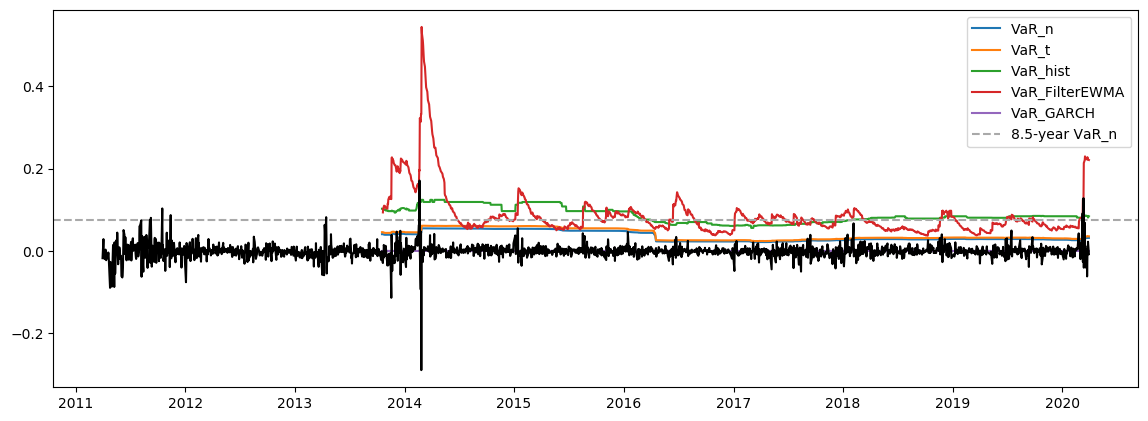

In [50]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
lLegend= list(df.columns[0::2])
lLegend.append("8.5-year VaR_n")
ten_year_normal = fnVaR_n(df_prices, weights, 0.01, 8, [True, 0.99], initial_investment)[0]


plt.figure(figsize=(14,5),dpi=100)
plt.plot_date(df.index, df.iloc[:,0::2], linestyle="-", markersize= 0)
plt.axhline(y=ten_year_normal, color= '#A9A9A9', linestyle= "--")
plt.plot_date(df_prices.index, -df_prices['portfolio_return'], linestyle="-", markersize= 0, color= 'k')
plt.legend(lLegend)

In [220]:
dfData = df_prices
dfVaR = df
def fnVaRwholeSample(dfVaR, dfData):
    '''
    purpose:
        check the VaR violations for each day for the whole sample
    input:
        dfVaR, dataframe with VaR
        dfData, dataframe of risk factors
    output:
        dfVaR_violation, dataframe with logicals for VaR violations
        True = violation
    '''
    dfVaR_violation= pd.DataFrame(np.zeros((len(dfVaR),4)))
    dfVaR_violation.index = dfVaR.index
    dfVaR_violation.columns= dfVaR.columns[0:-2:2]
    for i in range(4):
        dfVaR_violation.iloc[:,i]= dfData.iloc[-len(dfVaR):,-1] < -dfVaR.iloc[:,i*2]

    return dfVaR_violation

In [221]:
def fnVaRandESyearly(dfData, dfVaR_violation, dfVaR, alpha):
    '''
    purpose:
        calculate the average discrepancy between realized VaR and
        expected VaR for each year. Also, calculate the expected shortfall
        for each year.
    input:
        dfVaR_violation, dataframe of boolanes of VaR violations
        dfVaR, dataframe of VaR
        alpha, significance level
    output:
        dfVaR_violation_year, dataframe of results
    '''
   
    start_year= dfVaR_violation.index[0].year
    end_year= dfVaR_violation.index[-1].year
    # initialize df for output
    dfVaR_violation_year= pd.DataFrame(np.zeros((int(end_year+1)-int(start_year),11)))
    col1= list(dfVaR.columns)
    col1.append("Trading Days")
    dfVaR_violation_year.columns= col1
    dfVaR_violation_year.index= dfVaR_violation.index.to_period("A").unique()
    
    dfVaR_realized= pd.DataFrame(np.zeros((int(end_year+1)-int(start_year),6)))
    dfVaR_realized.columns= ["VaR_n", "VaR_t", "VaR_hist", "VaR_EWMA", "Expected", "Trading Days"]
    dfVaR_realized.index= dfVaR_violation.index.to_period("A").unique()
    
    
    for i, year in enumerate(range(start_year, end_year+1)):
        for type in range(4):
            # calculate VaR violations
            sample= dfVaR_violation[dfVaR_violation.index.year == year].iloc[:,type]
            realized= np.sum(sample)
            expected= len(sample) * alpha
            dfVaR_violation_year.iloc[i,2*type]= realized - expected
            dfVaR_violation_year.iloc[i,8]= len(sample)
            # store the realized and expected number of VaR violations
            dfVaR_realized.iloc[i,type]= realized
            dfVaR_realized.iloc[i,4]= expected
            dfVaR_realized.iloc[i,5]= len(sample)
            # calculate yearly shortfall
            ESsample= dfVaR_violation[dfVaR_violation.index.year == year]
                # select timeframe
            ReturnSample= dfData.loc[ESsample.index]
            #print(ReturnSample)
                # select losses where VaR was violated
            dailyES= -ReturnSample.iloc[:,5][ESsample.iloc[:,type]]
            dfVaR_violation_year.iloc[i,2*type+1]= np.mean(dailyES)
    
    return dfVaR_violation_year, dfVaR_realized

In [224]:
#dfVaR= fnRollingVaR(dfData, weights, alpha, 250, ewma_con, df)
#dfVaR.to_csv("Data/dfVaR_975.csv", index_label= "Date")

# read dfVaR and adjust index
#dfVaR= pd.read_csv("Data/dfVaR_975.csv", index_col= "Date")
alpha = 0.01
#df.index= df.index.to_datetime()

# check number of VaR violations for the whole sample
dfVaR_violation= fnVaRwholeSample(df, df_prices)
print(dfVaR_violation)

# check the number of VaR violations and the ES for each year
dfVaR_violation_year, dfVaR_realized= fnVaRandESyearly(df_prices, dfVaR_violation, df, alpha)


# create df with VaR on violation days
violationVaR= df[dfVaR_violation]

# save csv tables for VaR violations
#dfVaR_realized.to_csv("tables/dfVaR_realized_975.csv")
    # express ES in percentage terms
dfVaR_violation_year.iloc[:,1:-2:2]= dfVaR_violation_year.iloc[:,1::2]*100
dfVaR_violation_year= round(dfVaR_violation_year, 2)
#dfVaR_violation_year.to_csv("tables/VaR_violation_year_975.csv")

            VaR_n  VaR_t  VaR_hist  VaR_FilterEWMA
Date                                              
2013-10-18  False  False     False           False
2013-10-21  False  False     False           False
2013-10-22  False  False     False           False
2013-10-23  False  False     False           False
2013-10-24  False  False     False           False
...           ...    ...       ...             ...
2020-03-24  False  False     False           False
2020-03-25  False  False     False           False
2020-03-26  False  False     False           False
2020-03-27  False  False     False           False
2020-03-30  False  False     False           False

[1511 rows x 4 columns]


In [225]:
print(dfVaR_violation_year)

      VaR_n  ES_n  VaR_t   ES_t  VaR_hist  ES_hist  VaR_FilterEWMA  \
Date                                                                 
2013   1.53  4.79   1.53   4.79     -0.47      NaN           -0.47   
2014   0.68  9.37  -0.32  11.71     -1.32    17.09           -2.32   
2015  -0.34  5.46  -2.34    NaN     -2.34      NaN           -2.34   
2016   0.64  2.90  -0.36   3.12     -2.36      NaN           -2.36   
2017   1.61  2.89  -0.39   3.44     -2.39      NaN           -2.39   
2018   4.64  3.81   1.64   4.45     -2.36      NaN           -2.36   
2019   1.68  3.57  -0.32   4.15     -2.32      NaN           -2.32   
2020   4.45  7.18   3.45   8.27      1.45    10.97            1.45   

      ES_FilterEWMA  VaR_GARCH  ES_GARCH  Trading Days  
Date                                                    
2013            NaN       47.0       0.0           0.0  
2014            NaN      232.0       0.0           0.0  
2015            NaN      234.0       0.0           0.0  
2016          

In [226]:
print(dfVaR_realized)

      VaR_n  VaR_t  VaR_hist  VaR_EWMA  Expected  Trading Days
Date                                                          
2013    2.0    2.0       0.0       0.0      0.47          47.0
2014    3.0    2.0       1.0       0.0      2.32         232.0
2015    2.0    0.0       0.0       0.0      2.34         234.0
2016    3.0    2.0       0.0       0.0      2.36         236.0
2017    4.0    2.0       0.0       0.0      2.39         239.0
2018    7.0    4.0       0.0       0.0      2.36         236.0
2019    4.0    2.0       0.0       0.0      2.32         232.0
2020    5.0    4.0       2.0       2.0      0.55          55.0


In [227]:
# print VaR violations for whole time period
print("Normal: With alpha %.2f, the average number of violations is %.2f vs. %.2f expected." % (alpha, np.mean(dfVaR_realized.iloc[:,0]), np.mean(dfVaR_realized.iloc[:,4])))
print("Student-t: With alpha %.2f, the average number of violations is %.2f vs. %.2f expected" % (alpha, np.mean(dfVaR_realized.iloc[:,1]), np.mean(dfVaR_realized.iloc[:,4])))
print("Historical: With alpha %.2f, the average number of violations is %.2f vs. %.2f expected" % (alpha, np.mean(dfVaR_realized.iloc[:,2]), np.mean(dfVaR_realized.iloc[:,4])))
print("EWMA: With alpha %.2f, the average number of violations is %.2f vs. %.2f expected" % (alpha, np.mean(dfVaR_realized.iloc[:,3]), np.mean(dfVaR_realized.iloc[:,4])))

# average discrepancy of VaR violations (realized - expected)
print("Normal: With alpha %.2f, the average discrepancy is %.4f" % (alpha, np.mean(dfVaR_violation.iloc[:,0])))
print("Student-t: With alpha %.2f, the average discrepancy is %.4f" % (alpha, np.mean(dfVaR_violation.iloc[:,1])))
print("Historical: With alpha %.2f, the average discrepancy is %.4f" % (alpha, np.mean(dfVaR_violation.iloc[:,2])))
print("EWMA: With alpha %.2f, the average discrepancy is %.4f" % (alpha, np.mean(dfVaR_violation.iloc[:,3])))

Normal: With alpha 0.01, the average number of violations is 3.75 vs. 1.89 expected.
Student-t: With alpha 0.01, the average number of violations is 2.25 vs. 1.89 expected
Historical: With alpha 0.01, the average number of violations is 0.38 vs. 1.89 expected
EWMA: With alpha 0.01, the average number of violations is 0.25 vs. 1.89 expected
Normal: With alpha 0.01, the average discrepancy is 0.0199
Student-t: With alpha 0.01, the average discrepancy is 0.0119
Historical: With alpha 0.01, the average discrepancy is 0.0020
EWMA: With alpha 0.01, the average discrepancy is 0.0013


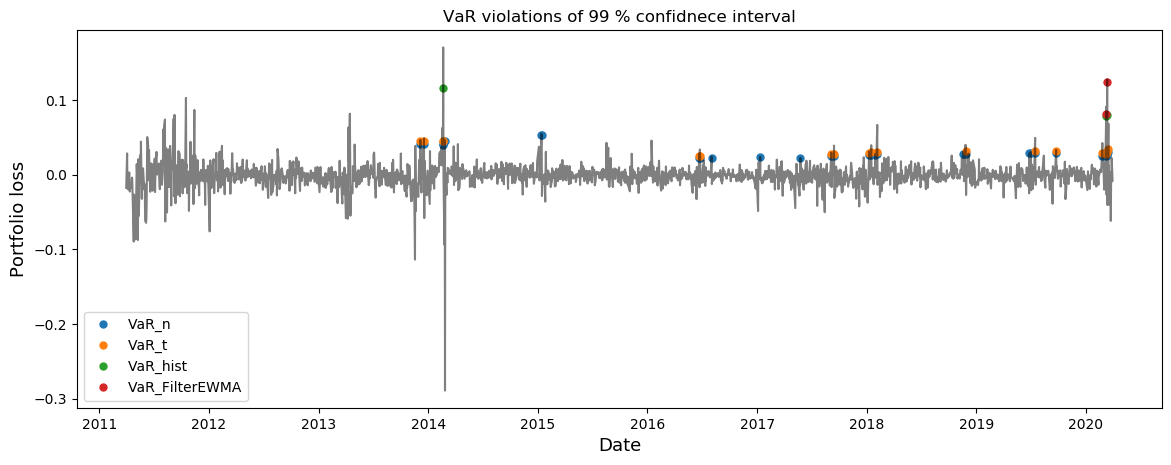

In [228]:
# plot with VaR violations
plt.figure(figsize=(14,5),dpi=100)
plt.plot_date(violationVaR.index, violationVaR.iloc[:,0:-2:2], markersize= 5)
plt.plot_date(dfData.index, -dfData.iloc[:,-1], linestyle="-", markersize= 0, color= 'k', alpha= 0.5)
plt.legend(dfVaR.columns[0:-2:2])
plt.xlabel('Date',fontsize=13)
plt.ylabel('Portfolio loss',fontsize=13)
plt.title('VaR violations of 99 % confidnece interval')
# plt.savefig('plots/violations.png', dpi=300)
plt.show()

In [137]:
df2 = fnRollingVaR(df_prices, df_prices2,weights, 0.025, 500, 0.94, 5,percent=[True,0.975])

( 97.5 %  VaR, ES) in percent is:  3.45 % 6.38 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  3.5 % 6.67 %
( 97.5 %  VaR, ES) in percent is:  6.45 % 8.55 %
(601, 7)


/home/isualice/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/isualice/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


( 97.5 %  VaR, ES) in percent is:  nan % nan %
( 97.5 %  VaR, ES) in percent is:  3.46 % 6.67 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  3.51 % 6.67 %
( 97.5 %  VaR, ES) in percent is:  6.45 % 8.55 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  6.34 % 9.33 %
( 97.5 %  VaR, ES) in percent is:  3.42 % 6.26 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  3.47 % 6.57 %
( 97.5 %  VaR, ES) in percent is:  6.4 % 8.81 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  6.89 % 10.21 %
( 97.5 %  VaR, ES) in percent is:  3.41 % 6.26 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  3.46 % 6.57 %
( 97.5 %  VaR, ES) in percent is:  6.4 % 8.81 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  6.81 % 10.15 %
( 97.5 %  VaR, ES) in percent is:  3.41 % 6.26 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  3.46 % 6.57 %
( 97.5 %  VaR, ES) in percent is:  6.39 % 8.81 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  7.18 % 10.75 %
( 97.5 %  VaR, ES) in percent is:  3.35 % 6.06 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  3.4 % 6.06 %
( 97.

( 97.5 %  VaR, ES) in percent is:  12.12 % 18.46 %
( 97.5 %  VaR, ES) in percent is:  3.47 % 5.38 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  3.52 % 5.62 %
( 97.5 %  VaR, ES) in percent is:  5.92 % 7.74 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  12.71 % 19.32 %
( 97.5 %  VaR, ES) in percent is:  3.47 % 5.38 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  3.53 % 5.62 %
( 97.5 %  VaR, ES) in percent is:  5.92 % 7.74 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  12.48 % 18.95 %
( 97.5 %  VaR, ES) in percent is:  3.49 % 5.54 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  3.55 % 5.54 %
( 97.5 %  VaR, ES) in percent is:  6.01 % 7.74 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  13.46 % 20.42 %
( 97.5 %  VaR, ES) in percent is:  3.54 % 5.54 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  3.59 % 5.54 %
( 97.5 %  VaR, ES) in percent is:  6.01 % 7.74 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  14.41 % 21.95 %
( 97.5 %  VaR, ES) in percent is:  3.54 % 5.54 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  3.59 % 

( 97.5 %  VaR, ES) in percent is:  20.15 % 30.83 %
( 97.5 %  VaR, ES) in percent is:  3.8 % 6.46 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  3.86 % 6.46 %
( 97.5 %  VaR, ES) in percent is:  6.01 % 9.49 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  21.41 % 32.72 %
( 97.5 %  VaR, ES) in percent is:  3.81 % 6.3 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  3.87 % 6.3 %
( 97.5 %  VaR, ES) in percent is:  6.25 % 9.49 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  21.2 % 32.59 %
( 97.5 %  VaR, ES) in percent is:  4.65 % 7.18 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.72 % 8.01 %
( 97.5 %  VaR, ES) in percent is:  6.25 % 9.49 %
(601, 7)


/home/isualice/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: ComplexWarning: Casting complex values to real discards the imaginary part
/home/isualice/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: ComplexWarning: Casting complex values to real discards the imaginary part


( 97.5 %  VaR, ES) in percent is:  34.46 % 53.19 %
( 97.5 %  VaR, ES) in percent is:  4.65 % 7.18 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.72 % 8.01 %
( 97.5 %  VaR, ES) in percent is:  6.25 % 9.49 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  33.53 % 51.68 %
( 97.5 %  VaR, ES) in percent is:  4.65 % 7.18 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.72 % 8.01 %
( 97.5 %  VaR, ES) in percent is:  6.25 % 9.49 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  32.15 % 49.89 %
( 97.5 %  VaR, ES) in percent is:  4.66 % 7.18 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.73 % 8.01 %
( 97.5 %  VaR, ES) in percent is:  6.25 % 9.49 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  31.61 % 48.82 %
( 97.5 %  VaR, ES) in percent is:  4.66 % 7.18 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.73 % 8.01 %
( 97.5 %  VaR, ES) in percent is:  6.01 % 9.49 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  30.68 % 47.36 %
( 97.5 %  VaR, ES) in percent is:  4.66 % 7.18 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.73 % 

( 97.5 %  VaR, ES) in percent is:  12.07 % 19.42 %
( 97.5 %  VaR, ES) in percent is:  4.62 % 7.18 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.69 % 8.01 %
( 97.5 %  VaR, ES) in percent is:  5.77 % 9.49 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  11.91 % 19.13 %
( 97.5 %  VaR, ES) in percent is:  4.62 % 7.18 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.69 % 8.01 %
( 97.5 %  VaR, ES) in percent is:  5.77 % 9.49 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  11.55 % 18.57 %
( 97.5 %  VaR, ES) in percent is:  4.62 % 7.18 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.69 % 8.01 %
( 97.5 %  VaR, ES) in percent is:  5.77 % 9.49 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  11.37 % 18.36 %
( 97.5 %  VaR, ES) in percent is:  4.61 % 7.18 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.68 % 7.18 %
( 97.5 %  VaR, ES) in percent is:  5.77 % 9.49 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  11.08 % 17.84 %
( 97.5 %  VaR, ES) in percent is:  4.61 % 7.18 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.68 % 

( 97.5 %  VaR, ES) in percent is:  5.07 % 7.5 %
( 97.5 %  VaR, ES) in percent is:  4.63 % 7.18 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.7 % 8.01 %
( 97.5 %  VaR, ES) in percent is:  5.58 % 9.49 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  5.1 % 7.46 %
( 97.5 %  VaR, ES) in percent is:  4.63 % 7.18 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.7 % 8.01 %
( 97.5 %  VaR, ES) in percent is:  5.58 % 9.49 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  4.92 % 7.33 %
( 97.5 %  VaR, ES) in percent is:  4.63 % 7.18 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.7 % 8.01 %
( 97.5 %  VaR, ES) in percent is:  5.58 % 9.49 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  4.78 % 7.09 %
( 97.5 %  VaR, ES) in percent is:  4.63 % 7.18 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.7 % 8.01 %
( 97.5 %  VaR, ES) in percent is:  5.58 % 9.49 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  4.6 % 6.85 %
( 97.5 %  VaR, ES) in percent is:  4.63 % 7.18 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.7 % 8.01 %
( 97.5 %  V

( 97.5 %  VaR, ES) in percent is:  4.38 % 7.28 %
( 97.5 %  VaR, ES) in percent is:  4.61 % 7.18 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.68 % 7.18 %
( 97.5 %  VaR, ES) in percent is:  5.79 % 9.49 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  4.27 % 7.17 %
( 97.5 %  VaR, ES) in percent is:  4.61 % 7.18 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.68 % 7.18 %
( 97.5 %  VaR, ES) in percent is:  5.79 % 9.49 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  4.19 % 7.01 %
( 97.5 %  VaR, ES) in percent is:  4.6 % 7.18 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.67 % 7.18 %
( 97.5 %  VaR, ES) in percent is:  5.79 % 9.49 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  4.17 % 6.85 %
( 97.5 %  VaR, ES) in percent is:  4.6 % 7.18 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.67 % 7.18 %
( 97.5 %  VaR, ES) in percent is:  5.79 % 9.49 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  3.97 % 6.63 %
( 97.5 %  VaR, ES) in percent is:  4.6 % 7.18 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.67 % 7.18 %
( 97.5

( 97.5 %  VaR, ES) in percent is:  5.95 % 9.89 %
( 97.5 %  VaR, ES) in percent is:  4.53 % 7.18 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.6 % 7.18 %
( 97.5 %  VaR, ES) in percent is:  6.01 % 9.49 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  5.82 % 9.49 %
( 97.5 %  VaR, ES) in percent is:  4.53 % 7.18 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.6 % 7.18 %
( 97.5 %  VaR, ES) in percent is:  6.0 % 9.49 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  5.66 % 9.25 %
( 97.5 %  VaR, ES) in percent is:  4.53 % 7.18 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.6 % 7.18 %
( 97.5 %  VaR, ES) in percent is:  6.0 % 9.49 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  5.59 % 9.11 %
( 97.5 %  VaR, ES) in percent is:  4.53 % 7.18 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.6 % 7.18 %
( 97.5 %  VaR, ES) in percent is:  6.23 % 9.49 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  5.75 % 9.39 %
( 97.5 %  VaR, ES) in percent is:  4.52 % 7.18 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.59 % 7.18 %
( 97.5 % 

( 97.5 %  VaR, ES) in percent is:  5.37 % 8.8 %
( 97.5 %  VaR, ES) in percent is:  4.51 % 7.18 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.58 % 7.18 %
( 97.5 %  VaR, ES) in percent is:  5.67 % 9.49 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  5.23 % 8.65 %
( 97.5 %  VaR, ES) in percent is:  4.51 % 7.18 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.58 % 7.18 %
( 97.5 %  VaR, ES) in percent is:  5.6 % 9.49 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  5.43 % 8.92 %
( 97.5 %  VaR, ES) in percent is:  4.51 % 7.18 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.58 % 7.18 %
( 97.5 %  VaR, ES) in percent is:  5.67 % 9.49 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  5.52 % 9.0 %
( 97.5 %  VaR, ES) in percent is:  4.51 % 7.18 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.58 % 7.18 %
( 97.5 %  VaR, ES) in percent is:  5.82 % 9.49 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  6.59 % 10.88 %
( 97.5 %  VaR, ES) in percent is:  4.51 % 7.18 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.58 % 7.18 %
( 97.

( 97.5 %  VaR, ES) in percent is:  6.47 % 11.1 %
( 97.5 %  VaR, ES) in percent is:  4.58 % 6.83 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.65 % 6.83 %
( 97.5 %  VaR, ES) in percent is:  6.18 % 9.49 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  6.64 % 11.4 %
( 97.5 %  VaR, ES) in percent is:  4.58 % 6.83 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.65 % 6.83 %
( 97.5 %  VaR, ES) in percent is:  6.18 % 9.49 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  6.44 % 11.09 %
( 97.5 %  VaR, ES) in percent is:  4.57 % 6.83 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.64 % 6.83 %
( 97.5 %  VaR, ES) in percent is:  6.18 % 9.49 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  6.25 % 10.86 %
( 97.5 %  VaR, ES) in percent is:  4.57 % 6.83 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.64 % 6.83 %
( 97.5 %  VaR, ES) in percent is:  6.18 % 9.49 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  6.11 % 10.53 %
( 97.5 %  VaR, ES) in percent is:  4.57 % 6.83 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.64 % 6.83 %


( 97.5 %  VaR, ES) in percent is:  4.01 % 7.18 %
( 97.5 %  VaR, ES) in percent is:  4.49 % 6.83 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.56 % 6.83 %
( 97.5 %  VaR, ES) in percent is:  6.33 % 9.49 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  3.86 % 6.99 %
( 97.5 %  VaR, ES) in percent is:  4.49 % 6.83 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.56 % 6.83 %
( 97.5 %  VaR, ES) in percent is:  6.33 % 9.49 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  4.09 % 7.38 %
( 97.5 %  VaR, ES) in percent is:  4.49 % 6.83 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.56 % 6.83 %
( 97.5 %  VaR, ES) in percent is:  6.25 % 9.49 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  4.07 % 7.26 %
( 97.5 %  VaR, ES) in percent is:  4.49 % 6.83 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.56 % 6.83 %
( 97.5 %  VaR, ES) in percent is:  6.25 % 9.49 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  4.05 % 7.23 %
( 97.5 %  VaR, ES) in percent is:  4.49 % 6.83 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.56 % 6.83 %
( 9

( 97.5 %  VaR, ES) in percent is:  4.01 % 6.82 %
( 97.5 %  VaR, ES) in percent is:  4.14 % 6.94 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.21 % 6.94 %
( 97.5 %  VaR, ES) in percent is:  5.6 % 11.71 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  4.03 % 6.88 %
( 97.5 %  VaR, ES) in percent is:  4.15 % 6.94 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.21 % 6.94 %
( 97.5 %  VaR, ES) in percent is:  5.6 % 11.71 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  4.19 % 6.95 %
( 97.5 %  VaR, ES) in percent is:  4.15 % 6.94 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.21 % 6.94 %
( 97.5 %  VaR, ES) in percent is:  5.52 % 11.71 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  4.25 % 6.97 %
( 97.5 %  VaR, ES) in percent is:  4.14 % 6.94 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.21 % 6.94 %
( 97.5 %  VaR, ES) in percent is:  5.52 % 11.71 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  4.62 % 7.63 %
( 97.5 %  VaR, ES) in percent is:  4.14 % 6.94 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.21 % 6.94 %
(

( 97.5 %  VaR, ES) in percent is:  7.88 % 13.52 %
( 97.5 %  VaR, ES) in percent is:  4.15 % 6.61 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.21 % 6.61 %
( 97.5 %  VaR, ES) in percent is:  4.98 % 8.59 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  7.89 % 13.49 %
( 97.5 %  VaR, ES) in percent is:  4.15 % 6.61 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.22 % 6.61 %
( 97.5 %  VaR, ES) in percent is:  4.98 % 8.59 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  7.89 % 13.43 %
( 97.5 %  VaR, ES) in percent is:  4.14 % 6.61 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.21 % 6.61 %
( 97.5 %  VaR, ES) in percent is:  4.98 % 8.59 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  7.84 % 13.31 %
( 97.5 %  VaR, ES) in percent is:  4.14 % 6.61 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.2 % 6.61 %
( 97.5 %  VaR, ES) in percent is:  4.98 % 8.59 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  7.67 % 13.02 %
( 97.5 %  VaR, ES) in percent is:  4.13 % 6.61 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.2 % 6.61 %


( 97.5 %  VaR, ES) in percent is:  4.82 % 7.95 %
( 97.5 %  VaR, ES) in percent is:  4.12 % 6.33 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.19 % 6.61 %
( 97.5 %  VaR, ES) in percent is:  4.76 % 7.85 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  4.81 % 7.92 %
( 97.5 %  VaR, ES) in percent is:  4.13 % 6.61 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.19 % 6.61 %
( 97.5 %  VaR, ES) in percent is:  4.7 % 7.85 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  4.75 % 7.92 %
( 97.5 %  VaR, ES) in percent is:  4.13 % 6.61 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.19 % 6.61 %
( 97.5 %  VaR, ES) in percent is:  4.7 % 7.85 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  4.73 % 7.9 %
( 97.5 %  VaR, ES) in percent is:  4.13 % 6.61 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.2 % 6.61 %
( 97.5 %  VaR, ES) in percent is:  4.68 % 6.94 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  4.8 % 8.19 %
( 97.5 %  VaR, ES) in percent is:  4.13 % 6.61 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.2 % 6.61 %
( 97.5 % 

( 97.5 %  VaR, ES) in percent is:  5.71 % 10.68 %
( 97.5 %  VaR, ES) in percent is:  4.1 % 6.33 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.17 % 6.61 %
( 97.5 %  VaR, ES) in percent is:  4.9 % 8.59 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  5.85 % 11.07 %
( 97.5 %  VaR, ES) in percent is:  4.09 % 6.33 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.15 % 6.61 %
( 97.5 %  VaR, ES) in percent is:  4.9 % 8.59 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  5.74 % 10.87 %
( 97.5 %  VaR, ES) in percent is:  4.08 % 6.33 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.15 % 6.61 %
( 97.5 %  VaR, ES) in percent is:  4.9 % 8.59 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  5.57 % 10.58 %
( 97.5 %  VaR, ES) in percent is:  4.07 % 6.33 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.14 % 6.61 %
( 97.5 %  VaR, ES) in percent is:  4.9 % 8.59 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  5.64 % 10.55 %
( 97.5 %  VaR, ES) in percent is:  4.05 % 6.33 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  4.12 % 6.33 %
( 9

( 97.5 %  VaR, ES) in percent is:  5.74 % 10.15 %
( 97.5 %  VaR, ES) in percent is:  3.68 % 5.96 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  3.74 % 5.96 %
( 97.5 %  VaR, ES) in percent is:  4.17 % 6.84 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  5.61 % 9.92 %
( 97.5 %  VaR, ES) in percent is:  3.68 % 5.96 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  3.74 % 5.96 %
( 97.5 %  VaR, ES) in percent is:  4.17 % 6.84 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  5.54 % 9.74 %
( 97.5 %  VaR, ES) in percent is:  3.69 % 5.96 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  3.75 % 5.96 %
( 97.5 %  VaR, ES) in percent is:  4.17 % 6.84 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  5.74 % 9.98 %
( 97.5 %  VaR, ES) in percent is:  3.69 % 5.96 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  3.75 % 5.96 %
( 97.5 %  VaR, ES) in percent is:  4.32 % 7.27 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  5.85 % 10.13 %
( 97.5 %  VaR, ES) in percent is:  3.68 % 5.96 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  3.74 % 5.96 %
(

( 97.5 %  VaR, ES) in percent is:  3.8 % 6.07 %
( 97.5 %  VaR, ES) in percent is:  1.94 % 3.42 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  1.97 % 3.52 %
( 97.5 %  VaR, ES) in percent is:  3.94 % 4.78 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  3.99 % 6.5 %
( 97.5 %  VaR, ES) in percent is:  1.94 % 3.42 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  1.97 % 3.52 %
( 97.5 %  VaR, ES) in percent is:  3.94 % 4.78 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  4.01 % 6.49 %
( 97.5 %  VaR, ES) in percent is:  1.94 % 3.42 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  1.97 % 3.52 %
( 97.5 %  VaR, ES) in percent is:  3.94 % 4.78 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  3.99 % 6.42 %
( 97.5 %  VaR, ES) in percent is:  1.94 % 3.42 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  1.97 % 3.52 %
( 97.5 %  VaR, ES) in percent is:  3.94 % 4.78 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  4.08 % 6.63 %
( 97.5 %  VaR, ES) in percent is:  1.94 % 3.42 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  1.97 % 3.52 %
( 97.

( 97.5 %  VaR, ES) in percent is:  8.28 % 14.48 %
( 97.5 %  VaR, ES) in percent is:  1.96 % 3.31 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  1.99 % 3.64 %
( 97.5 %  VaR, ES) in percent is:  3.9 % 4.95 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  8.11 % 14.15 %
( 97.5 %  VaR, ES) in percent is:  1.96 % 3.31 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  1.99 % 3.64 %
( 97.5 %  VaR, ES) in percent is:  3.9 % 4.95 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  7.99 % 13.93 %
( 97.5 %  VaR, ES) in percent is:  1.97 % 3.31 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.0 % 3.64 %
( 97.5 %  VaR, ES) in percent is:  3.9 % 4.95 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  7.89 % 13.74 %
( 97.5 %  VaR, ES) in percent is:  1.97 % 3.31 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.0 % 3.64 %
( 97.5 %  VaR, ES) in percent is:  3.9 % 4.95 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  7.67 % 13.3 %
( 97.5 %  VaR, ES) in percent is:  1.96 % 3.31 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  1.99 % 3.64 %
( 97.

( 97.5 %  VaR, ES) in percent is:  4.37 % 7.65 %
( 97.5 %  VaR, ES) in percent is:  1.94 % 3.33 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  1.97 % 3.43 %
( 97.5 %  VaR, ES) in percent is:  3.91 % 4.95 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  4.24 % 7.52 %
( 97.5 %  VaR, ES) in percent is:  1.94 % 3.33 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  1.97 % 3.43 %
( 97.5 %  VaR, ES) in percent is:  3.91 % 4.95 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  4.27 % 7.29 %
( 97.5 %  VaR, ES) in percent is:  1.94 % 3.33 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  1.97 % 3.43 %
( 97.5 %  VaR, ES) in percent is:  3.91 % 4.95 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  4.3 % 7.26 %
( 97.5 %  VaR, ES) in percent is:  1.94 % 3.33 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  1.97 % 3.43 %
( 97.5 %  VaR, ES) in percent is:  3.91 % 4.95 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  4.07 % 7.2 %
( 97.5 %  VaR, ES) in percent is:  1.94 % 3.33 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  1.97 % 3.33 %
( 97.

( 97.5 %  VaR, ES) in percent is:  2.51 % 4.1 %
( 97.5 %  VaR, ES) in percent is:  1.94 % 3.33 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  1.97 % 3.33 %
( 97.5 %  VaR, ES) in percent is:  3.74 % 4.71 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  2.46 % 4.1 %
( 97.5 %  VaR, ES) in percent is:  1.94 % 3.33 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  1.97 % 3.33 %
( 97.5 %  VaR, ES) in percent is:  3.74 % 4.71 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  2.5 % 4.17 %
( 97.5 %  VaR, ES) in percent is:  1.94 % 3.33 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  1.97 % 3.43 %
( 97.5 %  VaR, ES) in percent is:  3.74 % 4.71 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  2.45 % 4.03 %
( 97.5 %  VaR, ES) in percent is:  1.93 % 3.33 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  1.96 % 3.33 %
( 97.5 %  VaR, ES) in percent is:  3.74 % 4.71 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  2.38 % 3.96 %
( 97.5 %  VaR, ES) in percent is:  1.93 % 3.33 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  1.96 % 3.33 %
( 97.5

( 97.5 %  VaR, ES) in percent is:  2.62 % 4.29 %
( 97.5 %  VaR, ES) in percent is:  1.92 % 3.24 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  1.95 % 3.33 %
( 97.5 %  VaR, ES) in percent is:  3.51 % 4.53 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  2.67 % 4.39 %
( 97.5 %  VaR, ES) in percent is:  1.93 % 3.33 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  1.96 % 3.33 %
( 97.5 %  VaR, ES) in percent is:  3.51 % 4.53 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  3.06 % 5.17 %
( 97.5 %  VaR, ES) in percent is:  1.93 % 3.33 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  1.96 % 3.33 %
( 97.5 %  VaR, ES) in percent is:  3.51 % 4.53 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  3.13 % 5.31 %
( 97.5 %  VaR, ES) in percent is:  1.93 % 3.33 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  1.96 % 3.33 %
( 97.5 %  VaR, ES) in percent is:  3.51 % 4.53 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  3.11 % 5.34 %
( 97.5 %  VaR, ES) in percent is:  1.93 % 3.33 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  1.96 % 3.33 %
( 9

( 97.5 %  VaR, ES) in percent is:  4.8 % 7.97 %
( 97.5 %  VaR, ES) in percent is:  1.96 % 3.24 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  1.99 % 3.44 %
( 97.5 %  VaR, ES) in percent is:  3.41 % 4.69 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  4.76 % 7.9 %
( 97.5 %  VaR, ES) in percent is:  1.91 % 3.0 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  1.94 % 3.08 %
( 97.5 %  VaR, ES) in percent is:  3.39 % 4.26 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  4.66 % 7.72 %
( 97.5 %  VaR, ES) in percent is:  1.86 % 2.77 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  1.88 % 2.77 %
( 97.5 %  VaR, ES) in percent is:  3.35 % 3.98 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  4.58 % 7.6 %
( 97.5 %  VaR, ES) in percent is:  1.85 % 2.77 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  1.87 % 2.77 %
( 97.5 %  VaR, ES) in percent is:  3.35 % 3.98 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  4.69 % 7.74 %
( 97.5 %  VaR, ES) in percent is:  1.85 % 2.77 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  1.87 % 2.77 %
( 97.5 

( 97.5 %  VaR, ES) in percent is:  4.21 % 7.14 %
( 97.5 %  VaR, ES) in percent is:  1.83 % 2.66 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  1.86 % 2.66 %
( 97.5 %  VaR, ES) in percent is:  3.48 % 4.17 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  4.49 % 7.54 %
( 97.5 %  VaR, ES) in percent is:  1.83 % 2.66 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  1.86 % 2.66 %
( 97.5 %  VaR, ES) in percent is:  3.48 % 4.17 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  4.33 % 7.35 %
( 97.5 %  VaR, ES) in percent is:  1.83 % 2.66 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  1.86 % 2.66 %
( 97.5 %  VaR, ES) in percent is:  3.48 % 4.17 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  4.27 % 7.26 %
( 97.5 %  VaR, ES) in percent is:  1.83 % 2.66 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  1.86 % 2.66 %
( 97.5 %  VaR, ES) in percent is:  3.48 % 4.17 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  4.22 % 7.13 %
( 97.5 %  VaR, ES) in percent is:  1.83 % 2.66 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  1.86 % 2.66 %
( 9

( 97.5 %  VaR, ES) in percent is:  4.65 % 7.93 %
( 97.5 %  VaR, ES) in percent is:  1.95 % 2.78 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  1.98 % 2.92 %
( 97.5 %  VaR, ES) in percent is:  3.61 % 4.17 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  4.48 % 7.69 %
( 97.5 %  VaR, ES) in percent is:  1.95 % 2.78 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  1.98 % 2.92 %
( 97.5 %  VaR, ES) in percent is:  3.61 % 4.17 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  4.35 % 7.51 %
( 97.5 %  VaR, ES) in percent is:  1.95 % 2.78 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  1.98 % 2.92 %
( 97.5 %  VaR, ES) in percent is:  3.68 % 4.44 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  4.64 % 8.06 %
( 97.5 %  VaR, ES) in percent is:  1.96 % 2.78 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  1.99 % 2.92 %
( 97.5 %  VaR, ES) in percent is:  3.68 % 4.44 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  4.59 % 7.89 %
( 97.5 %  VaR, ES) in percent is:  1.96 % 2.78 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  1.99 % 2.92 %
( 9

( 97.5 %  VaR, ES) in percent is:  5.05 % 8.02 %
( 97.5 %  VaR, ES) in percent is:  2.08 % 3.1 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.11 % 3.1 %
( 97.5 %  VaR, ES) in percent is:  3.74 % 4.44 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  4.97 % 7.88 %
( 97.5 %  VaR, ES) in percent is:  2.08 % 3.1 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.11 % 3.1 %
( 97.5 %  VaR, ES) in percent is:  3.74 % 4.44 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  4.9 % 7.75 %
( 97.5 %  VaR, ES) in percent is:  2.08 % 3.1 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.11 % 3.1 %
( 97.5 %  VaR, ES) in percent is:  3.74 % 4.44 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  4.74 % 7.52 %
( 97.5 %  VaR, ES) in percent is:  2.08 % 3.1 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.11 % 3.1 %
( 97.5 %  VaR, ES) in percent is:  3.74 % 4.44 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  4.62 % 7.32 %
( 97.5 %  VaR, ES) in percent is:  2.09 % 3.1 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.12 % 3.1 %
( 97.5 %  VaR,

( 97.5 %  VaR, ES) in percent is:  4.24 % 6.76 %
( 97.5 %  VaR, ES) in percent is:  2.14 % 3.08 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.17 % 3.08 %
( 97.5 %  VaR, ES) in percent is:  3.75 % 4.25 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  4.2 % 6.7 %
( 97.5 %  VaR, ES) in percent is:  2.14 % 3.08 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.17 % 3.08 %
( 97.5 %  VaR, ES) in percent is:  3.75 % 4.25 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  4.13 % 6.57 %
( 97.5 %  VaR, ES) in percent is:  2.14 % 3.08 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.17 % 3.08 %
( 97.5 %  VaR, ES) in percent is:  3.84 % 4.25 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  4.22 % 6.65 %
( 97.5 %  VaR, ES) in percent is:  2.14 % 3.08 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.18 % 3.08 %
( 97.5 %  VaR, ES) in percent is:  3.84 % 4.25 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  4.17 % 6.58 %
( 97.5 %  VaR, ES) in percent is:  2.14 % 3.08 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.18 % 3.08 %
( 97.

( 97.5 %  VaR, ES) in percent is:  5.72 % 9.28 %
( 97.5 %  VaR, ES) in percent is:  2.23 % 3.08 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.27 % 3.08 %
( 97.5 %  VaR, ES) in percent is:  3.94 % 4.59 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  5.7 % 9.24 %
( 97.5 %  VaR, ES) in percent is:  2.22 % 3.11 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.26 % 3.11 %
( 97.5 %  VaR, ES) in percent is:  3.94 % 4.59 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  5.72 % 9.27 %
( 97.5 %  VaR, ES) in percent is:  2.22 % 3.11 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.25 % 3.11 %
( 97.5 %  VaR, ES) in percent is:  3.94 % 4.59 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  5.64 % 9.14 %
( 97.5 %  VaR, ES) in percent is:  2.22 % 3.11 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.25 % 3.11 %
( 97.5 %  VaR, ES) in percent is:  3.95 % 4.59 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  5.54 % 8.99 %
( 97.5 %  VaR, ES) in percent is:  2.22 % 3.02 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.26 % 3.02 %
( 97

( 97.5 %  VaR, ES) in percent is:  6.6 % 10.45 %
( 97.5 %  VaR, ES) in percent is:  2.44 % 3.68 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.47 % 3.81 %
( 97.5 %  VaR, ES) in percent is:  4.53 % 5.64 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  6.47 % 10.25 %
( 97.5 %  VaR, ES) in percent is:  2.44 % 3.68 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.47 % 3.81 %
( 97.5 %  VaR, ES) in percent is:  4.62 % 6.69 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  6.38 % 10.1 %
( 97.5 %  VaR, ES) in percent is:  2.44 % 3.68 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.48 % 3.81 %
( 97.5 %  VaR, ES) in percent is:  4.62 % 6.69 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  6.24 % 9.89 %
( 97.5 %  VaR, ES) in percent is:  2.42 % 3.57 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.45 % 3.57 %
( 97.5 %  VaR, ES) in percent is:  4.53 % 6.69 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  6.12 % 9.7 %
( 97.5 %  VaR, ES) in percent is:  2.42 % 3.57 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.45 % 3.57 %
( 9

( 97.5 %  VaR, ES) in percent is:  4.62 % 7.18 %
( 97.5 %  VaR, ES) in percent is:  2.43 % 3.57 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.47 % 3.71 %
( 97.5 %  VaR, ES) in percent is:  5.07 % 6.69 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  4.5 % 6.98 %
( 97.5 %  VaR, ES) in percent is:  2.43 % 3.57 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.47 % 3.71 %
( 97.5 %  VaR, ES) in percent is:  5.07 % 6.69 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  4.49 % 7.01 %
( 97.5 %  VaR, ES) in percent is:  2.44 % 3.57 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.47 % 3.71 %
( 97.5 %  VaR, ES) in percent is:  5.07 % 6.69 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  4.42 % 6.91 %
( 97.5 %  VaR, ES) in percent is:  2.44 % 3.57 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.48 % 3.71 %
( 97.5 %  VaR, ES) in percent is:  5.07 % 6.69 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  4.54 % 7.1 %
( 97.5 %  VaR, ES) in percent is:  2.44 % 3.57 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.48 % 3.71 %
( 97.

( 97.5 %  VaR, ES) in percent is:  3.89 % 5.76 %
( 97.5 %  VaR, ES) in percent is:  2.45 % 3.57 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.48 % 3.71 %
( 97.5 %  VaR, ES) in percent is:  5.26 % 6.69 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  3.82 % 5.66 %
( 97.5 %  VaR, ES) in percent is:  2.44 % 3.57 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.48 % 3.71 %
( 97.5 %  VaR, ES) in percent is:  5.26 % 6.69 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  3.76 % 5.56 %
( 97.5 %  VaR, ES) in percent is:  2.44 % 3.57 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.48 % 3.71 %
( 97.5 %  VaR, ES) in percent is:  5.26 % 6.69 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  3.69 % 5.44 %
( 97.5 %  VaR, ES) in percent is:  2.45 % 3.57 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.48 % 3.71 %
( 97.5 %  VaR, ES) in percent is:  5.37 % 6.69 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  3.99 % 5.92 %
( 97.5 %  VaR, ES) in percent is:  2.45 % 3.57 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.48 % 3.71 %
( 9

( 97.5 %  VaR, ES) in percent is:  3.82 % 5.75 %
( 97.5 %  VaR, ES) in percent is:  2.38 % 3.41 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.41 % 3.7 %
( 97.5 %  VaR, ES) in percent is:  5.26 % 6.69 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  3.82 % 5.74 %
( 97.5 %  VaR, ES) in percent is:  2.37 % 3.41 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.41 % 3.54 %
( 97.5 %  VaR, ES) in percent is:  5.26 % 6.69 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  3.81 % 5.7 %
( 97.5 %  VaR, ES) in percent is:  2.37 % 3.41 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.41 % 3.54 %
( 97.5 %  VaR, ES) in percent is:  5.26 % 6.69 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  3.72 % 5.59 %
( 97.5 %  VaR, ES) in percent is:  2.37 % 3.41 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.41 % 3.54 %
( 97.5 %  VaR, ES) in percent is:  5.26 % 6.69 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  3.68 % 5.53 %
( 97.5 %  VaR, ES) in percent is:  2.37 % 3.41 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.41 % 3.54 %
( 97.

( 97.5 %  VaR, ES) in percent is:  3.53 % 5.05 %
( 97.5 %  VaR, ES) in percent is:  2.38 % 3.43 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.42 % 3.72 %
( 97.5 %  VaR, ES) in percent is:  5.2 % 6.69 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  3.63 % 5.21 %
( 97.5 %  VaR, ES) in percent is:  2.38 % 3.43 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.42 % 3.72 %
( 97.5 %  VaR, ES) in percent is:  5.2 % 6.69 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  3.67 % 5.28 %
( 97.5 %  VaR, ES) in percent is:  2.38 % 3.43 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.42 % 3.72 %
( 97.5 %  VaR, ES) in percent is:  5.2 % 6.69 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  3.59 % 5.16 %
( 97.5 %  VaR, ES) in percent is:  2.38 % 3.43 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.42 % 3.72 %
( 97.5 %  VaR, ES) in percent is:  5.2 % 6.69 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  3.67 % 5.33 %
( 97.5 %  VaR, ES) in percent is:  2.39 % 3.43 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.42 % 3.72 %
( 97.5 

( 97.5 %  VaR, ES) in percent is:  5.84 % 8.59 %
( 97.5 %  VaR, ES) in percent is:  2.45 % 3.54 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.49 % 3.54 %
( 97.5 %  VaR, ES) in percent is:  5.87 % 6.69 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  5.8 % 8.55 %
( 97.5 %  VaR, ES) in percent is:  2.45 % 3.54 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.49 % 3.54 %
( 97.5 %  VaR, ES) in percent is:  5.74 % 6.69 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  5.81 % 8.52 %
( 97.5 %  VaR, ES) in percent is:  2.45 % 3.54 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.49 % 3.54 %
( 97.5 %  VaR, ES) in percent is:  5.74 % 6.69 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  5.72 % 8.16 %
( 97.5 %  VaR, ES) in percent is:  2.46 % 3.54 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.5 % 3.54 %
( 97.5 %  VaR, ES) in percent is:  5.74 % 6.69 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  5.86 % 8.69 %
( 97.5 %  VaR, ES) in percent is:  2.46 % 3.54 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.5 % 3.54 %
( 97.5

( 97.5 %  VaR, ES) in percent is:  4.04 % 5.77 %
( 97.5 %  VaR, ES) in percent is:  2.44 % 3.54 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.47 % 3.54 %
( 97.5 %  VaR, ES) in percent is:  5.74 % 6.69 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  3.94 % 5.6 %
( 97.5 %  VaR, ES) in percent is:  2.43 % 3.54 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.47 % 3.54 %
( 97.5 %  VaR, ES) in percent is:  5.74 % 6.69 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  3.84 % 5.47 %
( 97.5 %  VaR, ES) in percent is:  2.43 % 3.54 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.47 % 3.54 %
( 97.5 %  VaR, ES) in percent is:  5.74 % 6.69 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  3.75 % 5.35 %
( 97.5 %  VaR, ES) in percent is:  2.43 % 3.54 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.47 % 3.54 %
( 97.5 %  VaR, ES) in percent is:  5.74 % 6.69 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  3.73 % 5.32 %
( 97.5 %  VaR, ES) in percent is:  2.43 % 3.54 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.46 % 3.54 %
( 97

( 97.5 %  VaR, ES) in percent is:  3.58 % 5.02 %
( 97.5 %  VaR, ES) in percent is:  2.44 % 3.54 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.47 % 3.54 %
( 97.5 %  VaR, ES) in percent is:  5.37 % 6.69 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  3.48 % 4.88 %
( 97.5 %  VaR, ES) in percent is:  2.44 % 3.54 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.48 % 3.54 %
( 97.5 %  VaR, ES) in percent is:  5.22 % 6.69 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  3.39 % 4.76 %
( 97.5 %  VaR, ES) in percent is:  2.43 % 3.54 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.47 % 3.54 %
( 97.5 %  VaR, ES) in percent is:  5.22 % 6.69 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  3.32 % 4.66 %
( 97.5 %  VaR, ES) in percent is:  2.43 % 3.54 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.47 % 3.54 %
( 97.5 %  VaR, ES) in percent is:  5.22 % 6.69 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  3.32 % 4.62 %
( 97.5 %  VaR, ES) in percent is:  2.43 % 3.54 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.47 % 3.54 %
( 9

( 97.5 %  VaR, ES) in percent is:  4.91 % 6.74 %
( 97.5 %  VaR, ES) in percent is:  2.41 % 3.54 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.45 % 3.54 %
( 97.5 %  VaR, ES) in percent is:  5.11 % 6.69 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  5.03 % 6.91 %
( 97.5 %  VaR, ES) in percent is:  2.41 % 3.54 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.45 % 3.54 %
( 97.5 %  VaR, ES) in percent is:  5.11 % 6.69 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  5.08 % 6.98 %
( 97.5 %  VaR, ES) in percent is:  2.43 % 3.54 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.46 % 3.54 %
( 97.5 %  VaR, ES) in percent is:  5.08 % 6.69 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  5.3 % 7.31 %
( 97.5 %  VaR, ES) in percent is:  2.43 % 3.49 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.47 % 3.49 %
( 97.5 %  VaR, ES) in percent is:  5.11 % 6.69 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  5.83 % 8.06 %
( 97.5 %  VaR, ES) in percent is:  2.44 % 3.49 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.48 % 3.49 %
( 97

( 97.5 %  VaR, ES) in percent is:  5.7 % 7.96 %
( 97.5 %  VaR, ES) in percent is:  2.45 % 3.5 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.49 % 3.5 %
( 97.5 %  VaR, ES) in percent is:  5.45 % 6.69 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  5.7 % 7.96 %
( 97.5 %  VaR, ES) in percent is:  2.45 % 3.5 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.49 % 3.5 %
( 97.5 %  VaR, ES) in percent is:  5.45 % 6.69 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  5.56 % 7.75 %
( 97.5 %  VaR, ES) in percent is:  2.45 % 3.5 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.49 % 3.5 %
( 97.5 %  VaR, ES) in percent is:  5.37 % 6.69 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  5.59 % 7.79 %
( 97.5 %  VaR, ES) in percent is:  2.45 % 3.5 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.49 % 3.5 %
( 97.5 %  VaR, ES) in percent is:  5.37 % 6.69 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  5.52 % 7.66 %
( 97.5 %  VaR, ES) in percent is:  2.45 % 3.5 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.49 % 3.5 %
( 97.5 %  VaR, 

( 97.5 %  VaR, ES) in percent is:  4.46 % 6.28 %
( 97.5 %  VaR, ES) in percent is:  2.37 % 3.45 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.4 % 3.52 %
( 97.5 %  VaR, ES) in percent is:  5.11 % 6.69 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  4.7 % 6.71 %
( 97.5 %  VaR, ES) in percent is:  2.37 % 3.45 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.4 % 3.52 %
( 97.5 %  VaR, ES) in percent is:  5.11 % 6.69 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  4.6 % 6.53 %
( 97.5 %  VaR, ES) in percent is:  2.39 % 3.45 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.43 % 3.52 %
( 97.5 %  VaR, ES) in percent is:  5.08 % 6.69 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  5.2 % 7.43 %
( 97.5 %  VaR, ES) in percent is:  2.4 % 3.45 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.43 % 3.52 %
( 97.5 %  VaR, ES) in percent is:  5.08 % 6.69 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  5.19 % 7.43 %
( 97.5 %  VaR, ES) in percent is:  2.4 % 3.45 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.43 % 3.52 %
( 97.5 %  

( 97.5 %  VaR, ES) in percent is:  3.88 % 5.72 %
( 97.5 %  VaR, ES) in percent is:  2.29 % 3.35 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.33 % 3.35 %
( 97.5 %  VaR, ES) in percent is:  5.01 % 6.69 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  3.78 % 5.58 %
( 97.5 %  VaR, ES) in percent is:  2.29 % 3.35 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.32 % 3.35 %
( 97.5 %  VaR, ES) in percent is:  5.01 % 6.69 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  3.68 % 5.45 %
( 97.5 %  VaR, ES) in percent is:  2.29 % 3.35 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.33 % 3.35 %
( 97.5 %  VaR, ES) in percent is:  5.01 % 6.69 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  3.62 % 5.33 %
( 97.5 %  VaR, ES) in percent is:  2.29 % 3.35 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.32 % 3.35 %
( 97.5 %  VaR, ES) in percent is:  5.01 % 6.69 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  3.55 % 5.26 %
( 97.5 %  VaR, ES) in percent is:  2.29 % 3.35 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.32 % 3.35 %
( 9

( 97.5 %  VaR, ES) in percent is:  5.0 % 7.13 %
( 97.5 %  VaR, ES) in percent is:  2.17 % 3.34 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.2 % 3.34 %
( 97.5 %  VaR, ES) in percent is:  4.72 % 5.82 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  5.08 % 7.25 %
( 97.5 %  VaR, ES) in percent is:  2.16 % 3.22 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.19 % 3.28 %
( 97.5 %  VaR, ES) in percent is:  4.72 % 5.82 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  5.3 % 7.55 %
( 97.5 %  VaR, ES) in percent is:  2.15 % 3.23 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.18 % 3.29 %
( 97.5 %  VaR, ES) in percent is:  4.67 % 5.82 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  5.35 % 7.62 %
( 97.5 %  VaR, ES) in percent is:  2.16 % 3.23 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.19 % 3.29 %
( 97.5 %  VaR, ES) in percent is:  4.67 % 5.82 %
(601, 7)
( 97.5 %  VaR, ES) in percent is:  5.6 % 7.96 %
( 97.5 %  VaR, ES) in percent is:  2.16 % 3.23 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  2.19 % 3.29 %
( 97.5 

( 97.5 %  VaR, ES) in percent is:  6.57 % 9.97 %


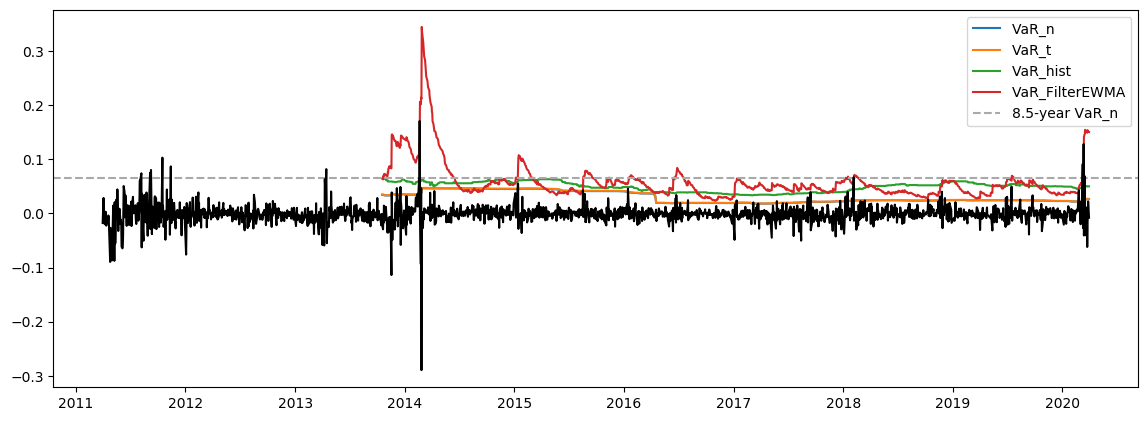

In [237]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
lLegend= list(df2.columns[0:-2:2])
lLegend.append("8.5-year VaR_n")
ten_year_normal = fnVaR_n(df_prices, weights, 0.025, 8, [True, 0.975], initial_investment)[0]

plt.figure(figsize=(14,5),dpi=100)
plt.plot_date(df2.index, df2.iloc[:,0:-2:2], linestyle="-", markersize= 0)
plt.axhline(ten_year_normal, color= '#A9A9A9', linestyle= "--")
plt.plot_date(df_prices.index, -df_prices['portfolio_return'], linestyle="-", markersize= 0, color= 'k')
plt.legend(lLegend)

In [143]:

df2VaR = df2

alpha = 0.025
#df2.index= df2.index.to_datetime()

# check number of VaR violations for the whole sample
df2VaR_violation= fnVaRwholeSample(df2, df_prices)
#print(df2VaR_violation)

# check the number of VaR violations and the ES for each year
df2VaR_violation_year, df2VaR_realized= fnVaRandESyearly(df_prices, df2VaR_violation, df2, alpha)


# create df2 with VaR on violation days
violationVaR= df2[df2VaR_violation]


df2VaR_violation_year.iloc[:,1:-2:2]= df2VaR_violation_year.iloc[:,1::2]*100
df2VaR_violation_year= round(df2VaR_violation_year, 2)


In [144]:
print(df2VaR_violation_year)

      VaR_n  ES_n  VaR_t  ES_t  VaR_hist  ES_hist  VaR_FilterEWMA  \
Date                                                                
2013   2.82  4.24   1.82  4.49     -1.18      NaN           -1.18   
2014  -1.80  7.94  -1.80  7.94     -3.80    11.71           -4.80   
2015  -2.85  5.07  -2.85  5.07     -5.85      NaN           -4.85   
2016  -1.90  3.32  -1.90  3.32     -5.90      NaN           -5.90   
2017   2.02  2.47   1.02  2.57     -5.98      NaN           -5.98   
2018   3.10  3.56   3.10  3.56     -4.90     6.69           -4.90   
2019  -0.80  3.37  -0.80  3.37     -5.80      NaN           -5.80   
2020   4.62  6.36   4.62  6.36      1.62     9.60            1.62   

      ES_FilterEWMA  VaR_GARCH  ES_GARCH  Trading Days  
Date                                                    
2013            NaN       47.0       0.0           0.0  
2014          17.09      232.0       0.0           0.0  
2015           4.29      234.0       0.0           0.0  
2016            NaN     

In [145]:
# print VaR violations for whole time period
print("Normal: With alpha %.2f, the average number of violations is %.2f vs. %.2f expected." % (alpha, np.mean(df2VaR_realized.iloc[:,0]), np.mean(df2VaR_realized.iloc[:,4])))
print("Student-t: With alpha %.2f, the average number of violations is %.2f vs. %.2f expected" % (alpha, np.mean(df2VaR_realized.iloc[:,1]), np.mean(df2VaR_realized.iloc[:,4])))
print("Historical: With alpha %.2f, the average number of violations is %.2f vs. %.2f expected" % (alpha, np.mean(df2VaR_realized.iloc[:,2]), np.mean(df2VaR_realized.iloc[:,4])))
print("EWMA: With alpha %.2f, the average number of violations is %.2f vs. %.2f expected" % (alpha, np.mean(df2VaR_realized.iloc[:,3]), np.mean(df2VaR_realized.iloc[:,4])))

# average discrepancy of VaR violations (realized - expected)
print("Normal: With alpha %.2f, the average discrepancy is %.4f" % (alpha, np.mean(df2VaR_violation.iloc[:,0])))
print("Student-t: With alpha %.2f, the average discrepancy is %.4f" % (alpha, np.mean(df2VaR_violation.iloc[:,1])))
print("Historical: With alpha %.2f, the average discrepancy is %.4f" % (alpha, np.mean(df2VaR_violation.iloc[:,2])))
print("EWMA: With alpha %.2f, the average discrepancy is %.4f" % (alpha, np.mean(df2VaR_violation.iloc[:,3])))

Normal: With alpha 0.03, the average number of violations is 5.38 vs. 4.72 expected.
Student-t: With alpha 0.03, the average number of violations is 5.12 vs. 4.72 expected
Historical: With alpha 0.03, the average number of violations is 0.75 vs. 4.72 expected
EWMA: With alpha 0.03, the average number of violations is 0.75 vs. 4.72 expected
Normal: With alpha 0.03, the average discrepancy is 0.0285
Student-t: With alpha 0.03, the average discrepancy is 0.0271
Historical: With alpha 0.03, the average discrepancy is 0.0040
EWMA: With alpha 0.03, the average discrepancy is 0.0040


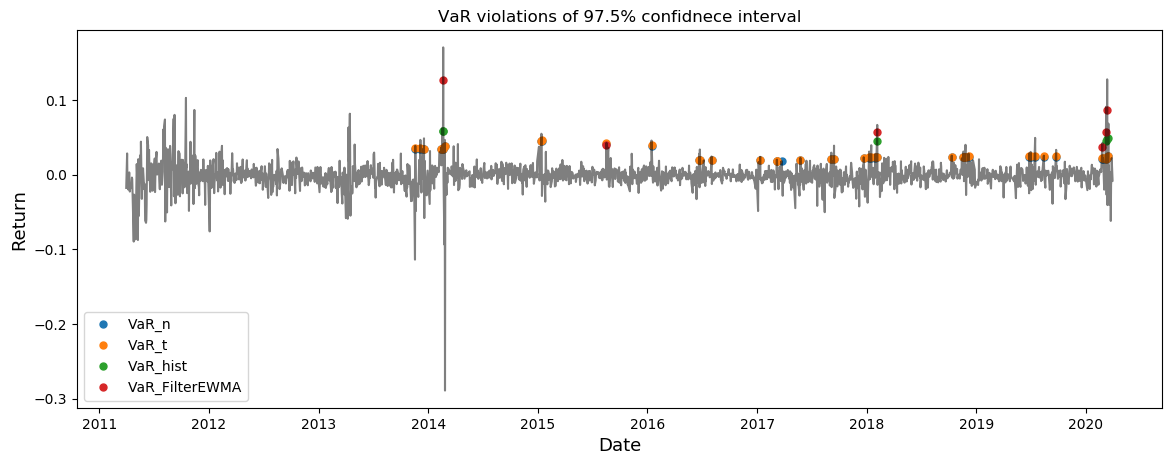

In [146]:
# plot with VaR violations
plt.figure(figsize=(14,5),dpi=100)
plt.plot_date(violationVaR.index, violationVaR.iloc[:,0:-2:2], markersize= 5)
plt.plot_date(dfData.index, -dfData.iloc[:,-1], linestyle="-", markersize= 0, color= 'k', alpha= 0.5)
plt.legend(df2VaR.columns[0:-2:2])
plt.xlabel('Date',fontsize=13)
plt.ylabel('Return',fontsize=13)
plt.title('VaR violations of 97.5% confidnece interval')
# plt.savefig('plots/violations.png', dpi=300)
plt.show()

### Empirical 5- and 10-days VaRs

In [229]:
initial_investment = 1000000
data = df_prices.iloc[1:,:]
lookback = len(data)
df = 5
# 5-day VaR
df5=   data.groupby(np.arange(len( data))//5).sum()
df5.index=  data.index[::5]
lookback5= lookback//5 # set lookback for 5 day VaR
# 10-day VaR   
df10=  data.groupby(np.arange(len( data))//10).sum()
df10.index=  data.index[::10]
lookback10= lookback//10 # set lookback for 10 day VaR

Methods= ["Normal", "Student-t", "Historical"]
Cols= ["5d_99","sq5d_99","10d_99","sq10d_99","5d_975","sq5d_975","10d_975","sq10d_975"]
dfEmpirical= pd.DataFrame(np.zeros((len(Methods),len(Cols))), index = Methods, columns= Cols)

alpha_x= np.array([0.01,0.025 ])                                  # Different confidences
lookback_x= np.array([lookback5, lookback, lookback10, lookback])   # Compare with sqrt time
df1=  data.copy()
dfx= pd.DataFrame([df5, df1, df10, df1])
print(dfx.iloc[1:0])
for i in range(len(alpha_x)):
    percent = [True,1-alpha_x[i]] 
    for j in range(len(lookback_x)):
        dfEmpirical.iloc[0,j+4*i], null= fnVaR_n(dfx.iloc[j,0], weights, alpha_x[i], lookback_x[j], percent,initial_investment)
        dfEmpirical.iloc[1,j+4*i], null= fnVaR_t(dfx.iloc[j,0], weights, lookback_x[j],df, alpha_x[i], percent, initial_investment)
        dfEmpirical.iloc[2,j+4*i], null= fnVaR_hist(dfx.iloc[j,0], weights, alpha_x[i], lookback_x[j], percent,initial_investment)
        #dfEmpirical.iloc[3,j+4*i], null= fnVaR_EWMA(dfx.iloc[j,0], weights, ewma_con, alpha_x[i], lookback_x[j], percent)
        if j == 1:
            dfEmpirical.iloc[:,j+4*i]= dfEmpirical.iloc[:,j+4*i]*np.sqrt(5)
        elif j == 3:
            dfEmpirical.iloc[:,j+4*i]= dfEmpirical.iloc[:,j+4*i]*np.sqrt(10)
# Convert output based on whether its df_prices.iloc[1:,:] or portfolio value
if percent[0] == False:
    dfEmpirical= (dfEmpirical*initial_investment).round(-1).astype(int)
else:
    dfEmpirical= (dfEmpirical*100).round(2)  
#dfEmpirical.to_csv("Tables/dfEmpiricalPercentages.csv", index_label= "Method")

Empty DataFrame
Columns: [0]
Index: []
( 99.0 %  VaR, ES) in percent is:  10.11 % 14.75 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  11.28 % 16.05 %
( 99.0 %  VaR, ES) in percent is:  21.47 % 23.4 %
( 99.0 %  VaR, ES) in percent is:  4.05 % 6.62 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  4.53 % 7.21 %
( 99.0 %  VaR, ES) in percent is:  9.72 % 13.4 %
( 99.0 %  VaR, ES) in percent is:  15.7 % 27.01 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  17.51 % 27.01 %
( 99.0 %  VaR, ES) in percent is:  30.87 % nan %
( 99.0 %  VaR, ES) in percent is:  4.05 % 6.62 %
DF= 5
( 99.0 %  VaR, ES) in percent is:  4.53 % 7.21 %
( 99.0 %  VaR, ES) in percent is:  9.72 % 13.4 %
( 97.5 %  VaR, ES) in percent is:  8.57 % 13.2 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  8.7 % 13.2 %
( 97.5 %  VaR, ES) in percent is:  13.0 % 16.74 %
( 97.5 %  VaR, ES) in percent is:  3.42 % 5.63 %
DF= 5
( 97.5 %  VaR, ES) in percent is:  3.48 % 5.73 %
( 97.5 %  VaR, ES) in percent is:  5.6 % 8.53 %
( 97.5 %  VaR, ES) in percent is:  1

/home/isualice/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/isualice/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [230]:
dfEmpirical

,5d_99,sq5d_99,10d_99,sq10d_99,5d_975,sq5d_975,10d_975,sq10d_975
Normal,10.11,9.06,15.70,12.81,8.57,7.66,13.33,10.83
Student-t,11.28,10.13,17.51,14.33,8.70,7.78,13.53,11.00
Historical,21.47,21.74,30.87,30.75,13.00,12.53,18.37,17.72


**12.04 Pan**<br>
The histogram and QQ-plot are not functioning due to some undefined functions, maybe you can have a look :) <br> **AM**: fixed <br>
I still left out the bond one, you can add it into it!
I added the price return and exchange rate return together to form a new return which includes the FX exposure,
and I think it's correct. If it's wrong please let me know! <br> **13.04 AM:**:  <br> 
1/FX seems correct to me (I see you used the formula from the last lecture) <br>
2/About the bond - fixed some issues to integrate the data with the rest of the datasets. For now, I calculated the return as simple difference between current and lagged price. We can add to our list of questions to see if we should do it differently.. <br>
3/Added EWMA <br>
3/Added some plots <br>
4/Stress testing: Added calculations on stressed returns for the stocks, but with my very poor python skills it's ugly :(  <br>
<br>
**To-do:**
1. GARCH(1,1) using CCC **((done))** <br> 
2. Sensitivity Analysis <br>
Investigate the sensitivity of your results to the length of the estimation period, i.e., estimate the variance-covariance matrix based on different past periods and compare the resulting VaR and ES estimates. Especially investigate the differences when you do and do not include stressed periods. - maybe we can compare January February and March this year (covid crisis) to the previous quarters? **((done, not sure if it's enough?))**<br>
3. Backtesting <br>
Backtest your VaR systems outlined above, by comparing the expected and the actual number of VaR violations per year and the average discrepancy between these two over all years. Also compare the expected shortfalls with average (per year) shortfalls. Plot the VaR violations against the time to investigate whether VaR violations occurred in clusters (indicating dependency between violations) or were evenly spread out in time. <br>
**((Done))**
4. Compute empirical 5- and 10-days VaRs using historical simulation method (use non-overlapping data!), compare them to the VaRs obtained from the one-day VaR with the square root of time rule and assess the adequacy of this rule applied to your portfolio. **((done))** <br>
**The values are strange, I will have a look later.**
--> I think the high value for 99% is because of the corona crisis, so it is super high, else <br>
97.5% ones are ok.


5. Stress Testing <br> Complement your VaR system with stress testing, where you let extreme scenarios happen to your main risk factors. Use the following guidelines to generate extreme scenarios (use separate scenarios for risk factors, so not combinations of these):
    - Equity index values or stock prices changing by +/- 20% and +/- 40% of the current values (portfolio returns done)
    - Currencies moving by +/- 10% for major currencies and +/- 20% for other currencies.
    - Commodity prices changing by +/- 20% and +/-40% of the current values.
    - Interest rates shifting by +/- 2% and +/- 3%. **((Done))**

**Discussion ((Pan))** <br>
1. For the bond, do we need to consider the exchange rate? <br> 
    I have a look on how yield is calculated, and seems like the FX are cancelled.
    So I think we actually don't need to add into the portfolio, but not sure.
    **AM**: I think we should consider it - let's ask.
2. For both Garch and EWMA, since we are using conditional variance, do we need to seperate the return 
    of FX and asset? I suppose we will calculate their return seperately and combine??
    Really confused, we should ask!! What do you think?
    **AM**: Agree - we should ask.
    
**Discussion ((AM)) 26.04** <br>
1. We should choose what to report from the stress tests: <br>
    Because we have MANY combinations: 5 different models (normal VAR, t-distribution VAR, historical method VAR, EWMA and GARCH) X 2 different confidence intervals X different stress test scenarios. I have not run the stress tests on GARCH because of your comment that it takes too long to run, but it is easy to add. But we have too much on this so I suggest to leave out.
2. Comment on the results: <br>
    So, I wonder if it is normal to have no difference in VAR estimates for the stress test of the equity prices and commodity indices. This is so because we consider the log return, which is the same if we add a multiplier on the returns. For example: price yesterday 1.209, price today 1.306 -> return = ln(1.306/1.209) = 0.077. If we multiply the initial values by 1.2 (stress of +20%, we get price yesterday 1.4508, price today 1.5672 -> return = ln(1.5672/1.4508) = 0.077! Please, tell me if my logic goes wrong and I should correct it. We can also ask.
3. One leftover question from before is about the treatment of the outliers.
    

GARCH uses grid-search-like method so it really takes a long time to run.
I will try it maybe tomorrow and add them into the results.

Check the correlation between assets

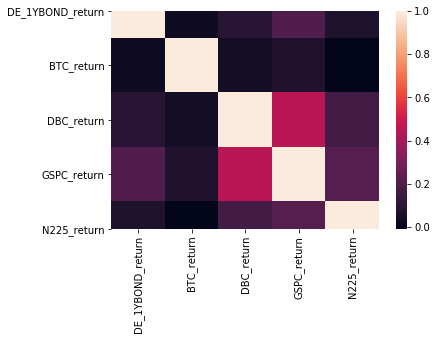

In [152]:
import seaborn as sns
returns = data[['DE_1YBOND_return',"BTC_return", "DBC_return", "GSPC_return", "N225_return"]]

corr = returns.corr()
sns.heatmap(corr)